In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force, calculate_area_between_curves
import datetime
import pickle
import uuid
import matplotlib.cm as cm
torch.set_default_dtype(torch.float64)

In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force, calculate_area_between_curves
import datetime
import pickle
import uuid
import matplotlib.cm as cm
torch.set_default_dtype(torch.float64)

# Study names for each configuration index
study_names = {
    0: "60BAR_4.70_03_study",
    1: "60BAR_4.70_07_study",
    2: "60BAR_4.70_11_study",
    3: "60CENTER_4.70_03_study",
    4: "60CENTER_4.70_07_study",
    5: "60CENTER_4.70_11_study",
    6: "80BAR_4.70_03_study",
    7: "80BAR_4.70_07_study",
    8: "80BAR_4.70_11_study"
}

# File info and custom groups (unchanged)
file_info = [
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar03mms388g.txt",
        "force_start": "31.07.2025 10:39:06.150461",
        "force_end": "31.07.2025 10:39:24.070461",
        "pos_start": "31.07.2025 10:39:24.070461",
        "pos_end": "31.07.2025 10:42:34.610461"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar07mms384g.txt",
        "force_start": "31.07.2025 10:18:27.193997",
        "force_end": "31.07.2025 10:18:35.113997",
        "pos_start": "31.07.2025 10:18:35.113997",
        "pos_end": "31.07.2025 10:20:44.573997"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar11mms414g.txt",
        "force_start": "30.07.2025 13:43:44.197899",
        "force_end": "30.07.2025 13:43:49.057899",
        "pos_start": "30.07.2025 13:43:49.057899",
        "pos_end": "30.07.2025 13:46:49.957899"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar03mms396g.txt",
        "force_start": "29.07.2025 15:27:01.321079",
        "force_end": "29.07.2025 15:27:19.181079",
        "pos_start": "29.07.2025 15:27:19.181079",
        "pos_end": "29.07.2025 15:30:46.881079"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar07mms398g.txt",
        "force_start": "30.07.2025 12:19:49.167098",
        "force_end": "30.07.2025 12:19:57.487098",
        "pos_start": "30.07.2025 12:19:57.487098",
        "pos_end": "30.07.2025 12:21:55.287098"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar11mms393g.txt",
        "force_start": "30.07.2025 12:46:38.439119",
        "force_end": "30.07.2025 12:46:43.619119",
        "pos_start": "30.07.2025 12:46:43.619119",
        "pos_end": "30.07.2025 12:50:18.619119"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar03mms508g.txt",
        "force_start": "30.07.2025 11:47:26.451826",
        "force_end": "30.07.2025 11:47:42.371826",
        "pos_start": "30.07.2025 11:47:42.371826",
        "pos_end": "30.07.2025 11:50:53.831826"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar07mms525g.txt",
        "force_start": "31.07.2025 14:21:37.055615",
        "force_end": "31.07.2025 14:21:43.535615",
        "pos_start": "31.07.2025 14:21:43.535615",
        "pos_end": "31.07.2025 14:24:04.975615"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar11mms531g.txt",
        "force_start": "31.07.2025 14:49:31.716399",
        "force_end": "31.07.2025 14:49:35.816399",
        "pos_start": "31.07.2025 14:49:35.816399",
        "pos_end": "31.07.2025 15:01:25.776399"
    }
]

custom_groups = [
    [
        {"index": 0, "label": "60% BAR 0.3 mm/s"},
        {"index": 1, "label": "60% BAR 0.7 mm/s"},
        {"index": 2, "label": "60% BAR 1.1 mm/s"}
    ],
    [
        {"index": 3, "label": "60% CENTER 0.3 mm/s"},
        {"index": 4, "label": "60% CENTER 0.7 mm/s"},
        {"index": 5, "label": "60% CENTER 1.1 mm/s"}
    ],
    [
        {"index": 6, "label": "80% BAR 0.3 mm/s"},
        {"index": 7, "label": "80% BAR 0.7 mm/s"},
        {"index": 8, "label": "80% BAR 1.1 mm/s"}
    ]
]

xml_folders = {
    0: "H:\\XMLFiles\\60BAR_03",
    1: "H:\\XMLFiles\\60BAR_07",
    2: "H:\\XMLFiles\\60BAR_11",
    3: "H:\\XMLFiles\\60CENTER_03",
    4: "H:\\XMLFiles\\60CENTER_07",
    5: "H:\\XMLFiles\\60CENTER_11",
    6: "H:\\XMLFiles\\80BAR_03",
    7: "H:\\XMLFiles\\80BAR_07",
    8: "H:\\XMLFiles\\80BAR_11"
}

def get_label_from_index(custom_groups, idx):
    for group in custom_groups:
        for item in group:
            if item["index"] == idx:
                return item["label"]
    return f"Index {idx}"

def get_speed(label):
    parts = label.split()
    for i, part in enumerate(parts):
        if part == 'mm/s' and i > 0:
            try:
                return float(parts[i-1])
            except ValueError:
                pass
    return None

def first_crossing_time(t, y, target):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    d = y - target
    sign_change = np.where(np.diff(np.sign(d)) != 0)[0]
    if sign_change.size == 0:
        return None
    i = sign_change[0]
    t0, t1 = t[i], t[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return t0
    return t0 + (target - y0) * (t1 - t0) / (y1 - y0)

def load_master_curve(index):
    info = file_info[index]
    label = get_label_from_index(custom_groups, index)

    df = pd.read_csv(
        info["path"],
        encoding='utf-16-le',
        sep=';',
        skiprows=1,
        quotechar='"'
    ).rename(columns={
        'time': 'Time',
        'dbPr\\diIstPos': 'Pos',
        'dbPr\\diIstKraftGes': 'Force'
    })

    df = df[['Time', 'Pos', 'Force']]
    df['Pos'] = pd.to_numeric(df['Pos'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df['Force'] = pd.to_numeric(df['Force'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df = df[df['Time'] != 'sec']
    df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S.%f')

    force_start = pd.to_datetime(info["force_start"], format='%d.%m.%Y %H:%M:%S.%f')
    force_end = pd.to_datetime(info["force_end"], format='%d.%m.%Y %H:%M:%S.%f')
    dfw = df[(df['Time'] >= force_start) & (df['Time'] <= force_end)].copy()
    dfw['Time_seconds'] = (dfw['Time'] - force_start).dt.total_seconds()

    target_pos = 4.7 if "60%" in label else 6.39
    t_cross = first_crossing_time(dfw['Time_seconds'], dfw['Pos'], target_pos)
    if t_cross is None:
        return None, None, None, label
    t_cross -= 0.7

    dfw_clipped = dfw[dfw['Time_seconds'] <= t_cross].copy()
    real_time = dfw_clipped['Time_seconds'].to_numpy()
    real_force = dfw_clipped['Force'].to_numpy()  # Already in kN

    return real_time, real_force, t_cross, label

def parse_xml_force(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        data = []

        for time_block, dept_block in zip(root.findall('.//Block//IndpVar'), root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            data.append((time_value, dept_value))

        data_array = np.array([(float(x), float(y)) for x, y in data])
        force_time = data_array[:, 0]
        force = data_array[:, 1] * 9.80665  # Convert tonnes to kN
        return force_time, force
    except (FileNotFoundError, ET.ParseError):
        return None, None

def load_sim_curve(index, study_name):
    folder = xml_folders[index]
    xml_path = os.path.join(folder, f"{study_name}.xml")
    label = get_label_from_index(custom_groups, index)

    sim_time, sim_force = parse_xml_force(xml_path)
    if sim_time is None:
        return None, None, None

    speed = get_speed(label)
    if speed is None:
        return None, None, None

    target_pos = 4.7 if "60%" in label else 6.39
    t_target = target_pos / speed
    t_clip = t_target - 0.7
    if t_clip < 0:
        t_clip = 0

    mask = sim_time <= t_clip
    if not np.any(mask):
        return None, None, None

    sim_time = sim_time[mask]
    sim_force = sim_force[mask]

    return sim_time, sim_force, t_clip

def compute_mse(real_time, real_force, sim_time, sim_force):
    if len(real_time) == 0 or len(sim_time) == 0:
        return np.nan
    interp = interp1d(sim_time, sim_force, kind='linear', fill_value='extrapolate')
    sim_interp = interp(real_time)
    mse = np.mean((real_force - sim_interp)**2)
    return mse

# Initialize dictionary to store MSEs for each study across configurations
study_mses = {f"Study {i}": [] for i in range(1, 31)}

# Main computation and plotting for original 30 studies
for index in range(9):  # 0 to 8
    real_time, real_force, t_cross, label = load_master_curve(index)
    if real_time is None:
        print(f"Skipping {label}: no crossing in master curve")
        for study in range(1, 31):
            study_mses[f"Study {study}"].append((label, np.nan))
        continue

    # Initialize plot
    plt.figure(figsize=(12, 8))
    
    # Plot real data
    plt.plot(real_time, real_force, label='Real Force', color='black', linewidth=2)
    plt.axvline(x=t_cross, color='red', linestyle='--', label=f'Real Clip (t={t_cross:.2f}s)')

    # Plot simulation data and collect MSEs
    colors = cm.viridis(np.linspace(0, 1, 30))  # Use viridis colormap for 30 distinct colors
    for study in range(1, 31):  # 1 to 30
        sim_time, sim_force, t_clip = load_sim_curve(index, f"study_{study}")
        if sim_time is None:
            print(f"Skipping study {study} for {label}: invalid sim curve")
            study_mses[f"Study {study}"].append((label, np.nan))
            continue
        plt.plot(sim_time, sim_force, label=f'Sim Study {study}', color=colors[study-1], alpha=0.7, linewidth=1)
        if study == 1:  # Plot t_clip only once to avoid clutter
            plt.axvline(x=t_clip, color='blue', linestyle='--', label=f'Sim Clip (t={t_clip:.2f}s)')
        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        study_mses[f"Study {study}"].append((label, mse))

    # Plot settings
    plt.xlabel('Time (s)')
    plt.ylabel('Force (kN)')
    plt.title(f'Force-Time Curves: {label}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    
    # Display plot in Jupyter
    plt.show()

# Calculate summed MSEs for original 30 studies
summed_mses = []
valid_indices = []
for study in range(1, 31):
    study_key = f"Study {study}"
    mses = [mse for _, mse in study_mses[study_key] if not np.isnan(mse)]
    sum_mse = np.sum(mses) if mses else np.nan
    summed_mses.append((f"Study {study}", sum_mse))
    if not np.isnan(sum_mse):
        valid_indices.append(study - 1)  # 0-based index for parameters

# Load parameter data
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
if data.shape[0] != 30:
    raise ValueError(f"Expected 30 parameter sets, got {data.shape[0]}")

# Prepare data for optimization
n_values = data['n'].values
tau_star_values = data['tau_star'].values
B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor(
    [[n_values[i], tau_star_values[i], B_values[i], tau_w_values[i], m_values[i]] for i in valid_indices],
    dtype=torch.float64
)
train_y = torch.tensor(
    [[-summed_mses[i][1]] for i in range(len(summed_mses)) if not np.isnan(summed_mses[i][1])],
    dtype=torch.float64
)
train_yvar = torch.full_like(train_y, 1e-6)

# Define bounds for optimization
bounds = torch.tensor([
    [0.2, 1e+3, 1e+3, 0.005, 1.0],
    [0.6, 1e+5, 1e+5, 1.0, 1.9]
], dtype=torch.float64)

# Optimization loop
sim_dir = "G:\\Oskay Sözen\\Optimization\\Optimization.mpi"
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"
num_runs = 15
log_dir = "H:\\XMLFiles\\logs"
os.makedirs(log_dir, exist_ok=True)

Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
Synergy.OpenProject(sim_dir)

for run in range(num_runs):
    print(f"\nOptimization Run {run + 1}/{num_runs}")

    # Train GP model
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=5)
    model = SingleTaskGP(train_x, train_y, train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()

    # Optimize acquisition function
    acq_func = LogExpectedImprovement(model, best_f=train_y.max())
    candidate_optim, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=5000,
    )

    print(f"Optimized parameters for run {run + 1} [n, tau_star, B, tau_w, m]:")
    print(candidate_optim)

    # Run new simulations for each configuration
    new_study_mses = []
    for i in range(9):  # 0 to 8 configurations
        label = get_label_from_index(custom_groups, i)
        study_name = f"optimization_{run + 1}_{i + 1}"  # Unique name: optimization_run_config
        # Open the specific study for the configuration
        config_study_name = study_names[i]
        Synergy.Project.OpenItemByName(config_study_name, "Study")
    
        
        # Copy the study settings to a new study
        StudyDoc = Synergy.StudyDoc

        # Set up simulation parameters
        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090, 1)
        Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, {candidate_optim[0,2].item()}, 0.004, 0, 0, 0.305")
        PropEd.CommitChanges("Process Conditions")

        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090, 1)
        DVec = Synergy.CreateDoubleArray
        DVec.AddDouble(candidate_optim[0,3].item())
        DVec.AddDouble(candidate_optim[0,4].item())
        DVec.AddDouble(1e-08)
        DVec.AddDouble(0)
        DVec.AddDouble(0)
        Prop.FieldValues(51182, DVec)
        PropEd.CommitChanges("Process Conditions")

        # Save the new study
        study_path = os.path.join("G:\\Oskay Sözen\\Optimization", f"{study_name}.sdy")
        StudyDoc.SaveAs(study_name)

        # Run simulation
        log_file = os.path.join(log_dir, f"{study_name}_config_{i+1}.log")
        with open(log_file, 'w') as f_log:
            p = subprocess.Popen(
                [os.path.join(moldflow, "runstudy.exe"), study_path],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                text=True
            )
            output, err = p.communicate()
            f_log.write(output)
            if err:
                f_log.write(err)

        time.sleep(3)
        subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"])
        time.sleep(2)

        # Export results
        Synergy.OpenProject("G:\\Oskay Sözen\\Optimization\\Optimization.mpi")
        Project = Synergy.Project
        Project.OpenItemByName(study_name, "Study")
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
        Pid = Plot.GetDataID
        PlotMgr = None
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        xml_path = os.path.join(xml_folders[i], f"{study_name}.xml")
        PlotMgr.SaveResultDataInXML2(Pid, xml_path, "Metric")
        print(f"Saved XML to {xml_path}")

        # Calculate MSE for new simulation
        real_time, real_force, t_cross, _ = load_master_curve(i)
        if real_time is None:
            print(f"Skipping new simulation for {label}: no real data")
            new_study_mses.append((label, np.nan))
            continue

        sim_time, sim_force, t_clip = load_sim_curve(i, study_name)
        if sim_time is None:
            print(f"Skipping new simulation for {label}: invalid sim curve")
            new_study_mses.append((label, np.nan))
            continue

        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        new_study_mses.append((label, mse))

        # Plot new simulation
        plt.figure(figsize=(12, 8))
        plt.plot(real_time, real_force, label='Real Force', color='black', linewidth=2)
        plt.plot(sim_time, sim_force, label=f'Optimization {run + 1} Config {i + 1}', color='green', linewidth=1.5)
        plt.axvline(x=t_cross, color='red', linestyle='--', label=f'Real Clip (t={t_cross:.2f}s)')
        plt.axvline(x=t_clip, color='blue', linestyle='--', label=f'Sim Clip (t={t_clip:.2f}s)')
        plt.xlabel('Time (s)')
        plt.ylabel('Force (kN)')
        plt.title(f'New Simulation vs Real (Run {run + 1}, Config {i + 1}): {label}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Calculate summed MSE for new study
    mses = [mse for _, mse in new_study_mses if not np.isnan(mse)]
    sum_mse_new = np.sum(mses) if mses else np.nan
    summed_mses.append((f'Optimization {run + 1}', sum_mse_new))

    # Update parameter data
    new_params = candidate_optim.numpy().flatten()
    data = data.append({
        'n': new_params[0],
        'tau_star': new_params[1],
        'B': new_params[2],
        'tau_w': new_params[3],
        'm': new_params[4]
    }, ignore_index=True)

    # Update training data
    valid_indices = []
    train_y_list = []
    for i, (study, sum_mse) in enumerate(summed_mses):
        if not np.isnan(sum_mse):
            valid_indices.append(i)
            train_y_list.append(sum_mse)

    train_x = torch.tensor(
        [[data['n'].values[i], data['tau_star'].values[i], data['B'].values[i],
          data['tau_w'].values[i], data['m'].values[i]] for i in valid_indices],
        dtype=torch.float64
    )
    train_y = torch.tensor([[-y] for y in train_y_list], dtype=torch.float64)
    train_yvar = torch.full_like(train_y, 1e-6)

# Output final results
print(f"\nFinal summed MSEs for {30 + num_runs} parameter sets:")
mse_df = pd.DataFrame(summed_mses, columns=['Parameter Set', 'Summed MSE'])
display(mse_df)

print(f"\nFinal optimized parameters [n, tau_star, B, tau_w, m] after {num_runs} runs:")
print(candidate_optim)

print("\nDetailed MSEs for original 30 studies:")
for study in range(1, 31):
    study_key = f"Study {study}"
    print(f"{study_key}:")
    for label, mse in study_mses[study_key]:
        print(f"  {label}: MSE = {mse if not np.isnan(mse) else 'NaN'}")

print(f"\nDetailed MSEs for {num_runs} new simulations:")
for run in range(num_runs):
    new_study_mses = []
    for i in range(9):
        label = get_label_from_index(custom_groups, i)
        study_name = f"optimization_{run + 1}_{i + 1}"
        sim_time, sim_force, t_clip = load_sim_curve(i, study_name)
        real_time, real_force, _, _ = load_master_curve(i)
        if sim_time is None or real_time is None:
            new_study_mses.append((label, np.nan))
            continue
        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        new_study_mses.append((label, mse))
    print(f"Optimization {run + 1}:")
    for label, mse in new_study_mses:
        print(f"  {label}: MSE = {mse if not np.isnan(mse) else 'NaN'}")

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


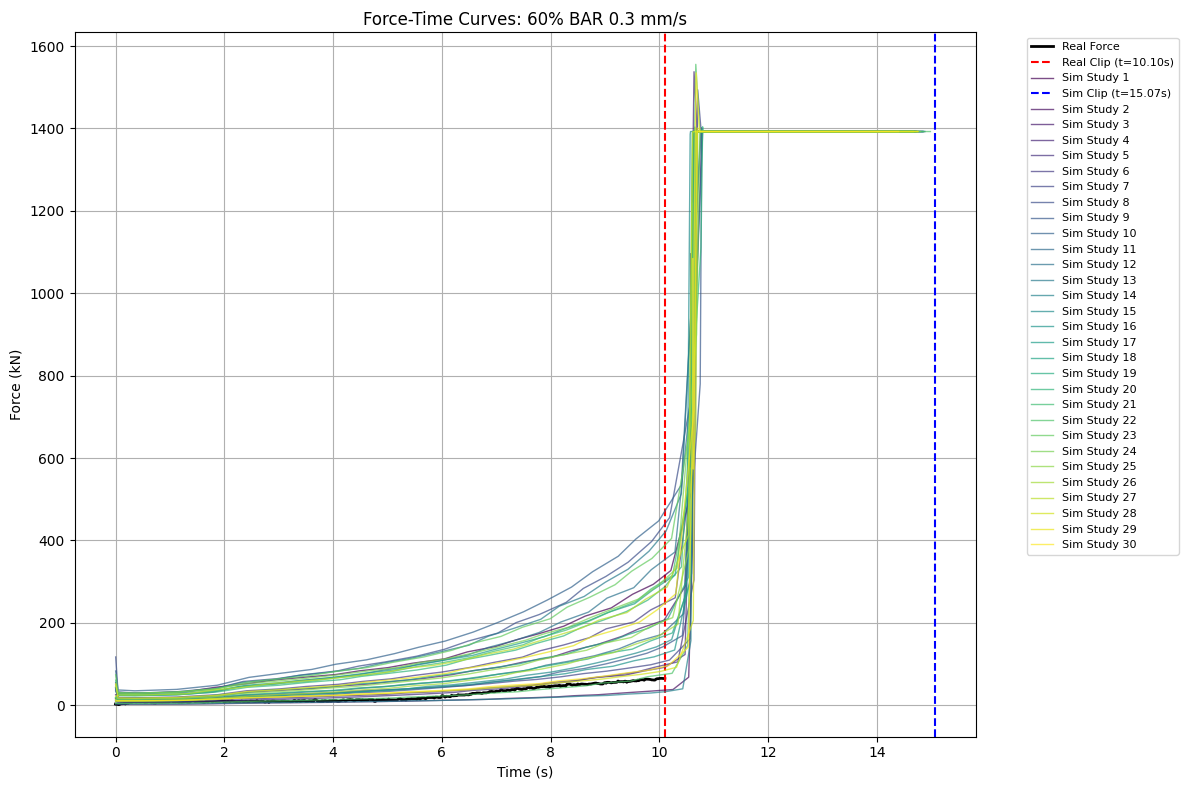

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


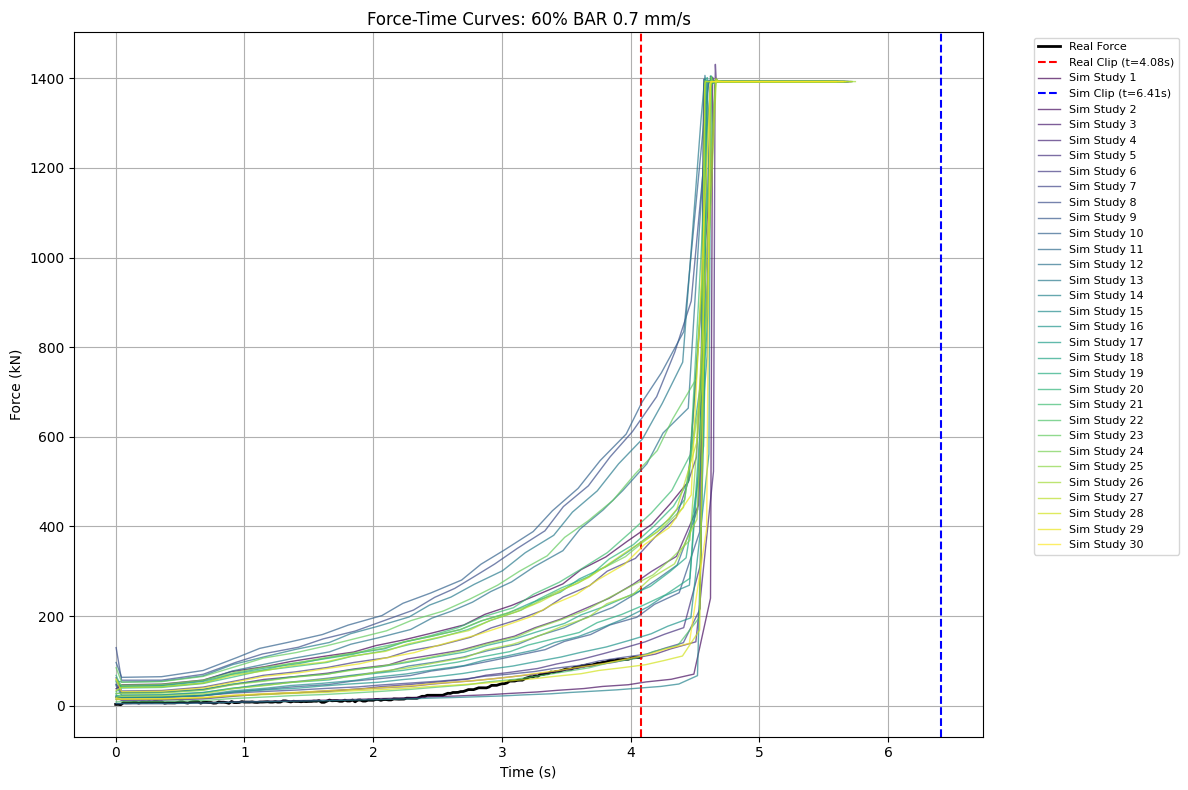

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


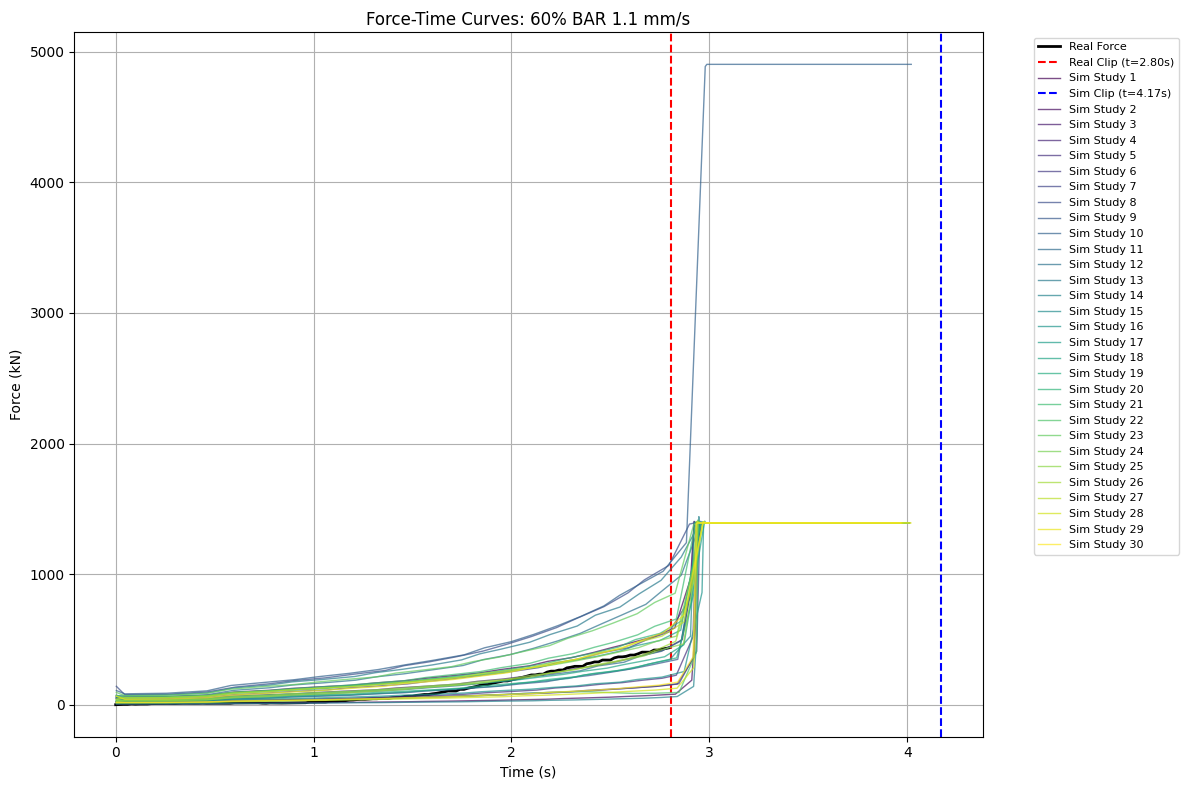

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


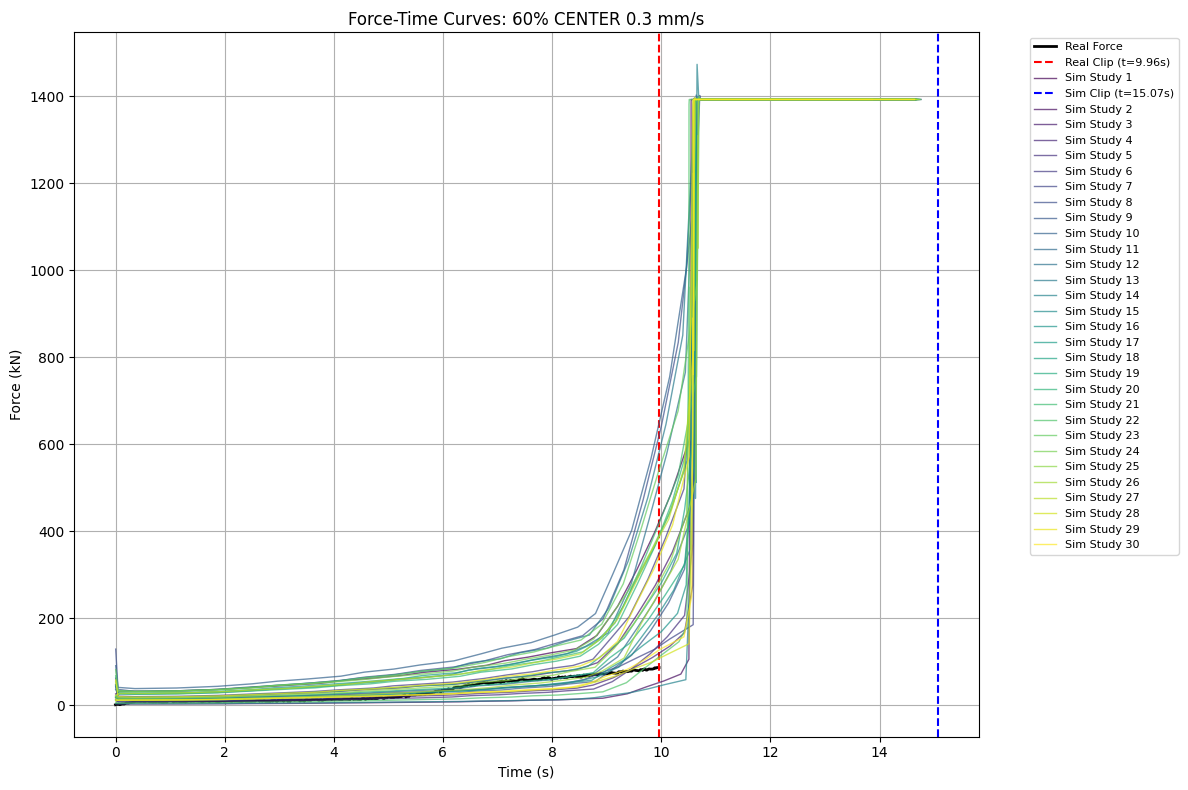

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


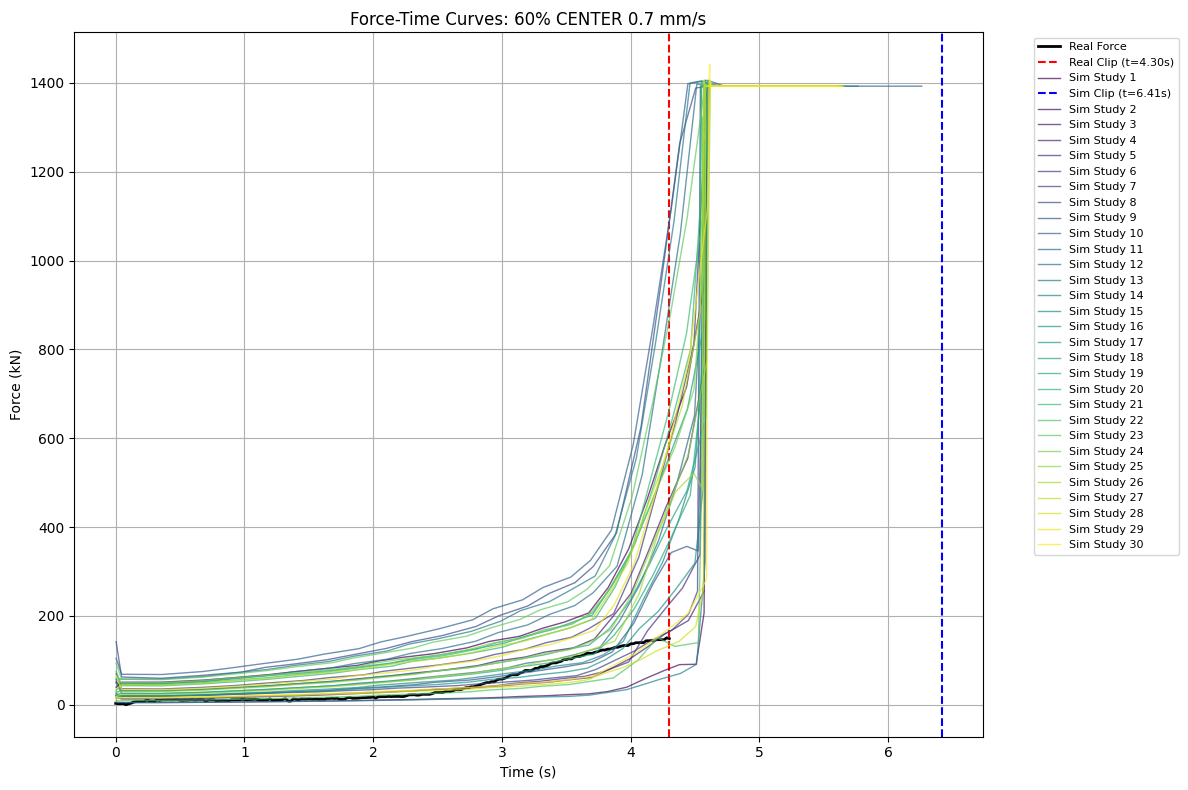

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


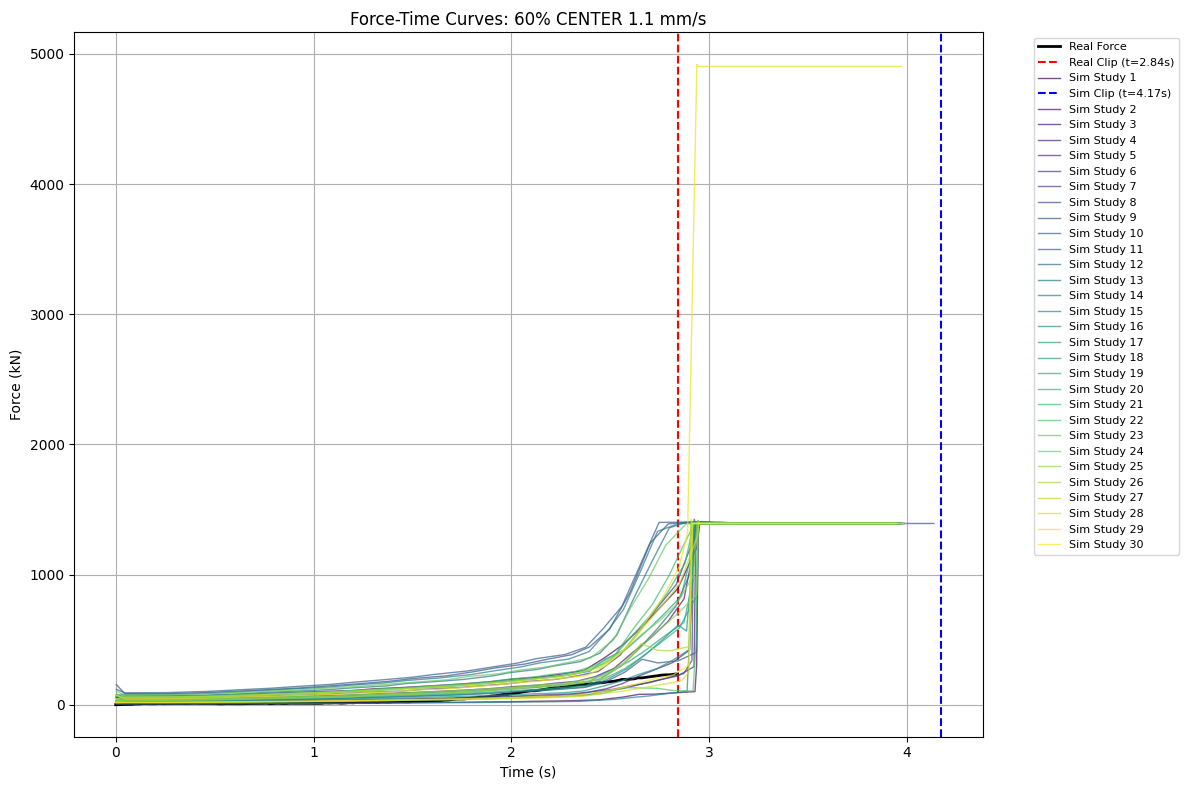

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


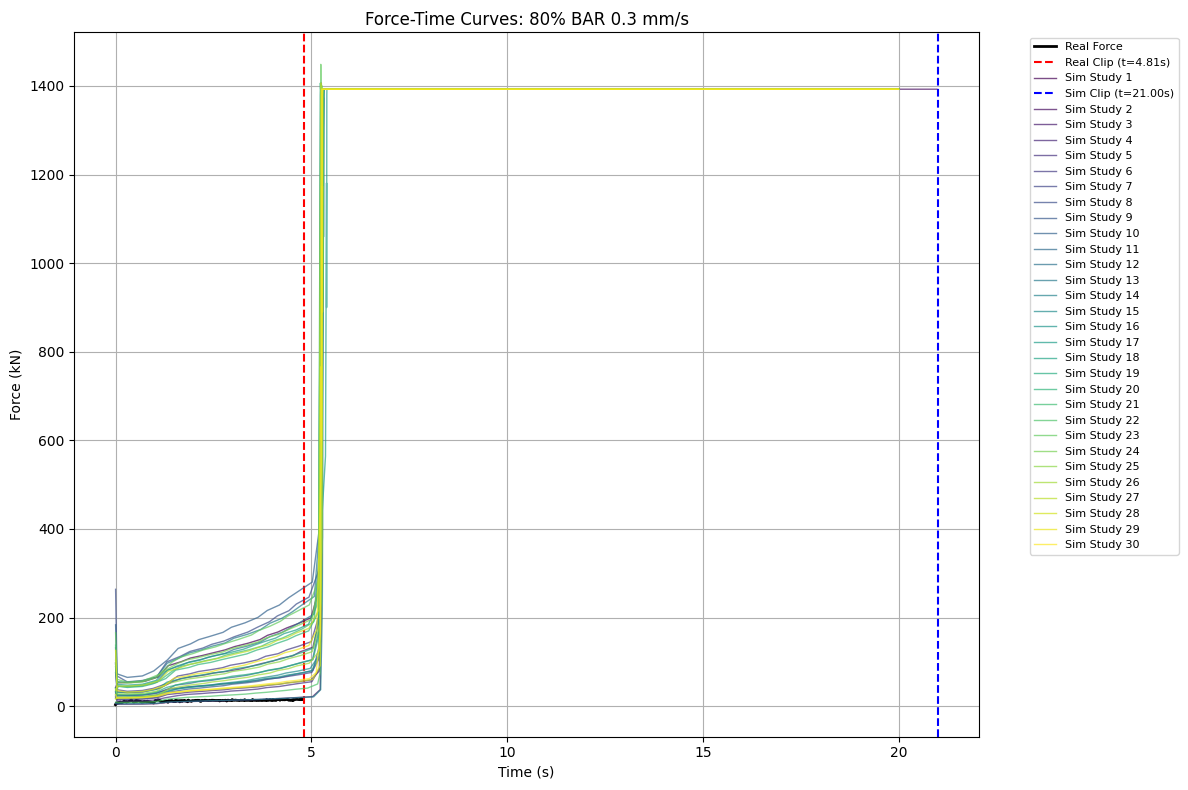

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


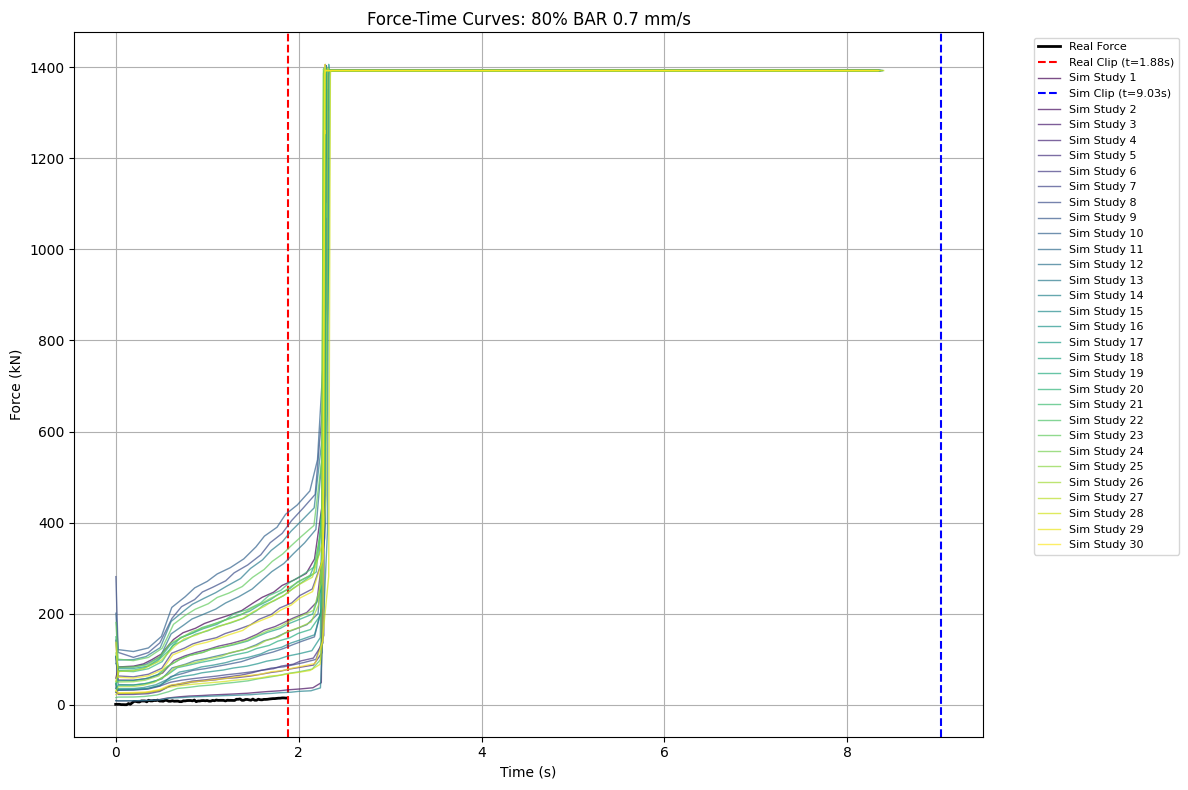

C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


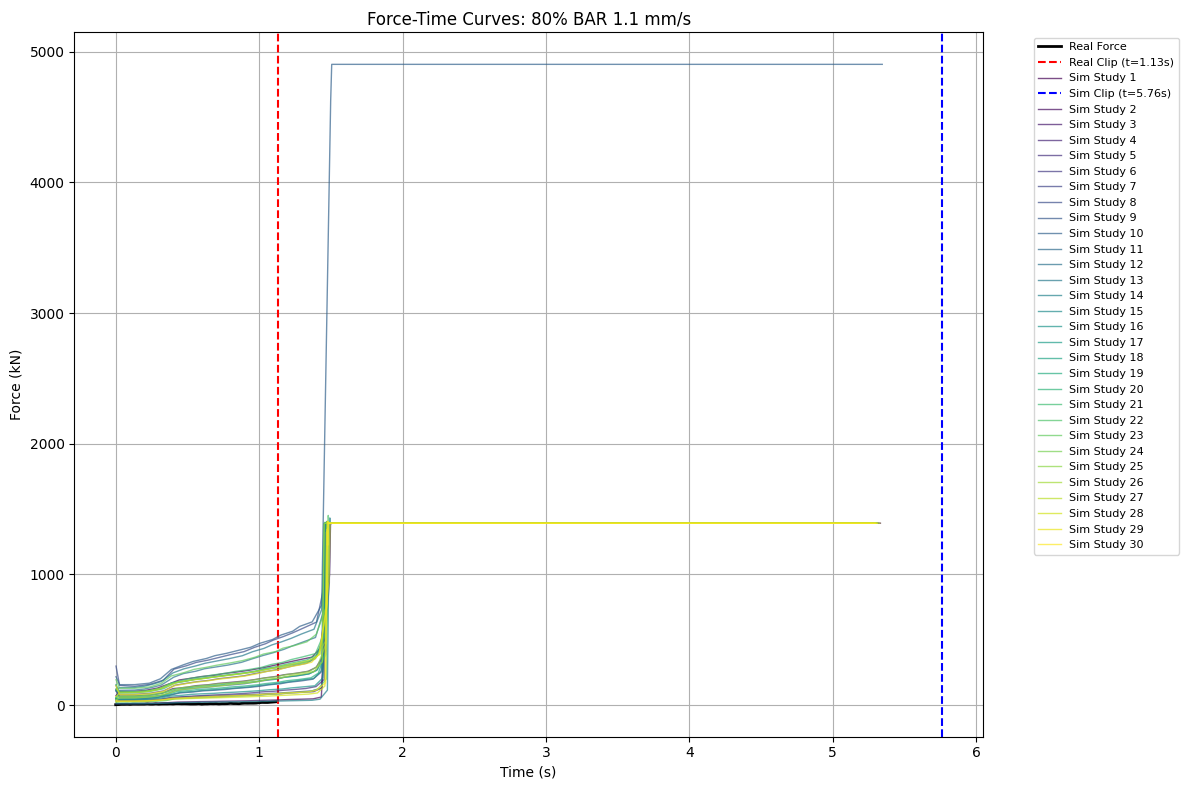


Optimization Run 1/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 1 [n, tau_star, B, tau_w, m]:
tensor([[3.3866e-01, 2.4973e+03, 7.0337e+04, 7.0669e-01, 1.0000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_1_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


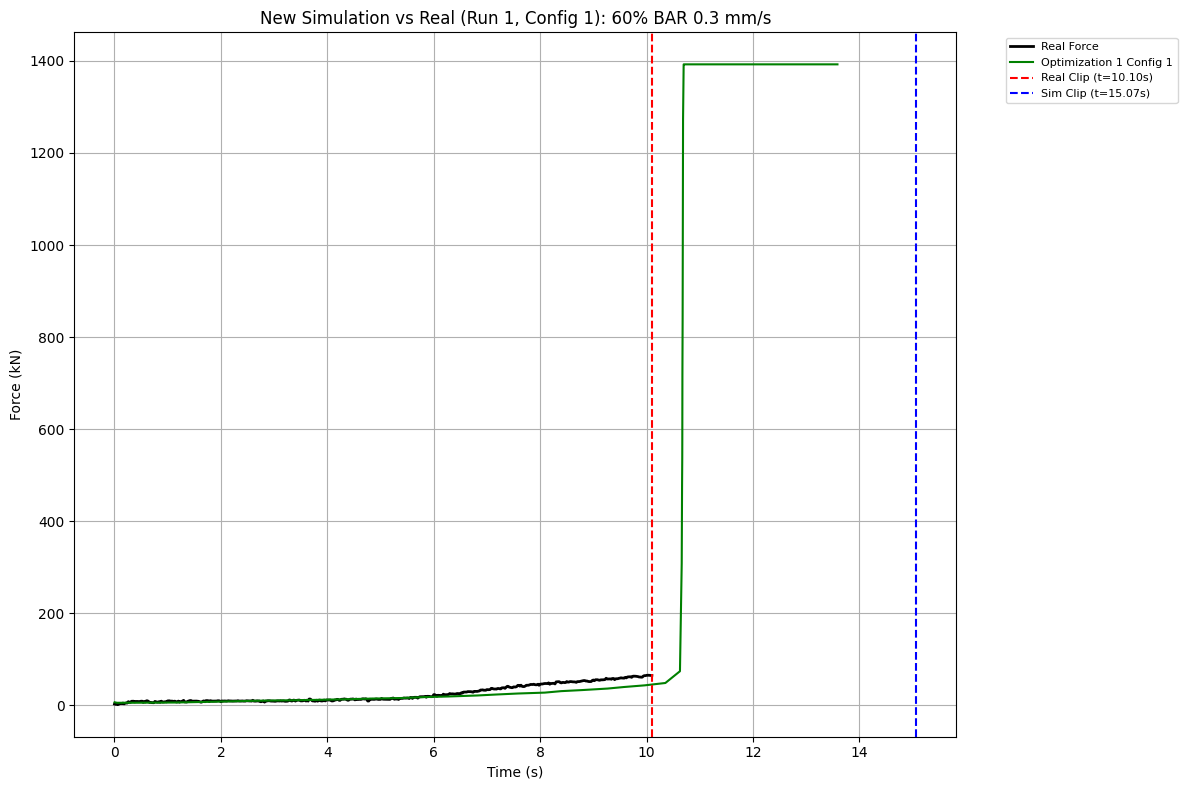

Saved XML to H:\XMLFiles\60BAR_07\optimization_1_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


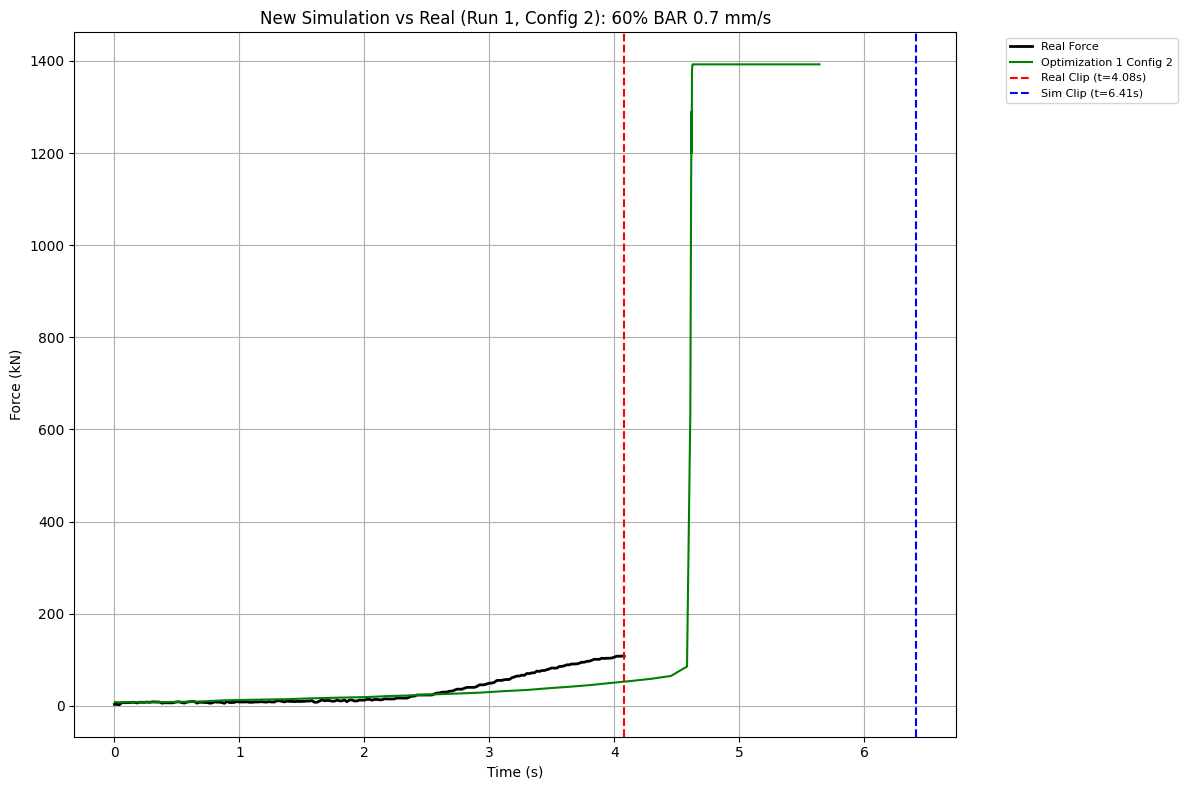

Saved XML to H:\XMLFiles\60BAR_11\optimization_1_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


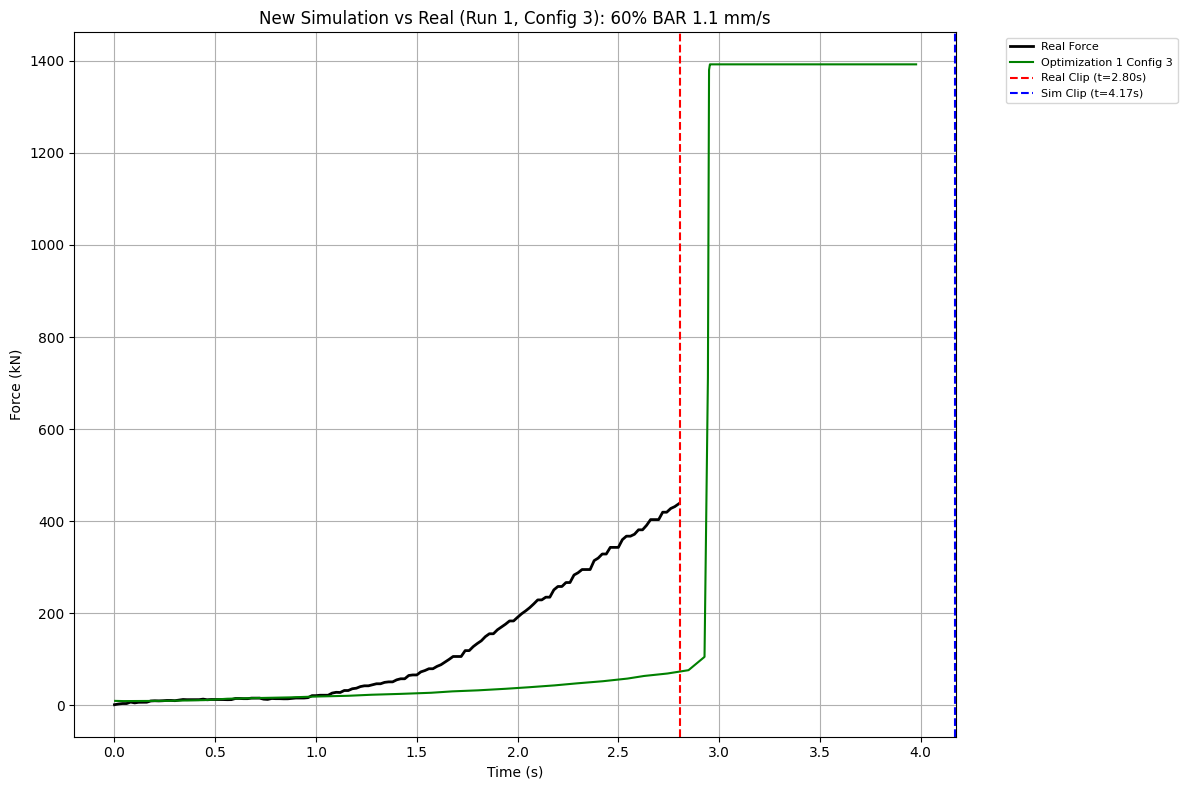

Saved XML to H:\XMLFiles\60CENTER_03\optimization_1_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


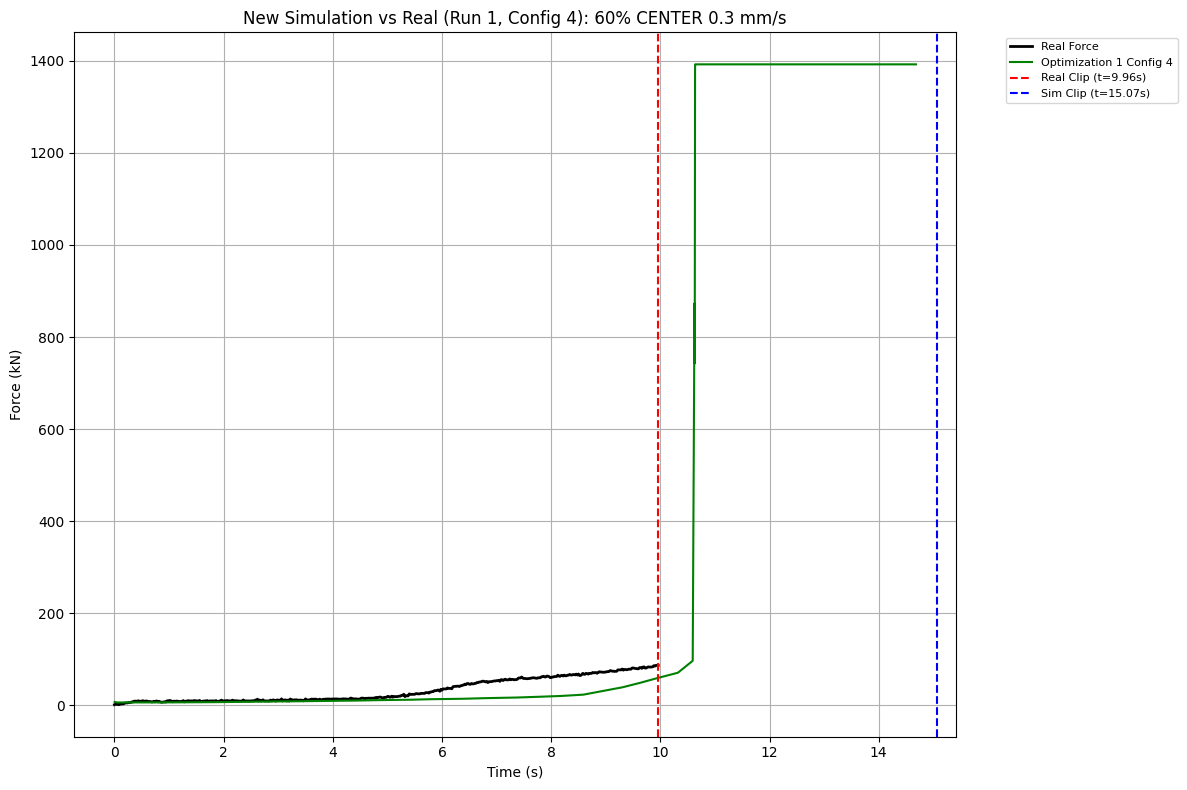

Saved XML to H:\XMLFiles\60CENTER_07\optimization_1_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


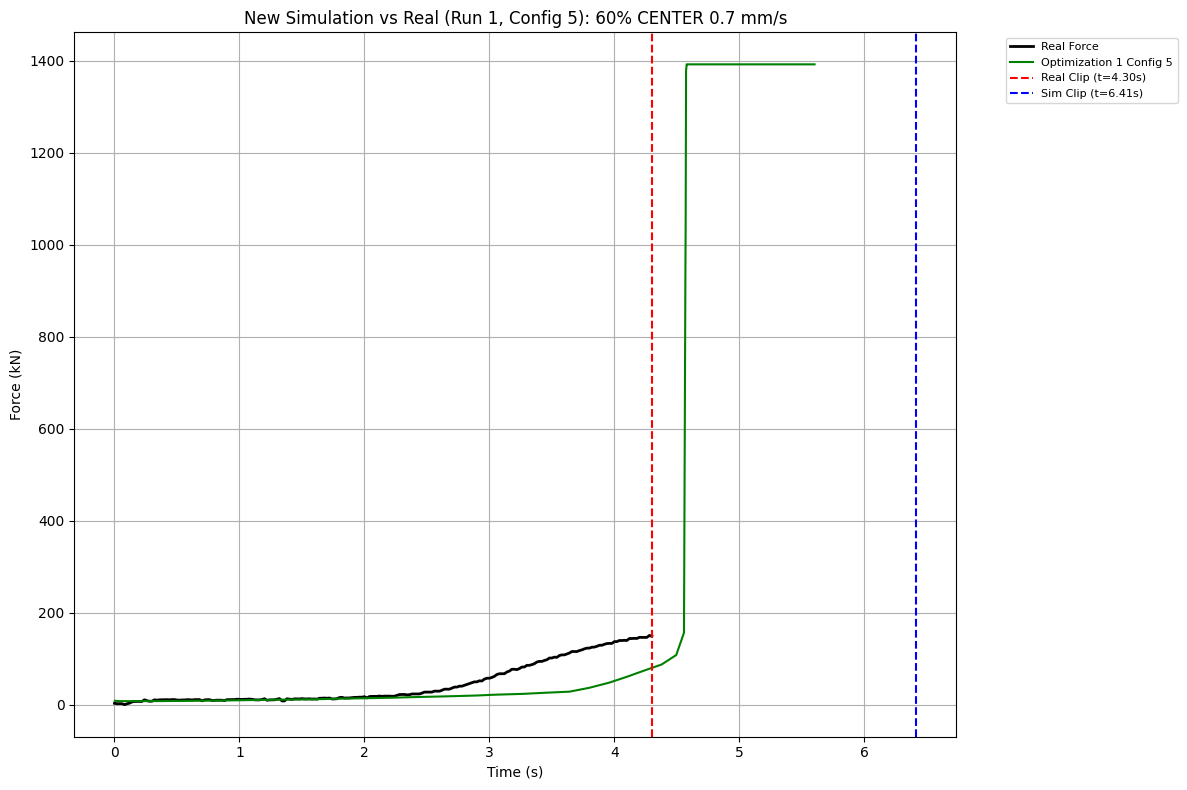

Saved XML to H:\XMLFiles\60CENTER_11\optimization_1_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


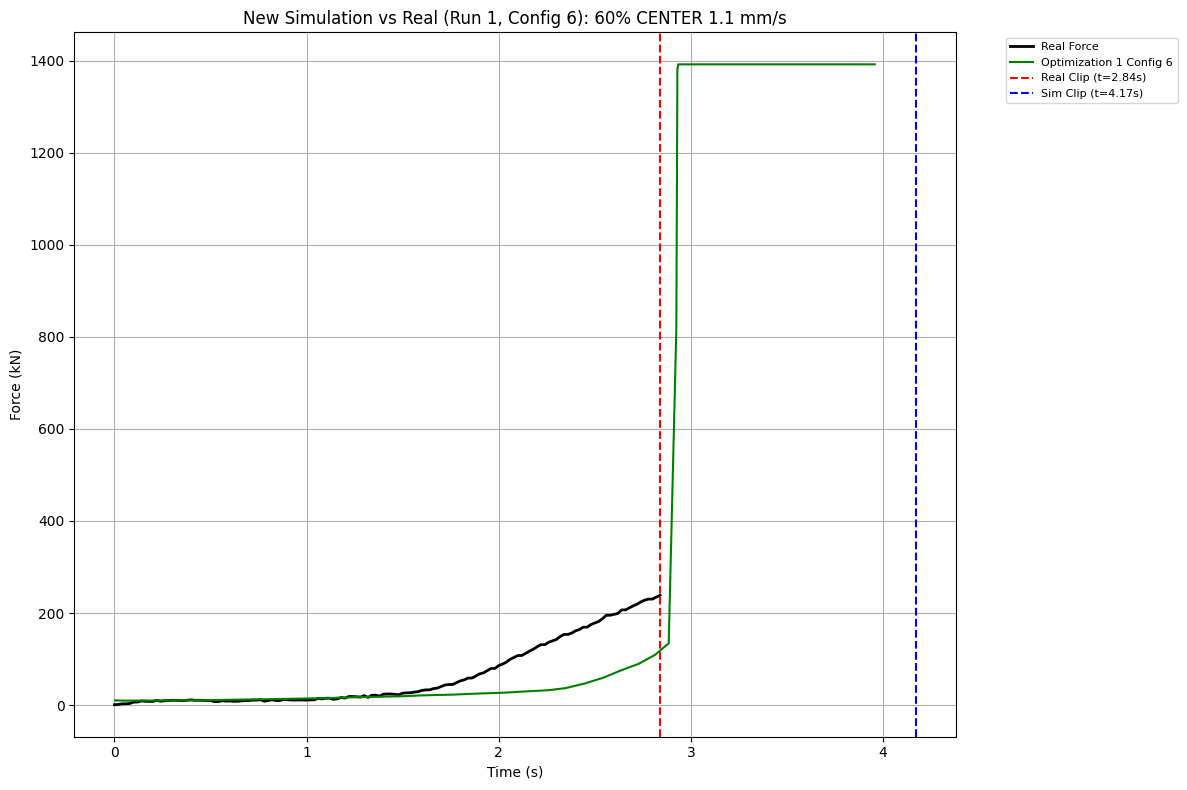

Saved XML to H:\XMLFiles\80BAR_03\optimization_1_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


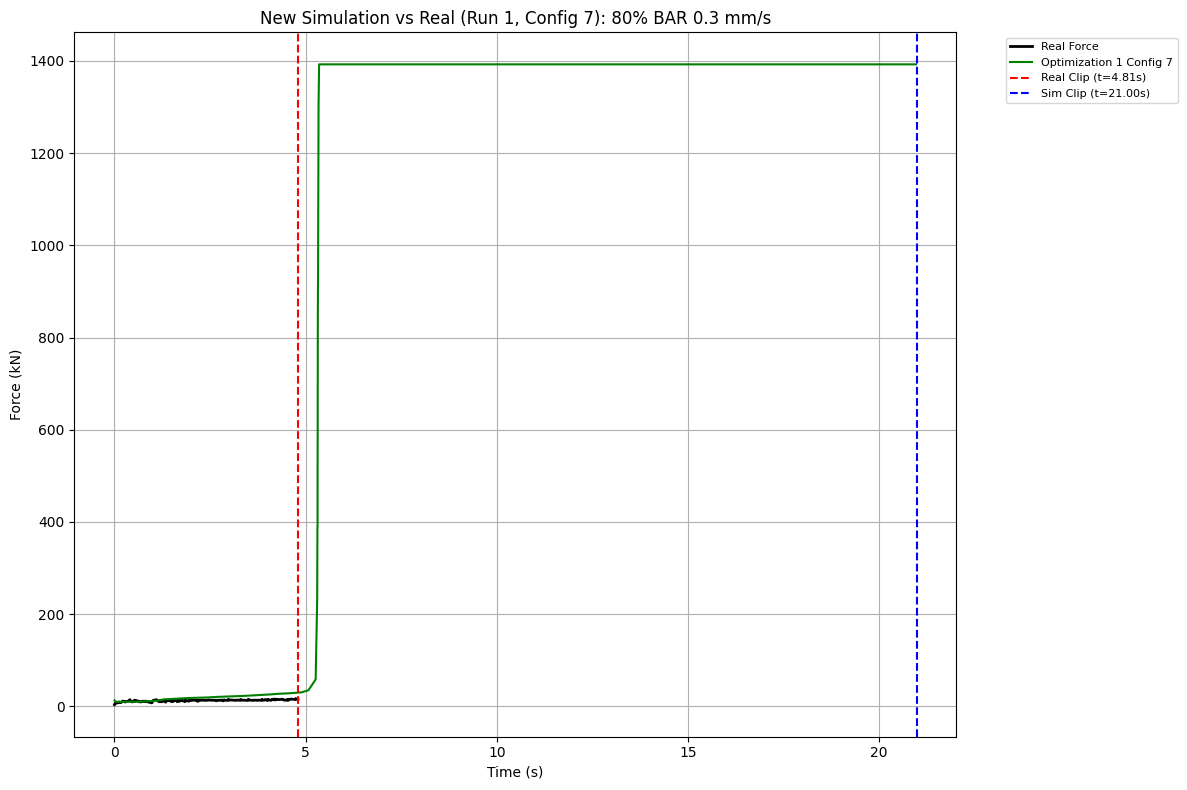

Saved XML to H:\XMLFiles\80BAR_07\optimization_1_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


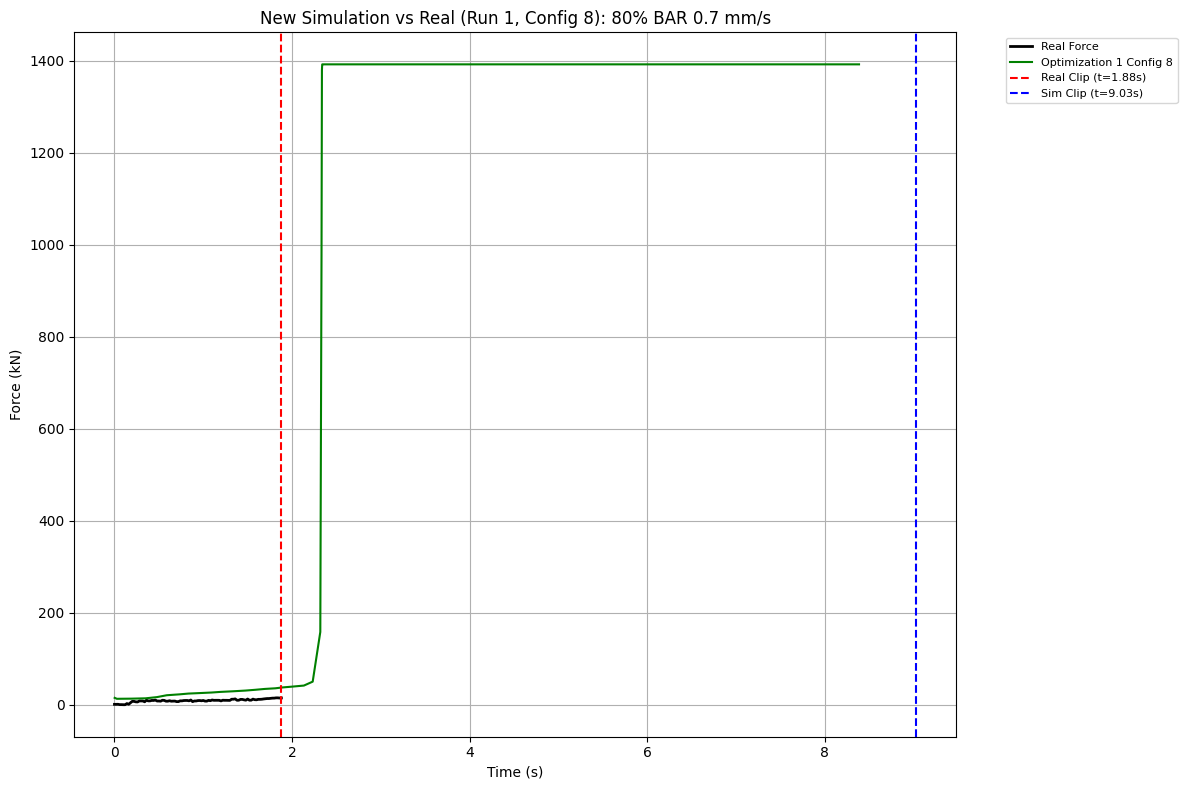

Saved XML to H:\XMLFiles\80BAR_11\optimization_1_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


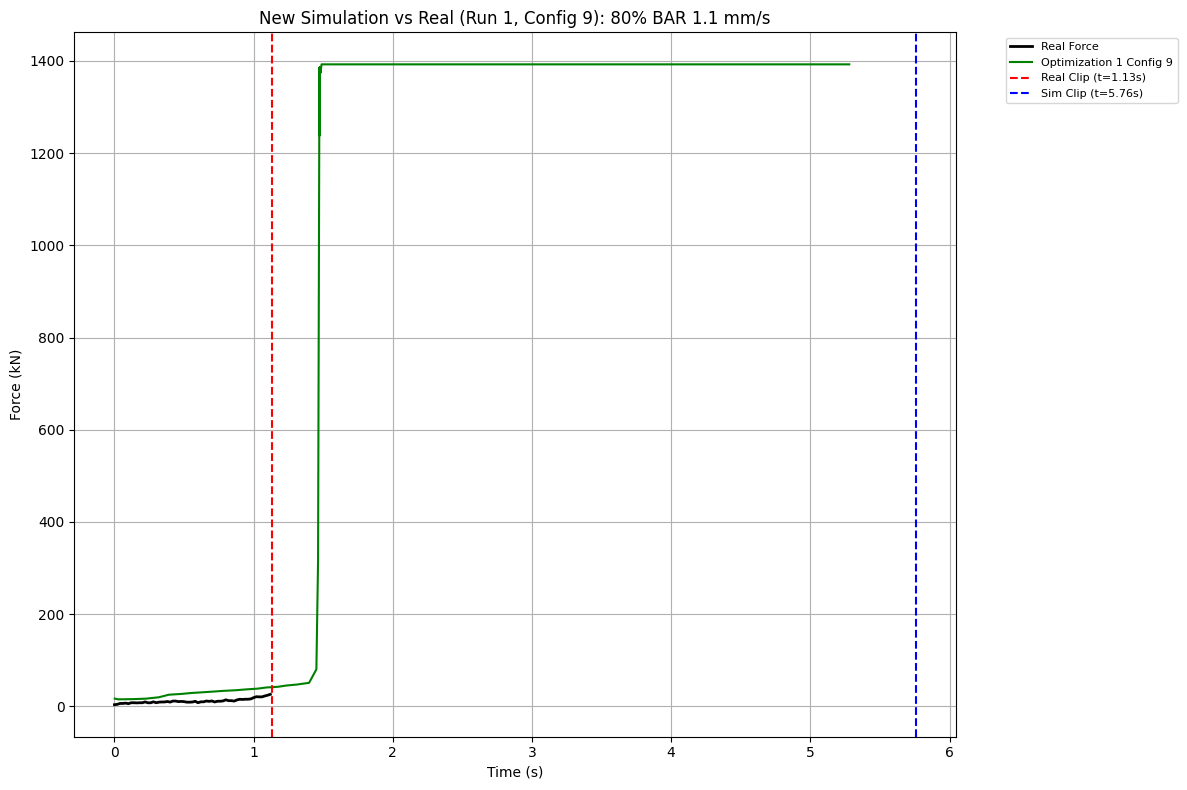


Optimization Run 2/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 2 [n, tau_star, B, tau_w, m]:
tensor([[5.2817e-01, 9.9111e+04, 3.9812e+03, 5.0000e-03, 1.9000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_2_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


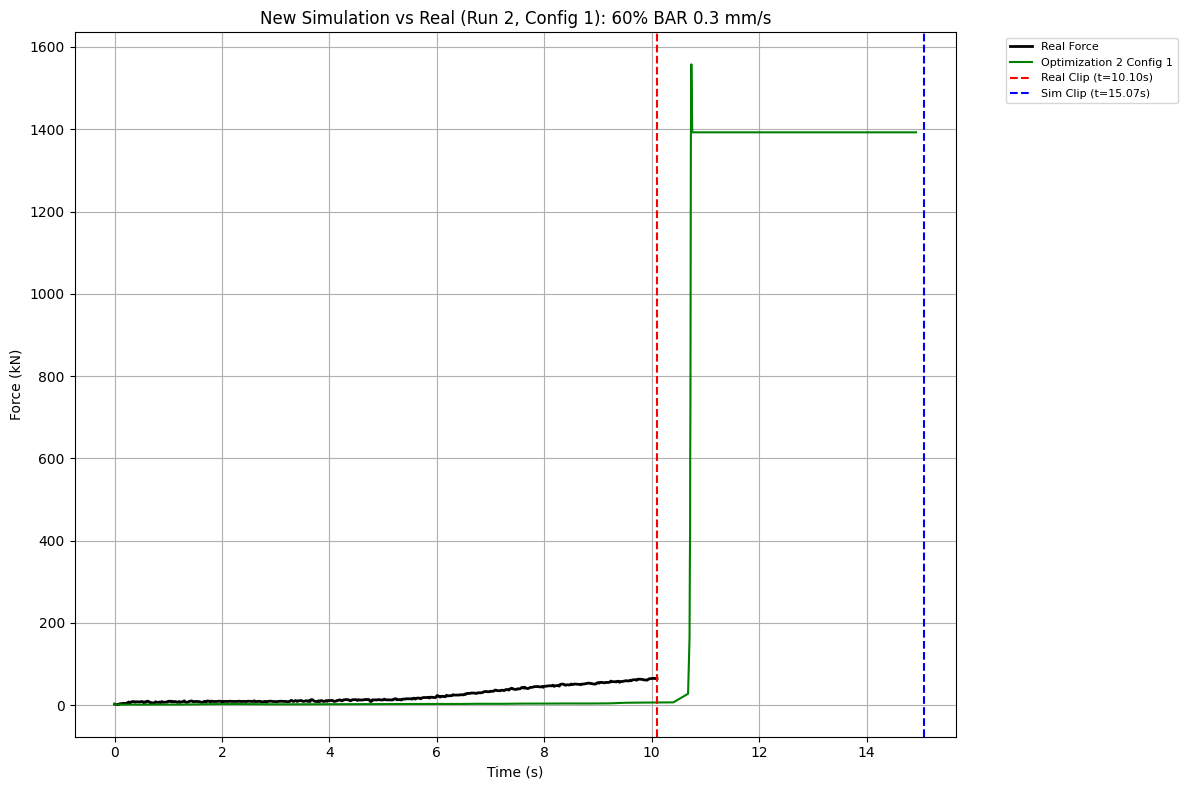

Saved XML to H:\XMLFiles\60BAR_07\optimization_2_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


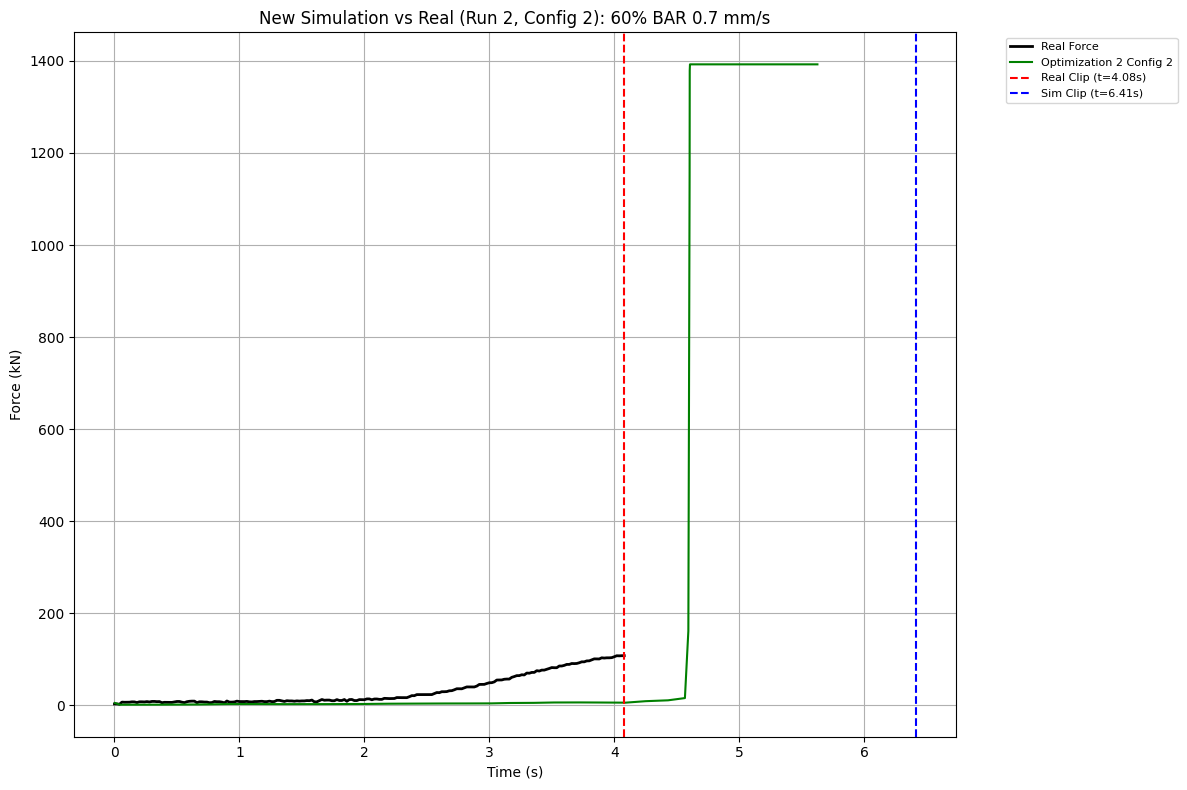

Saved XML to H:\XMLFiles\60BAR_11\optimization_2_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


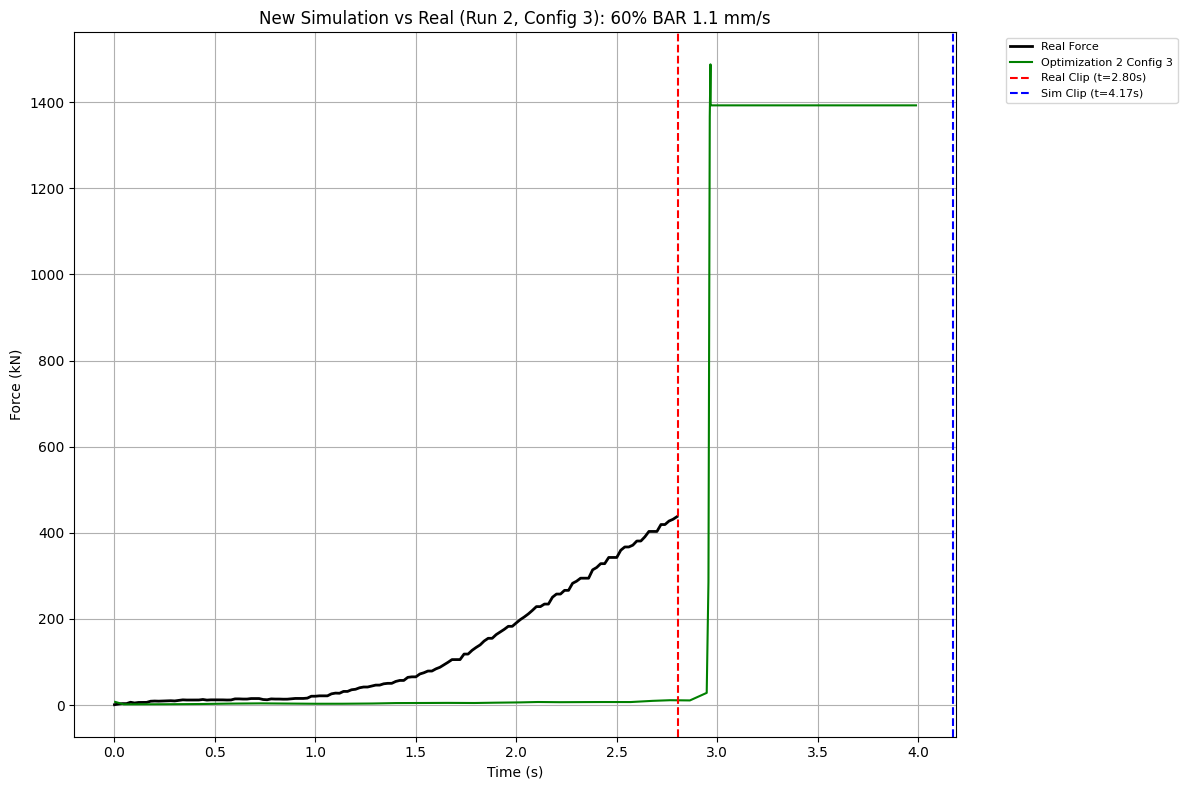

Saved XML to H:\XMLFiles\60CENTER_03\optimization_2_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


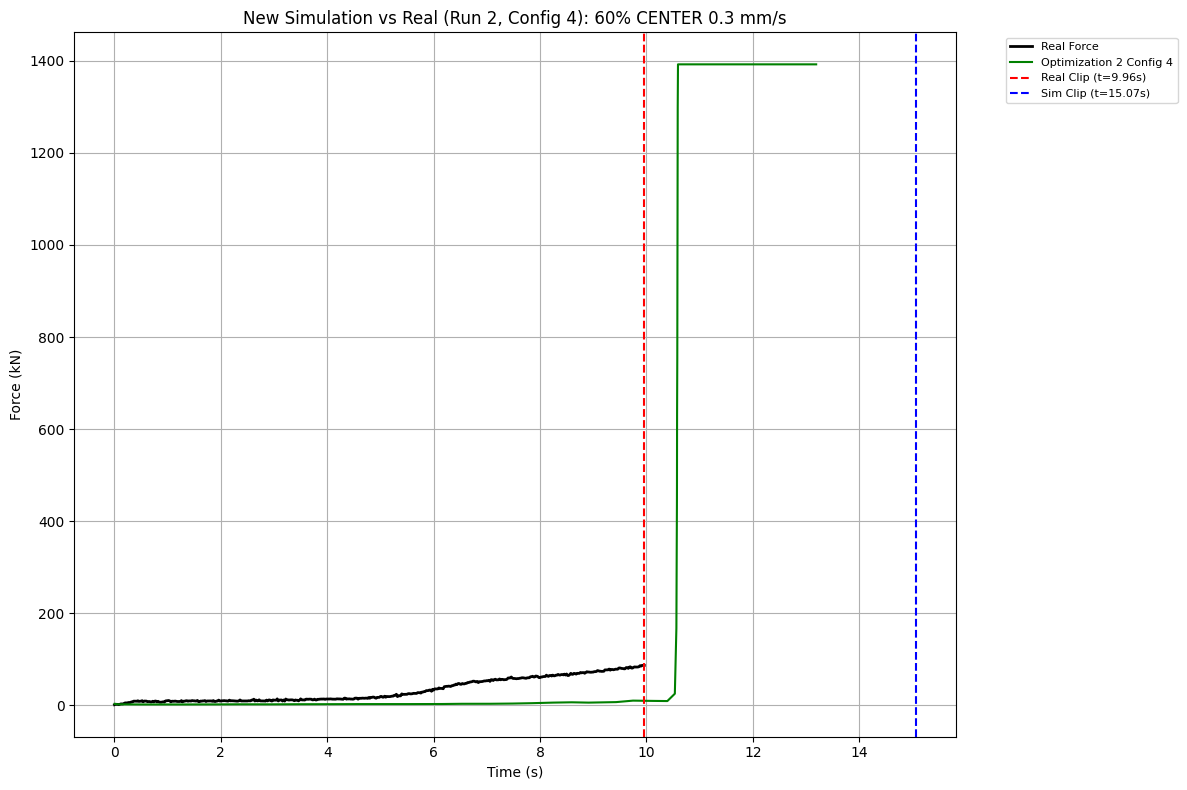

Saved XML to H:\XMLFiles\60CENTER_07\optimization_2_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


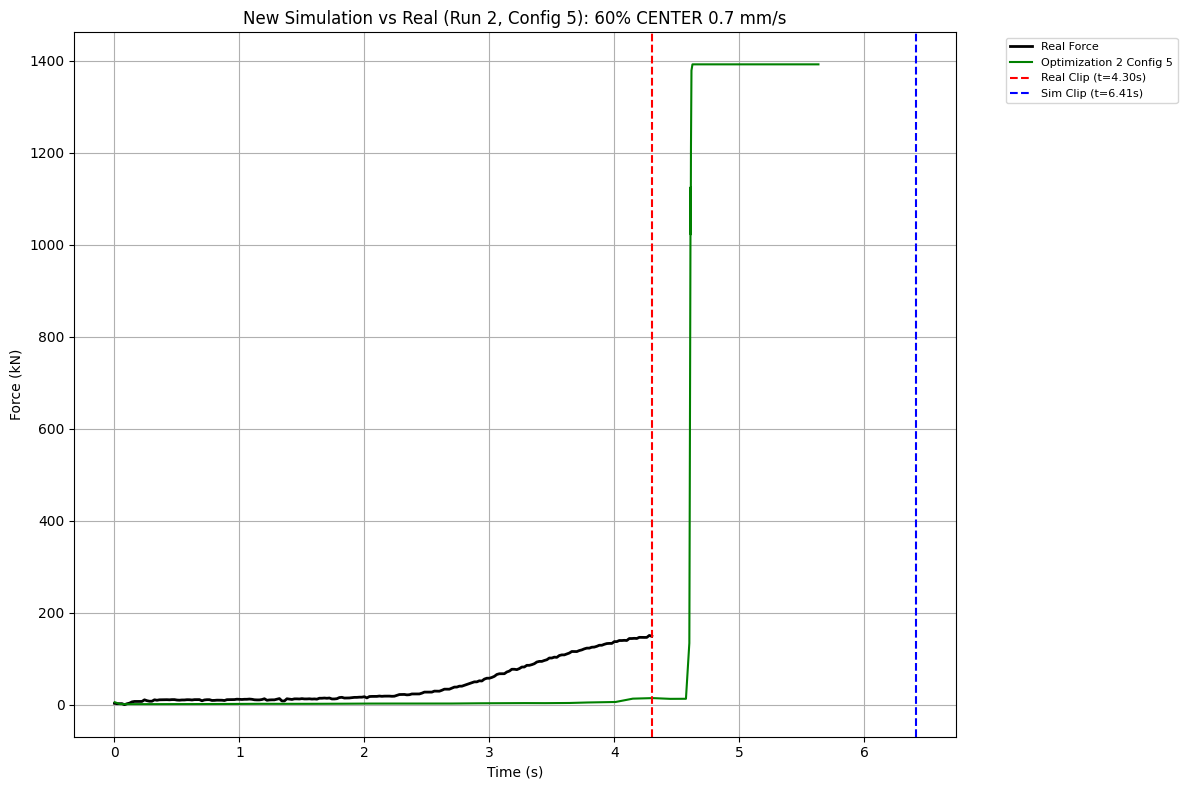

Saved XML to H:\XMLFiles\60CENTER_11\optimization_2_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


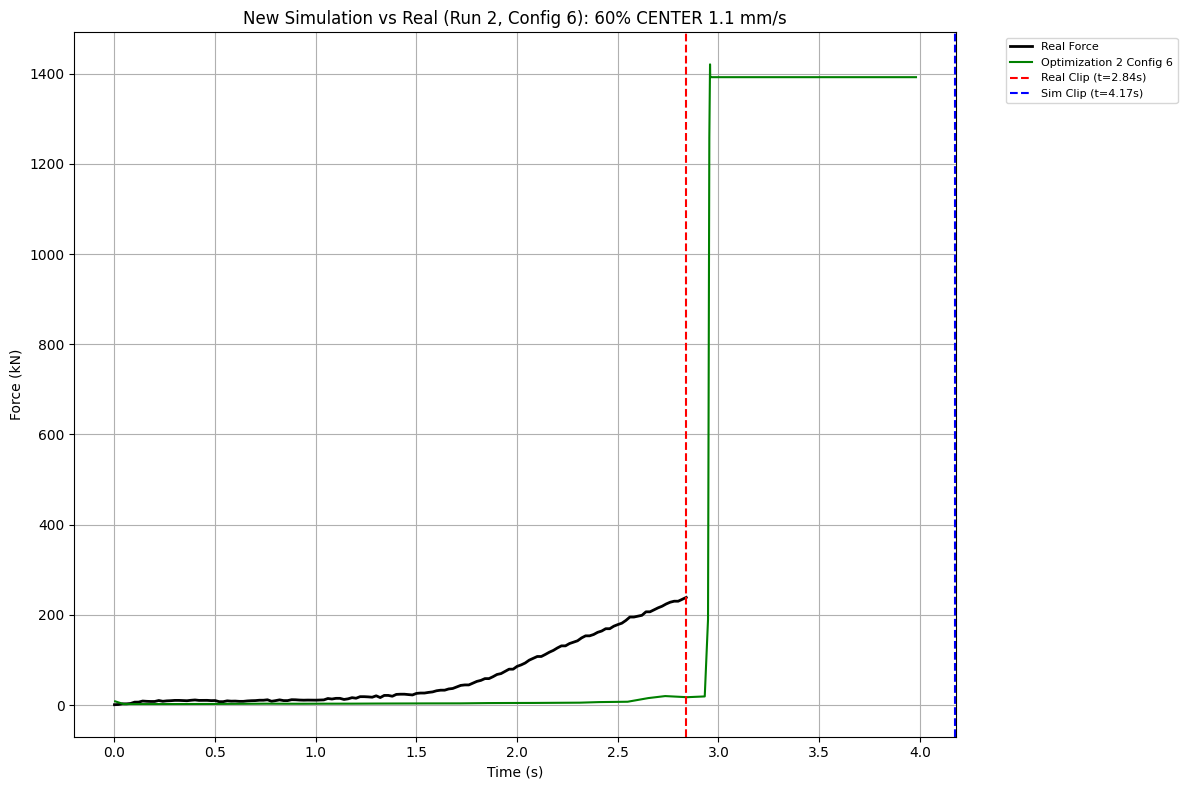

Saved XML to H:\XMLFiles\80BAR_03\optimization_2_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


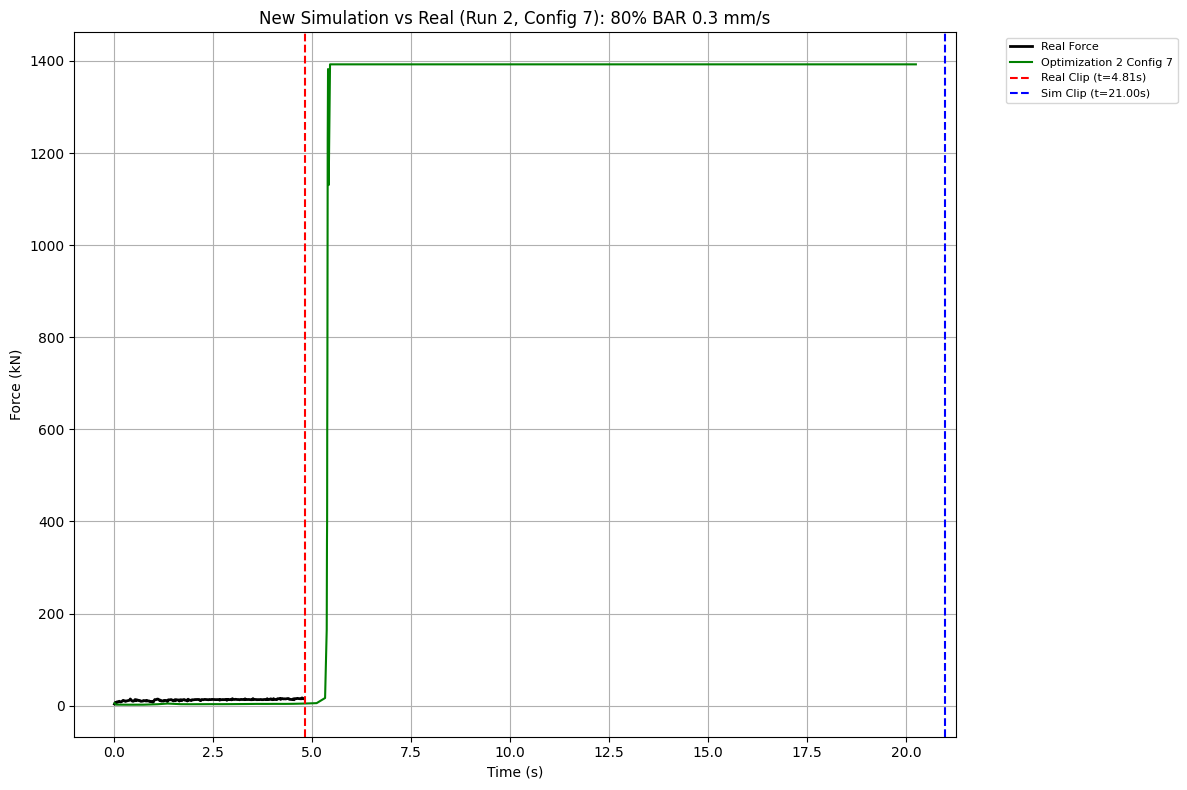

Saved XML to H:\XMLFiles\80BAR_07\optimization_2_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


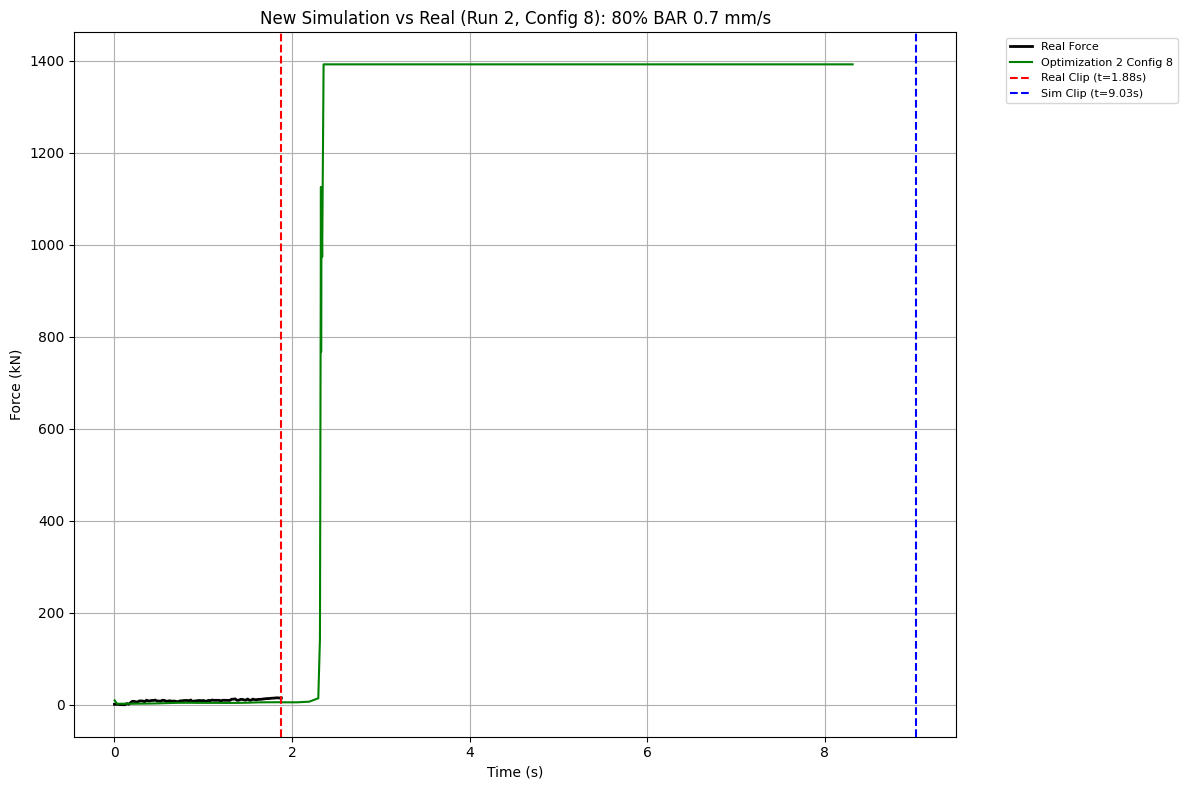

Saved XML to H:\XMLFiles\80BAR_11\optimization_2_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


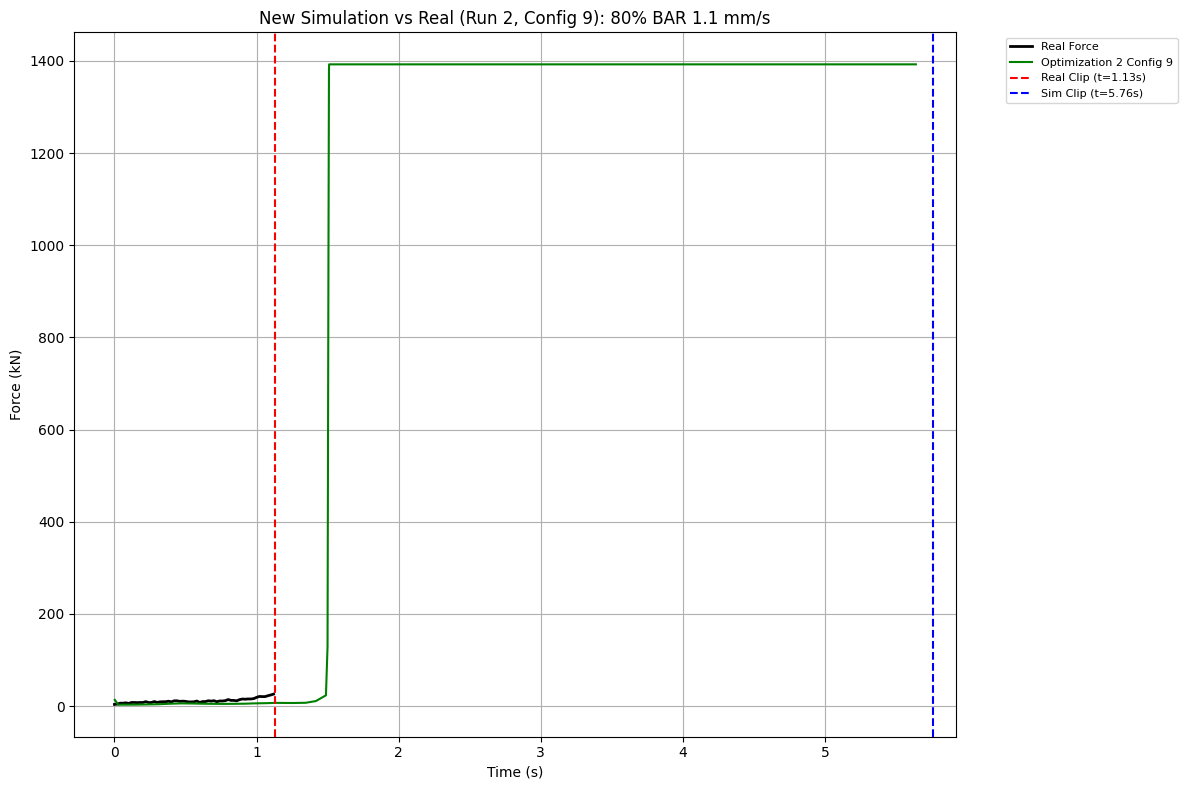


Optimization Run 3/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 3 [n, tau_star, B, tau_w, m]:
tensor([[5.9752e-01, 1.0236e+03, 6.9380e+03, 6.0658e-01, 1.9000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_3_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


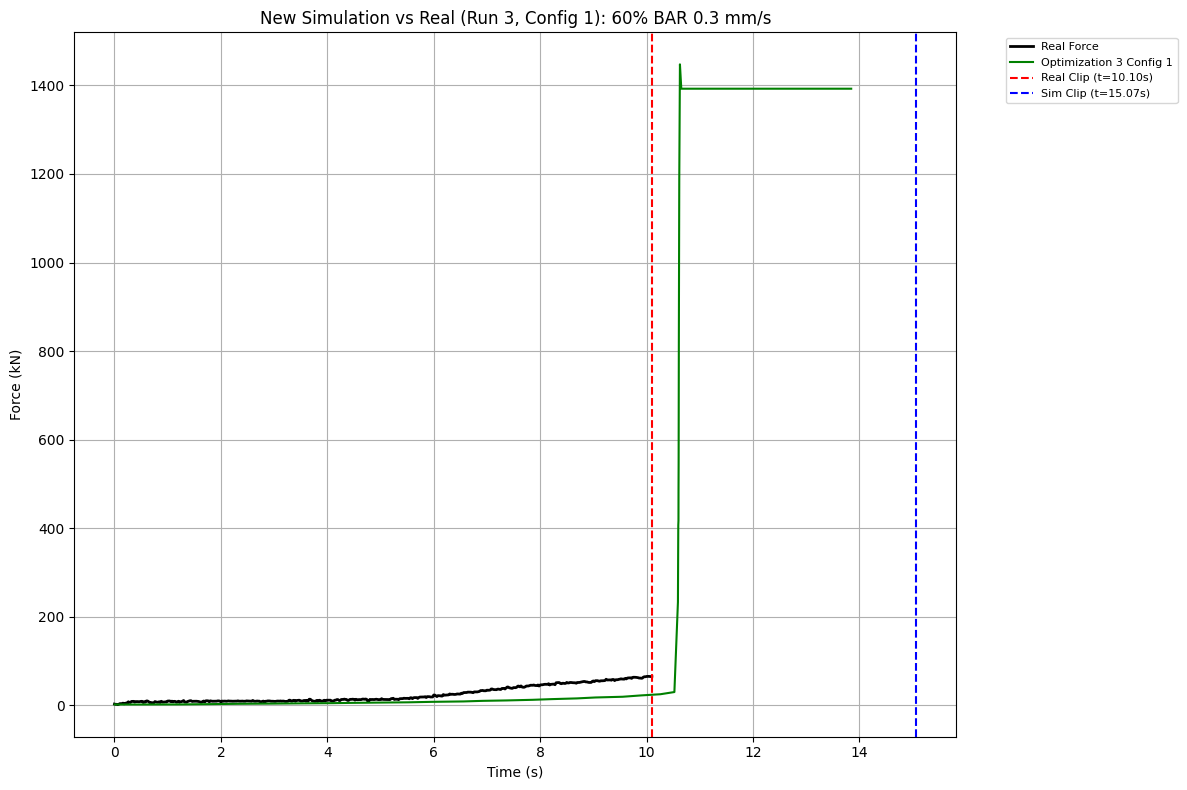

Saved XML to H:\XMLFiles\60BAR_07\optimization_3_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


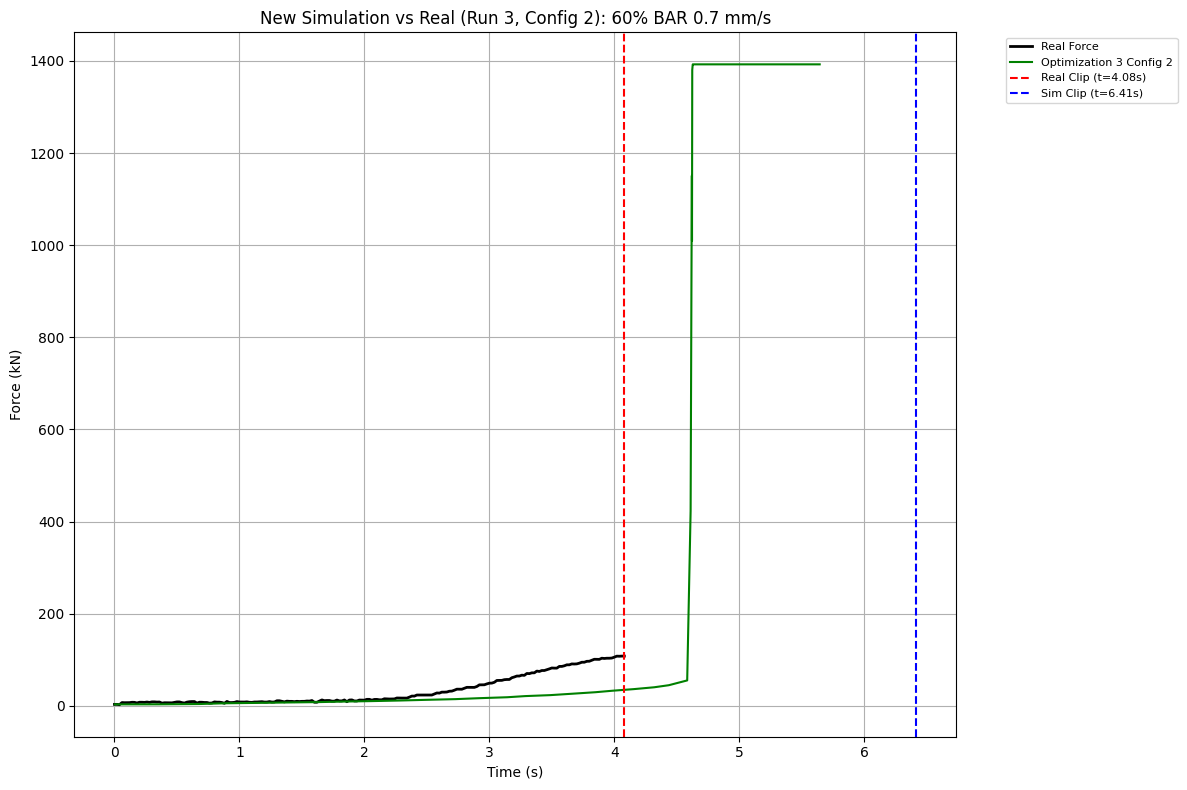

Saved XML to H:\XMLFiles\60BAR_11\optimization_3_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


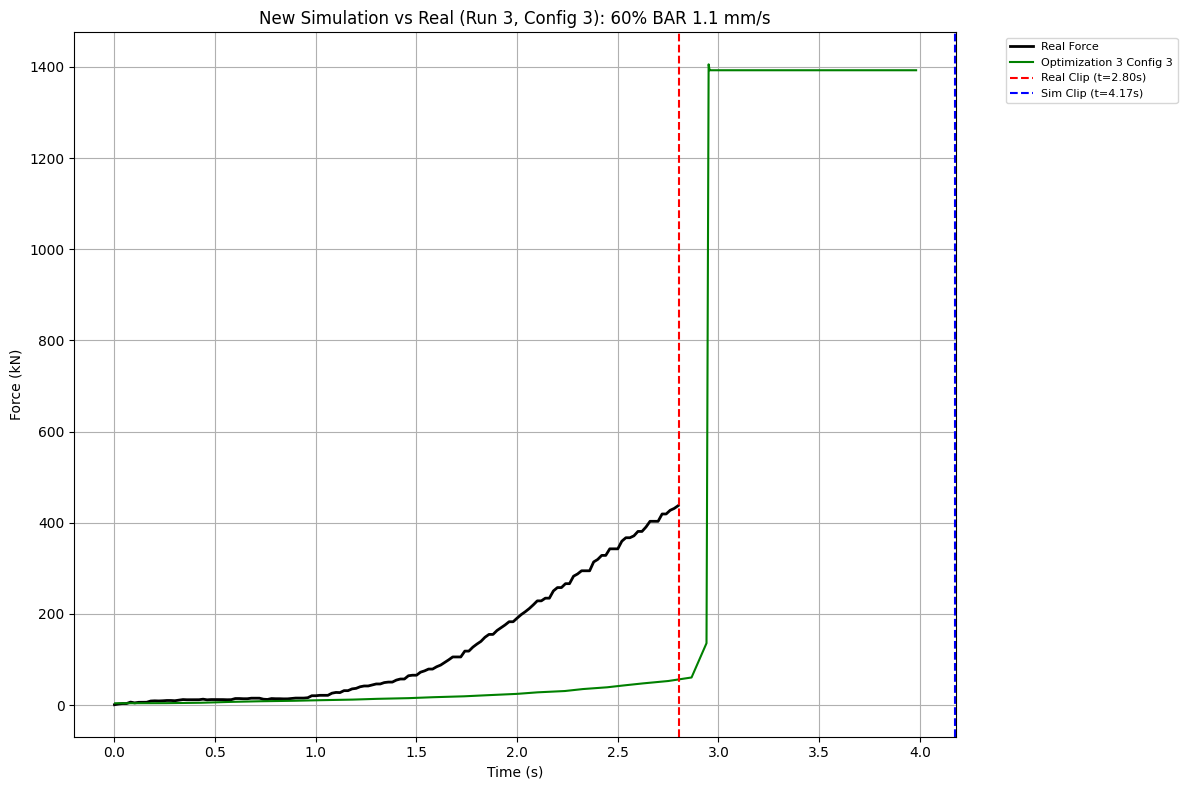

Saved XML to H:\XMLFiles\60CENTER_03\optimization_3_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


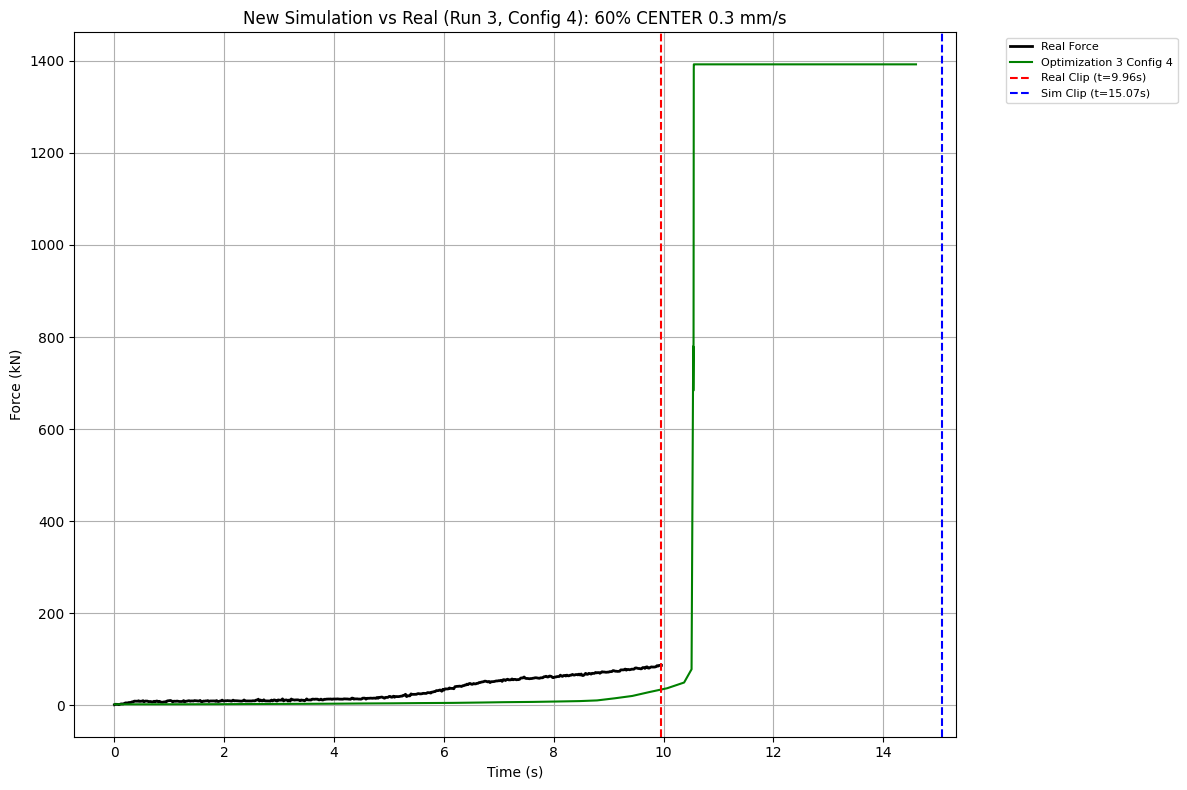

Saved XML to H:\XMLFiles\60CENTER_07\optimization_3_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


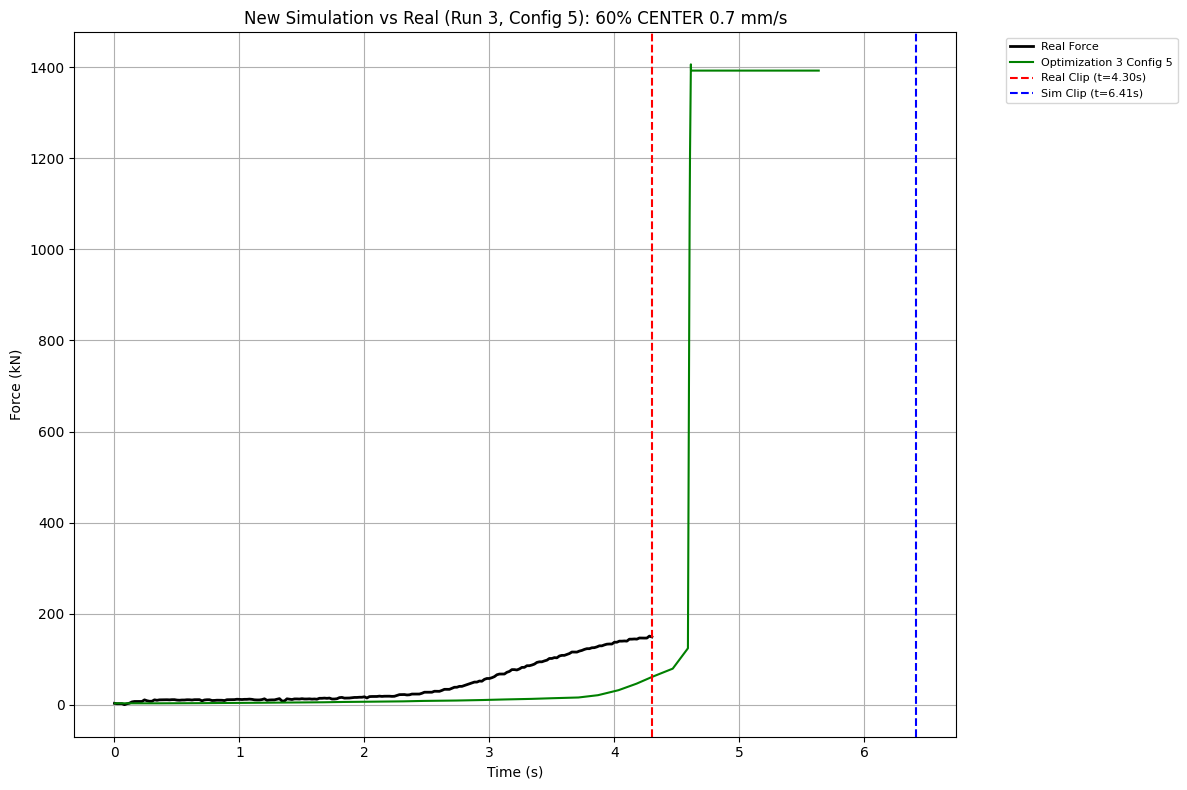

Saved XML to H:\XMLFiles\60CENTER_11\optimization_3_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


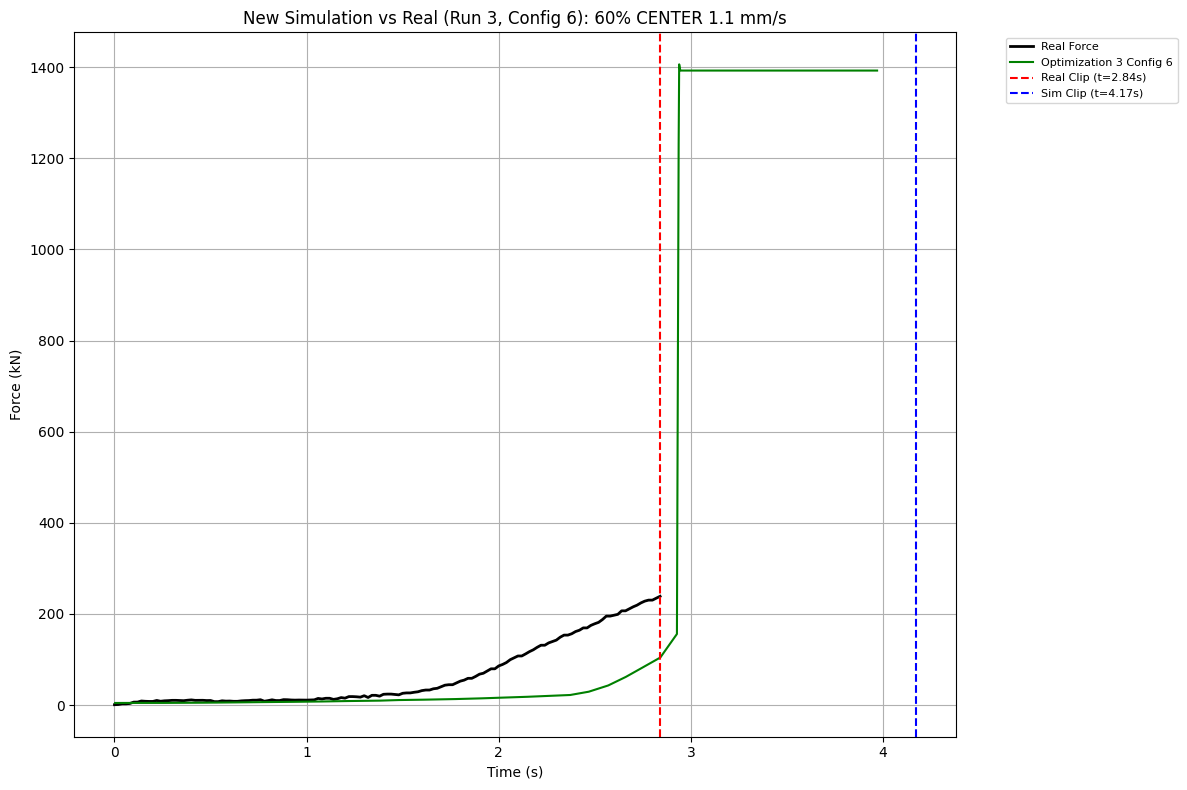

Saved XML to H:\XMLFiles\80BAR_03\optimization_3_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


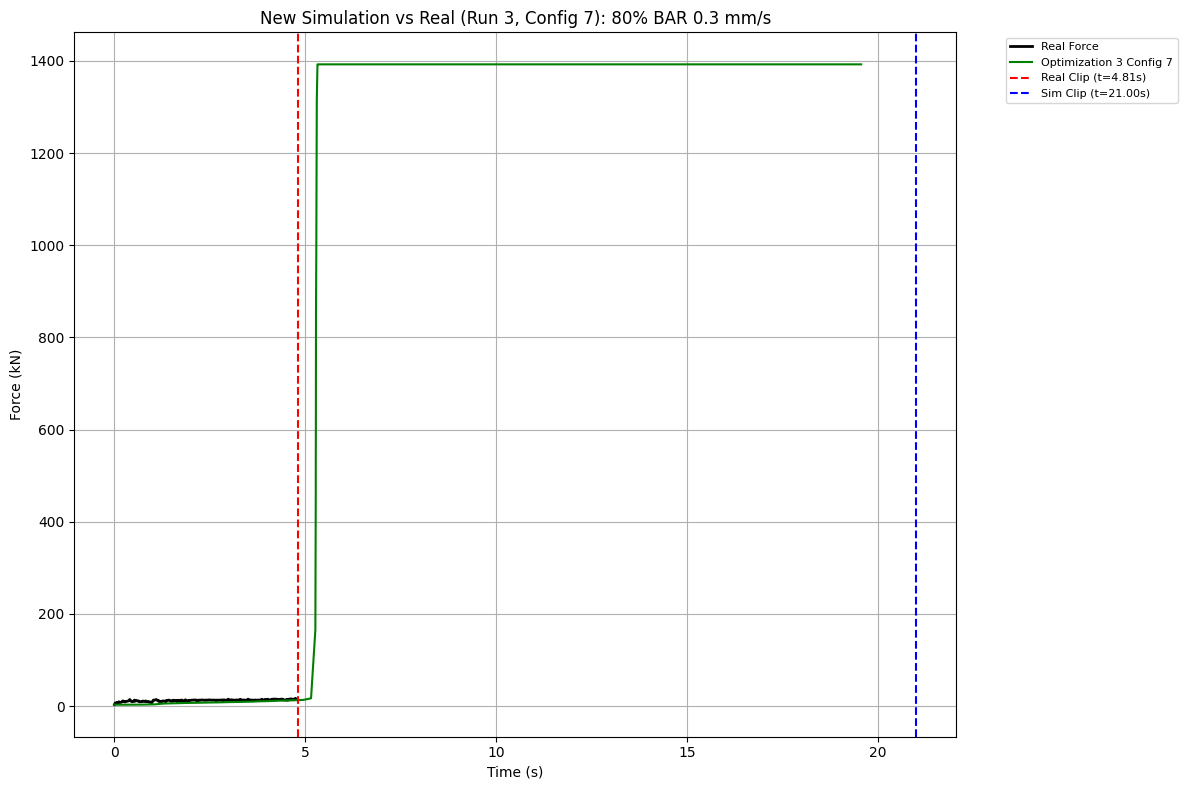

Saved XML to H:\XMLFiles\80BAR_07\optimization_3_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


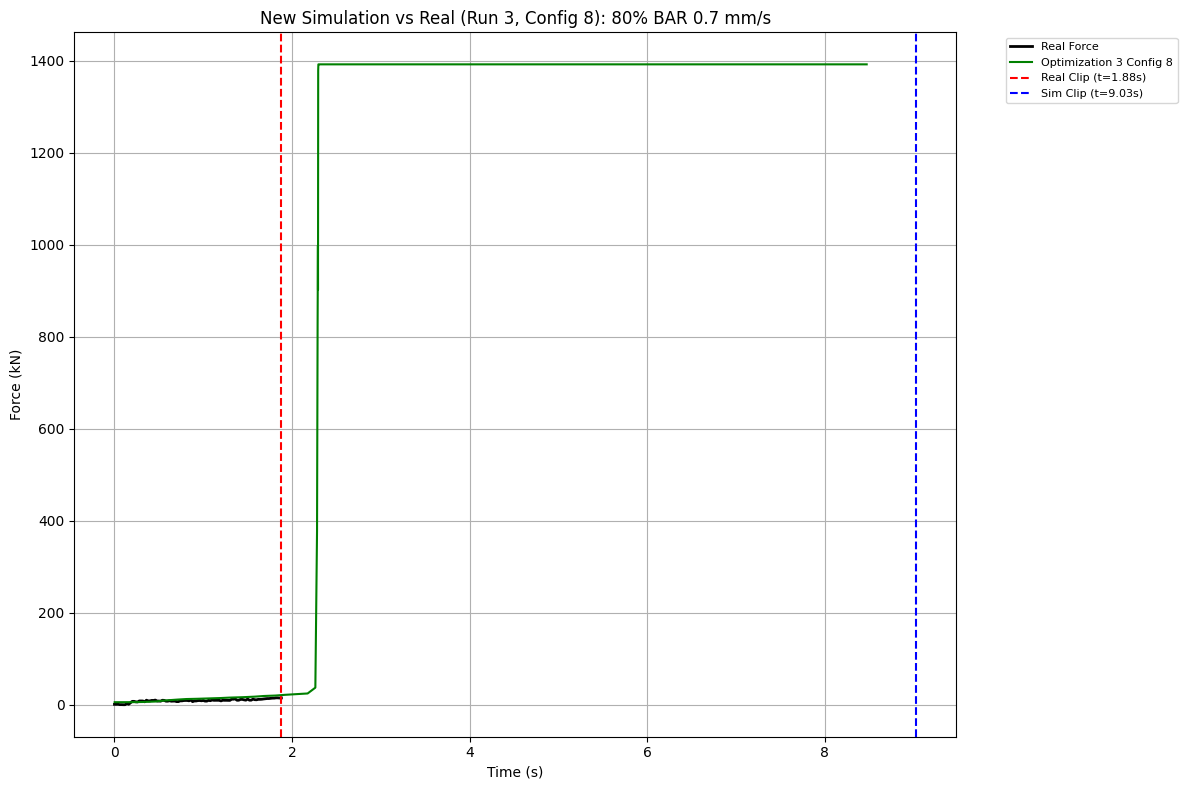

Saved XML to H:\XMLFiles\80BAR_11\optimization_3_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


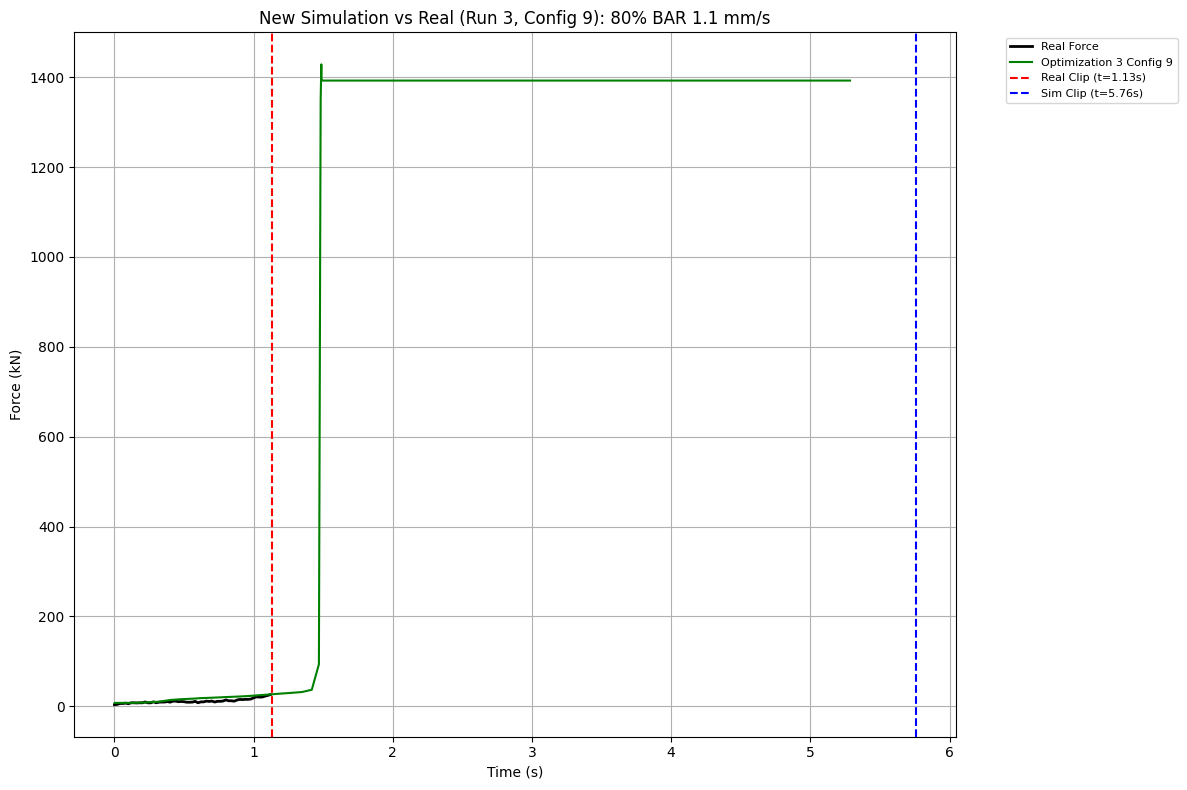


Optimization Run 4/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 4 [n, tau_star, B, tau_w, m]:
tensor([[6.0000e-01, 4.2972e+03, 6.0188e+04, 1.3495e-01, 1.9000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_4_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


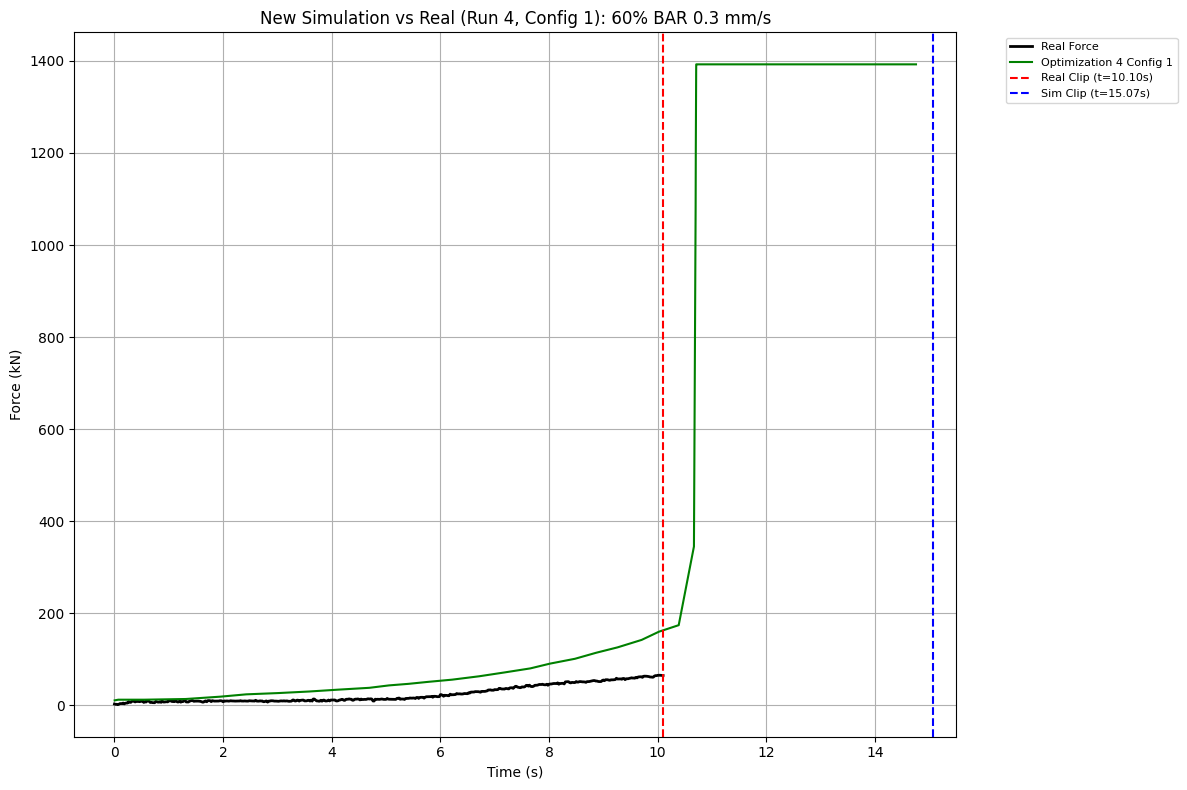

Saved XML to H:\XMLFiles\60BAR_07\optimization_4_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


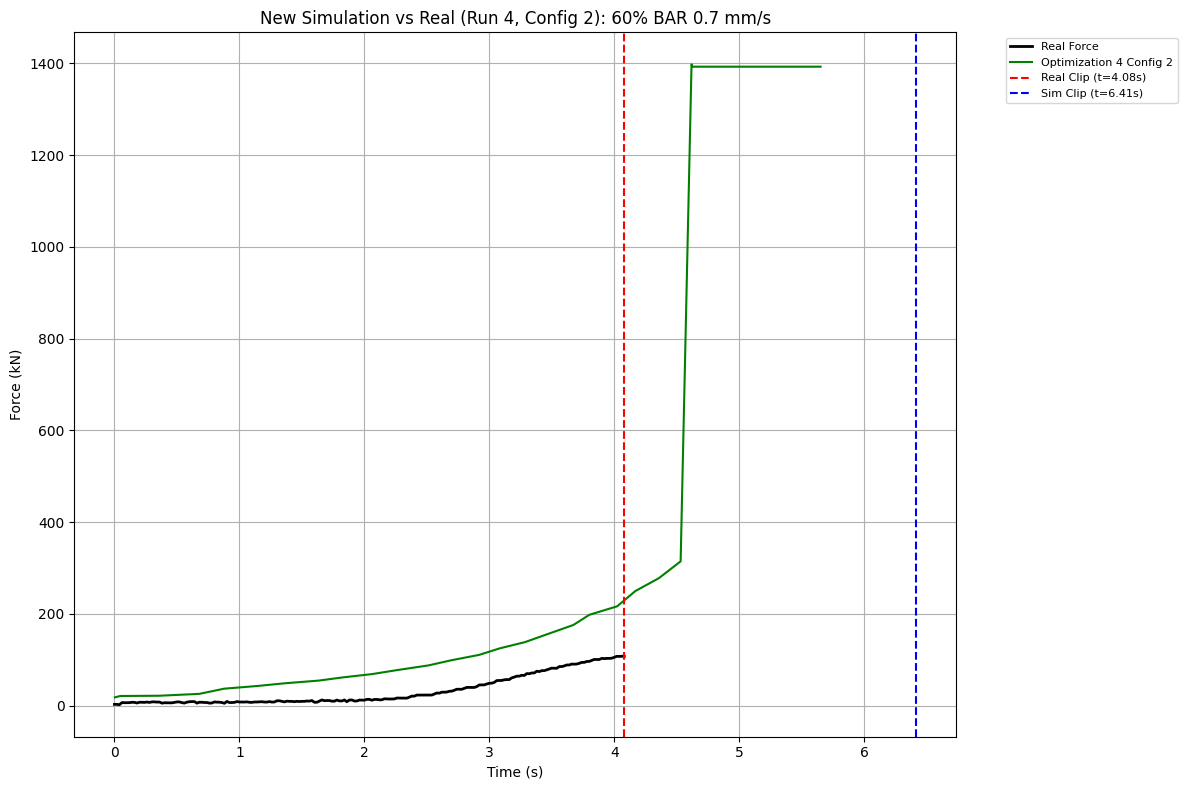

Saved XML to H:\XMLFiles\60BAR_11\optimization_4_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


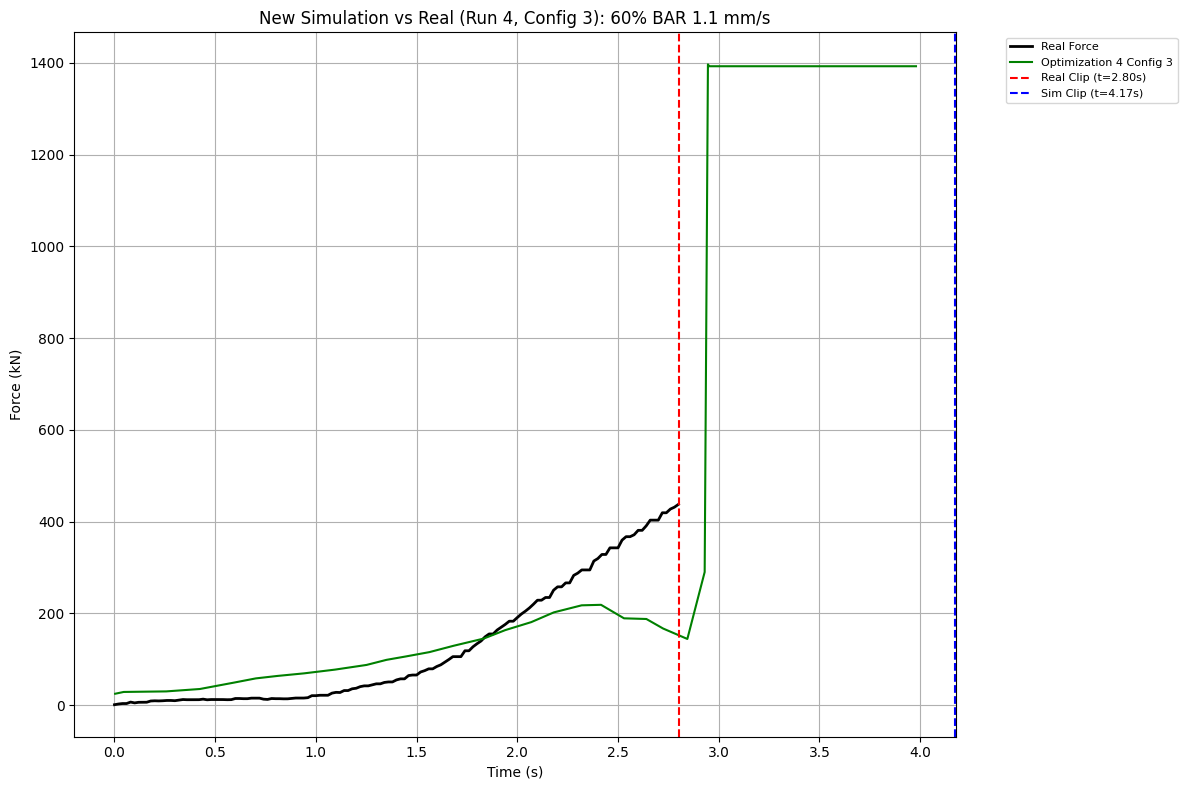

Saved XML to H:\XMLFiles\60CENTER_03\optimization_4_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


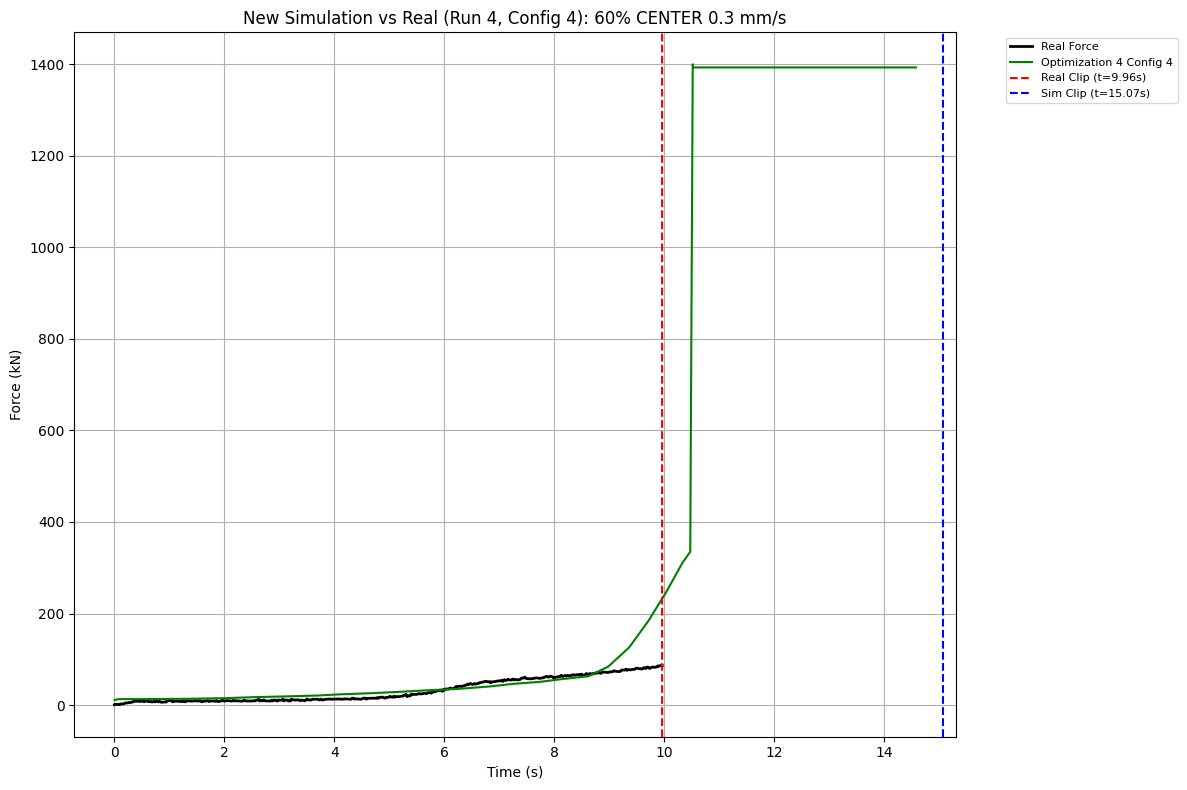

Saved XML to H:\XMLFiles\60CENTER_07\optimization_4_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


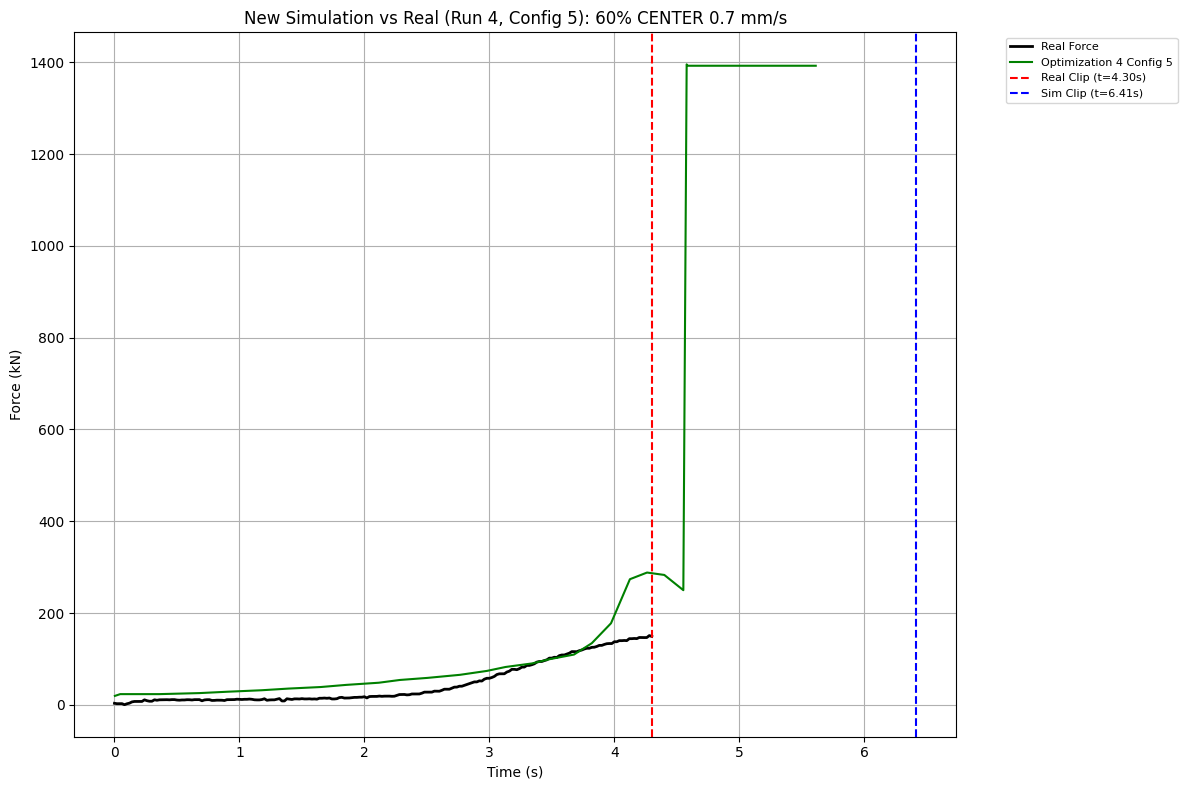

Saved XML to H:\XMLFiles\60CENTER_11\optimization_4_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


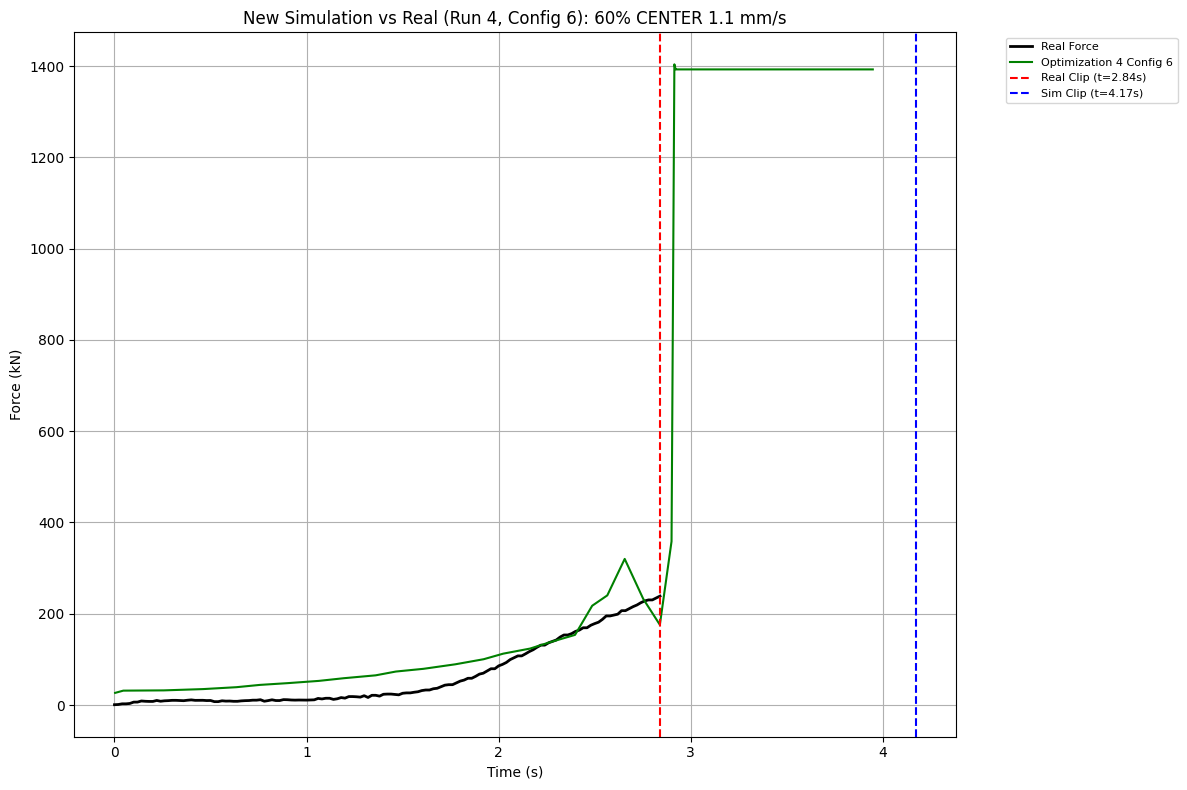

Saved XML to H:\XMLFiles\80BAR_03\optimization_4_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


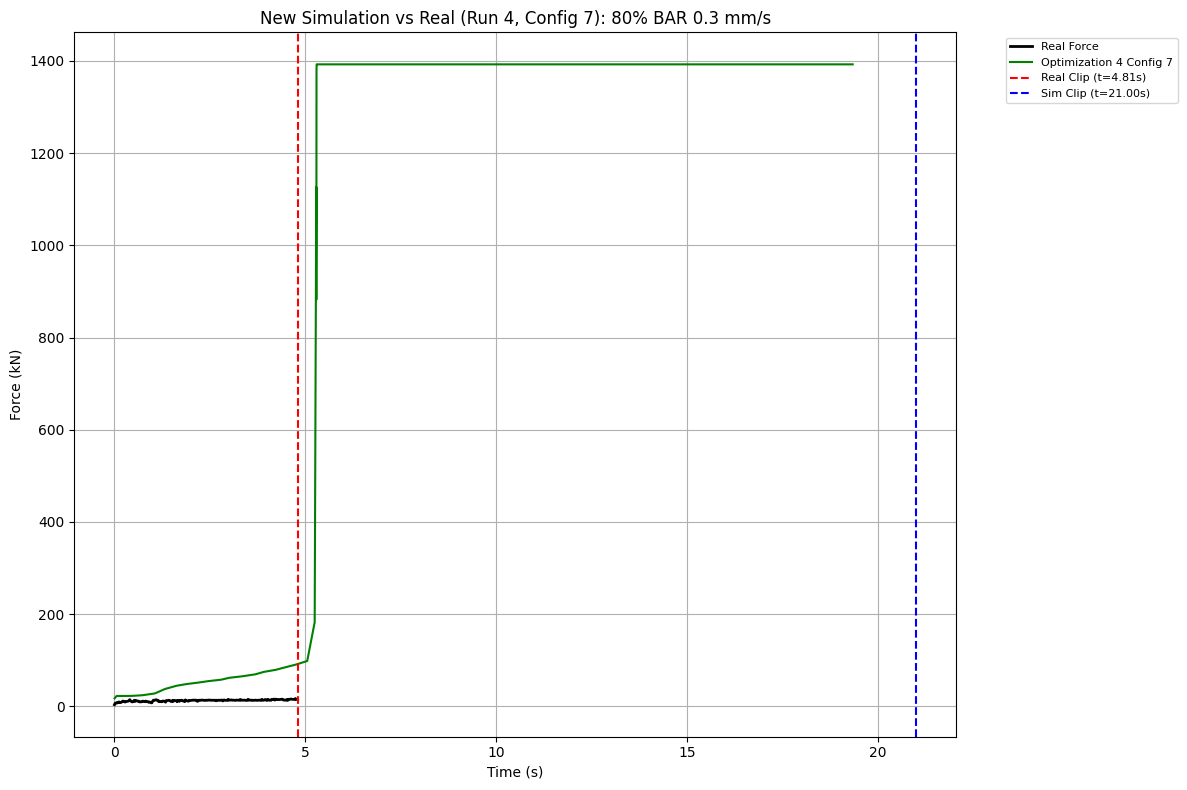

Saved XML to H:\XMLFiles\80BAR_07\optimization_4_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


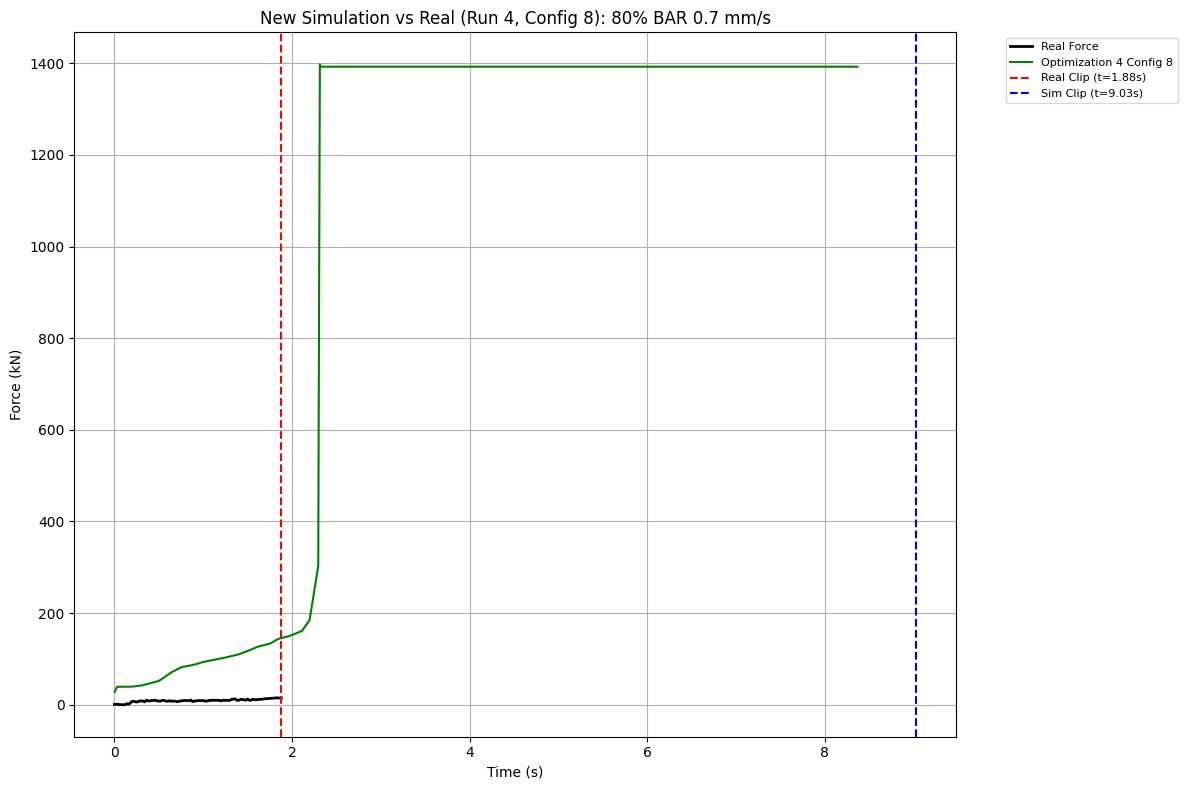

Saved XML to H:\XMLFiles\80BAR_11\optimization_4_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


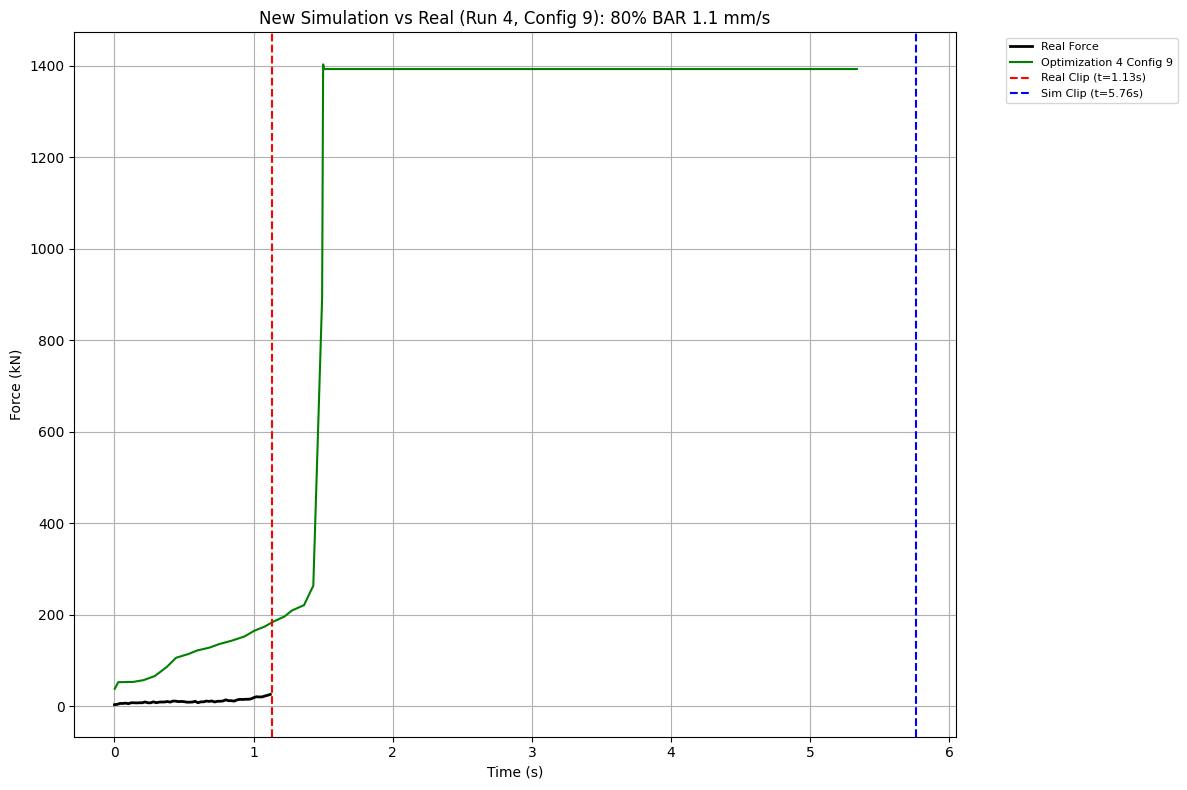


Optimization Run 5/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 5 [n, tau_star, B, tau_w, m]:
tensor([[2.0000e-01, 8.7359e+04, 9.7435e+04, 5.0000e-03, 1.0000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_5_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


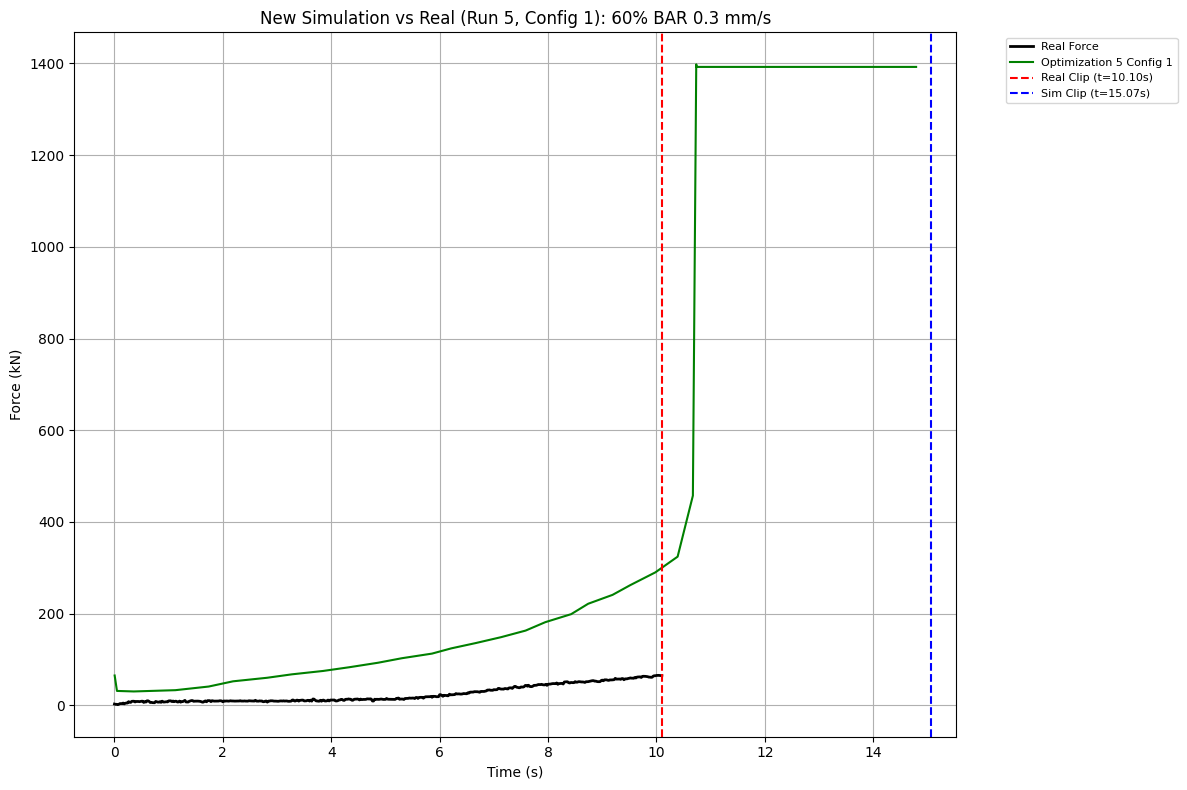

Saved XML to H:\XMLFiles\60BAR_07\optimization_5_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


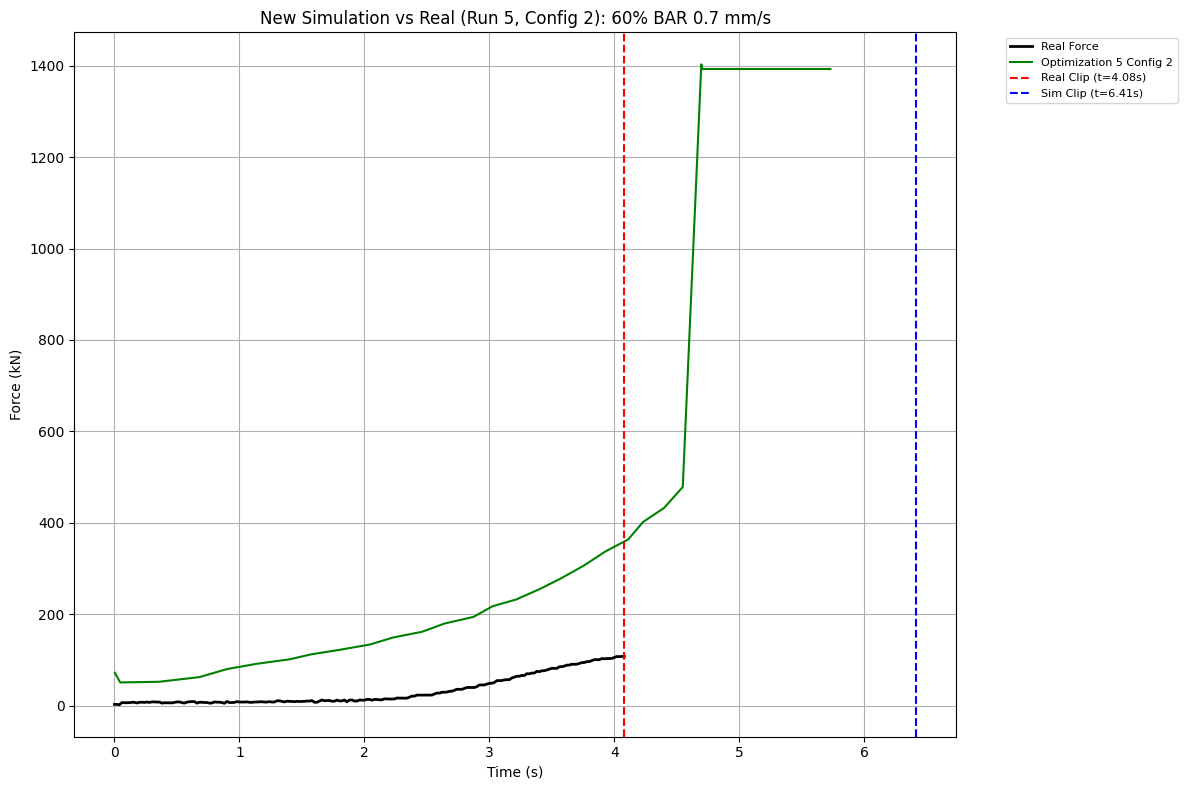

Saved XML to H:\XMLFiles\60BAR_11\optimization_5_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


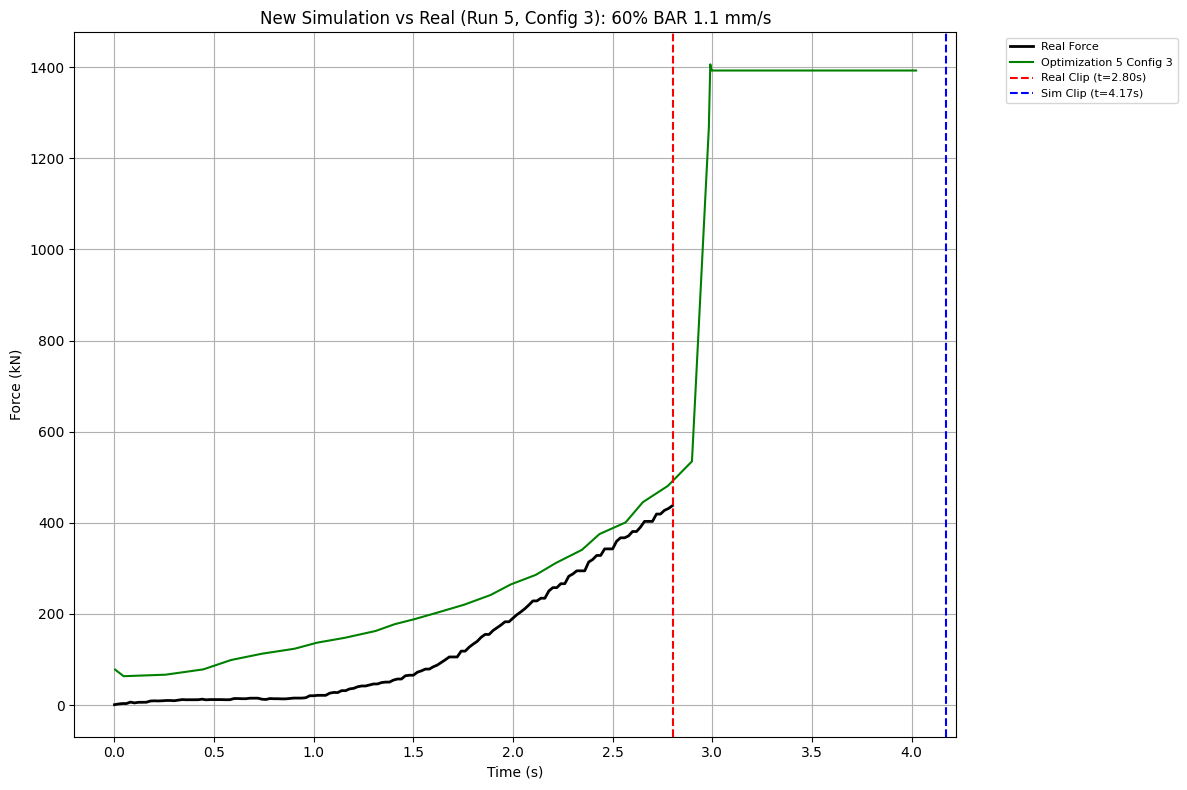

Saved XML to H:\XMLFiles\60CENTER_03\optimization_5_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


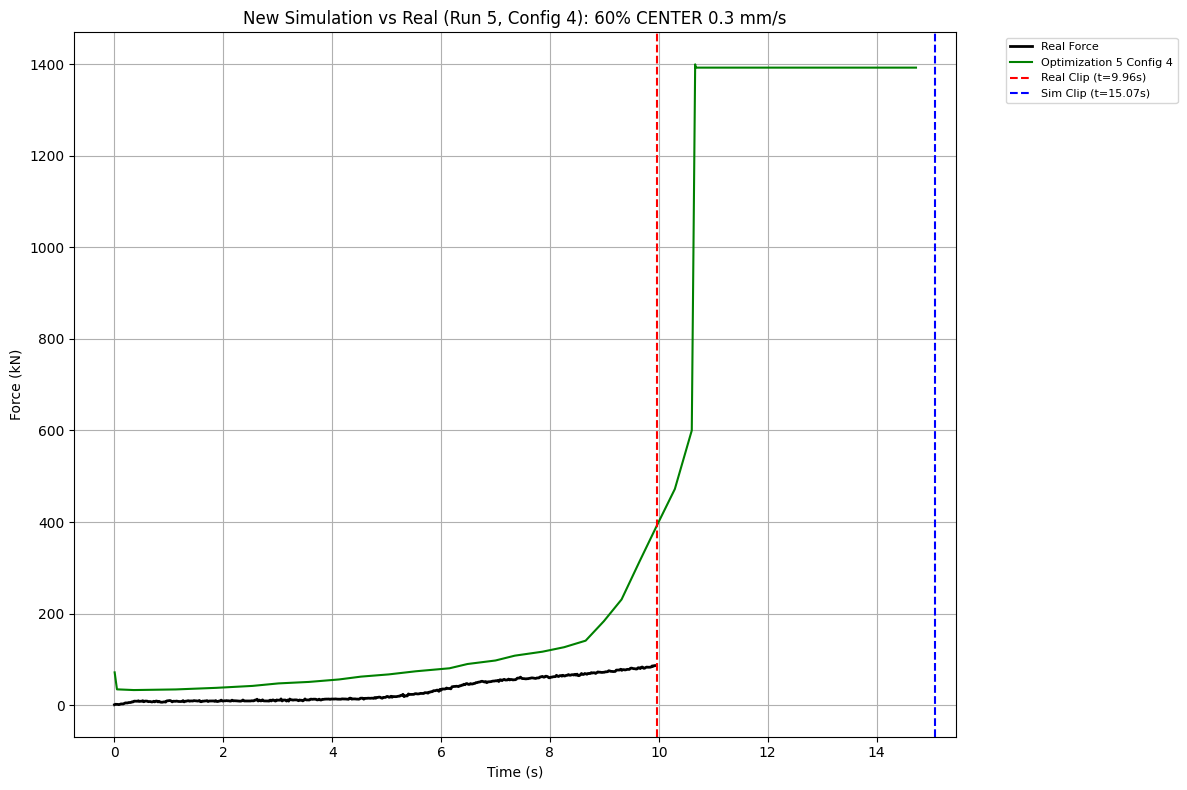

Saved XML to H:\XMLFiles\60CENTER_07\optimization_5_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


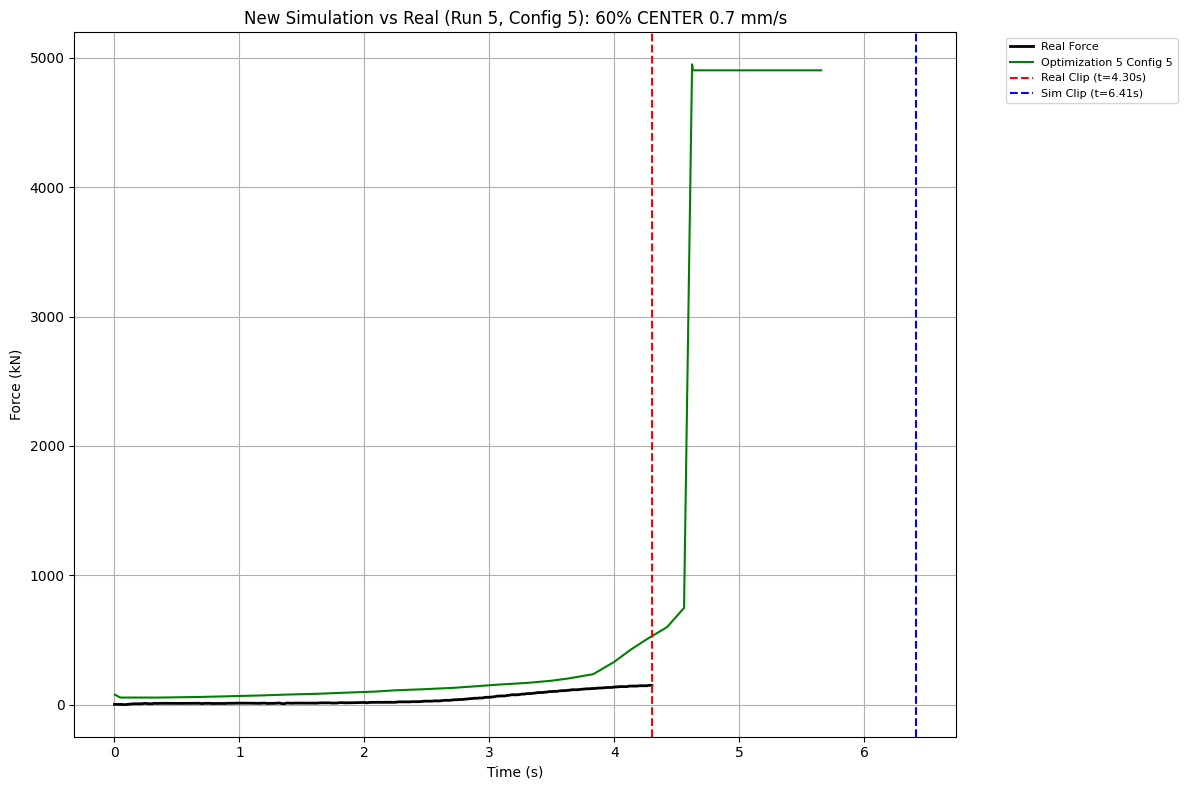

Saved XML to H:\XMLFiles\60CENTER_11\optimization_5_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


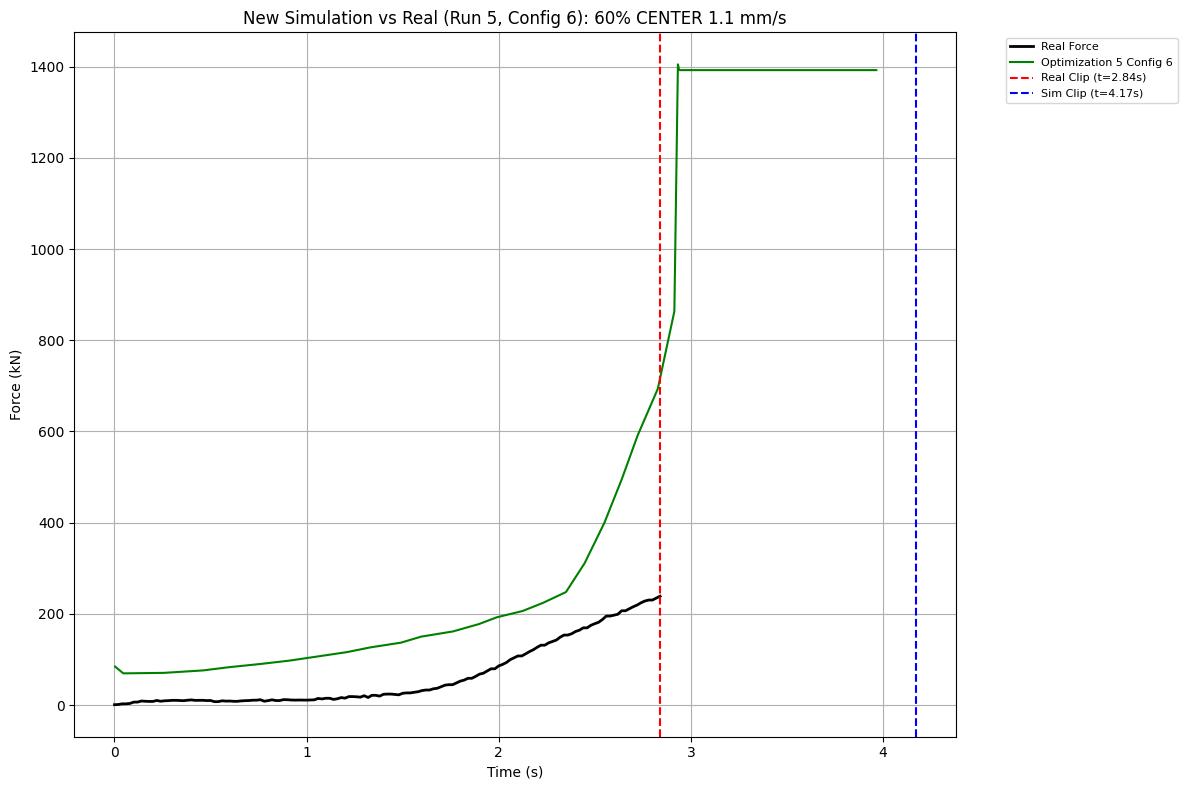

Saved XML to H:\XMLFiles\80BAR_03\optimization_5_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


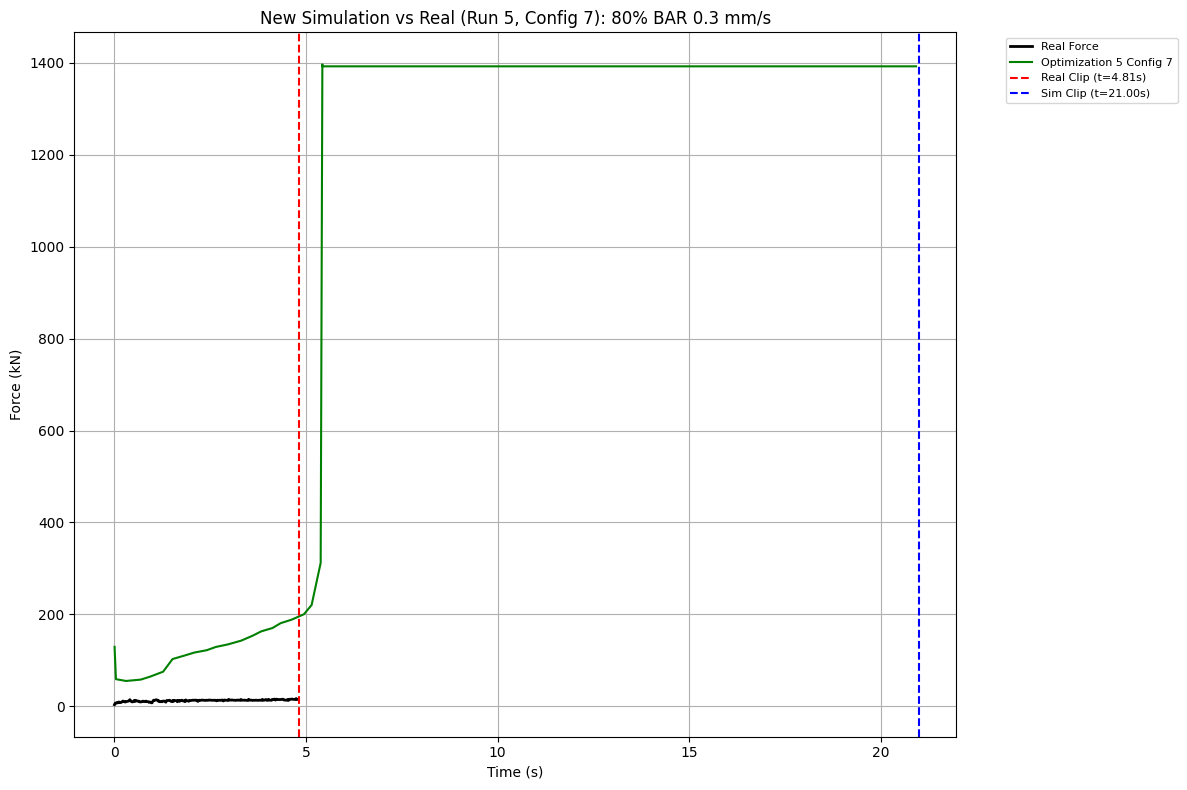

Saved XML to H:\XMLFiles\80BAR_07\optimization_5_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


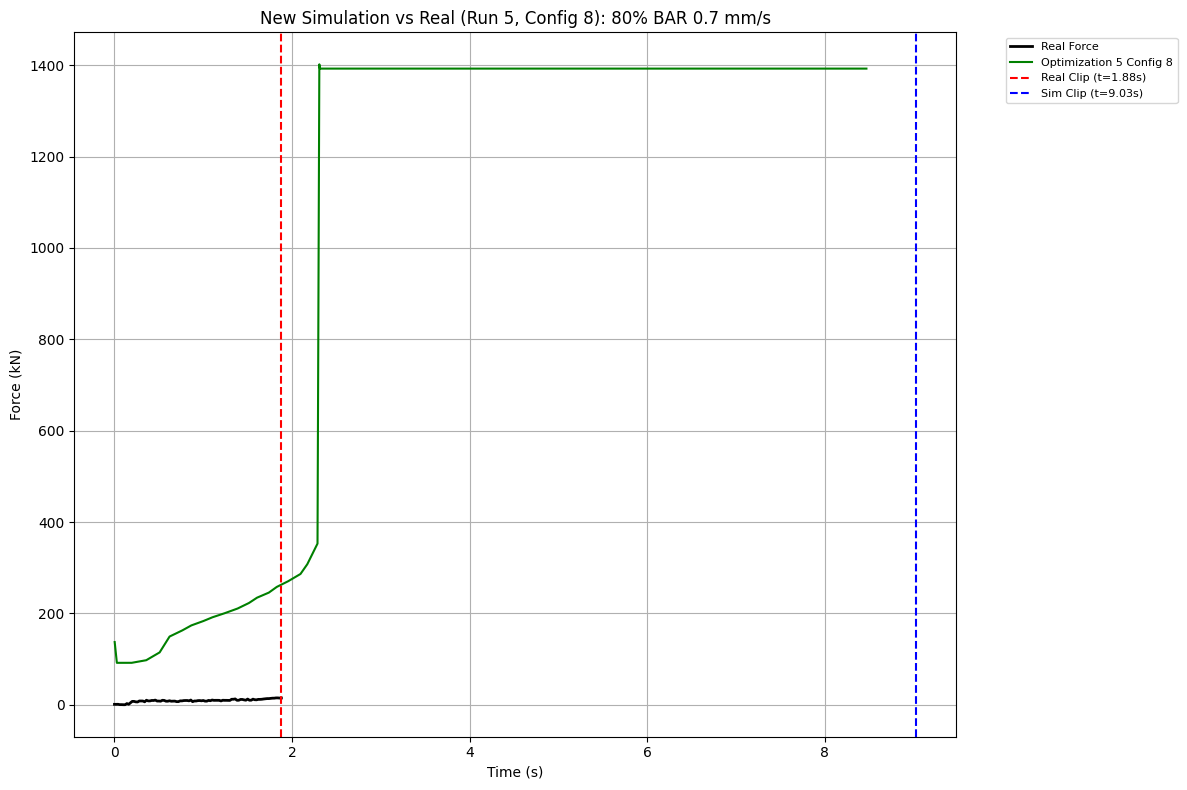

Saved XML to H:\XMLFiles\80BAR_11\optimization_5_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


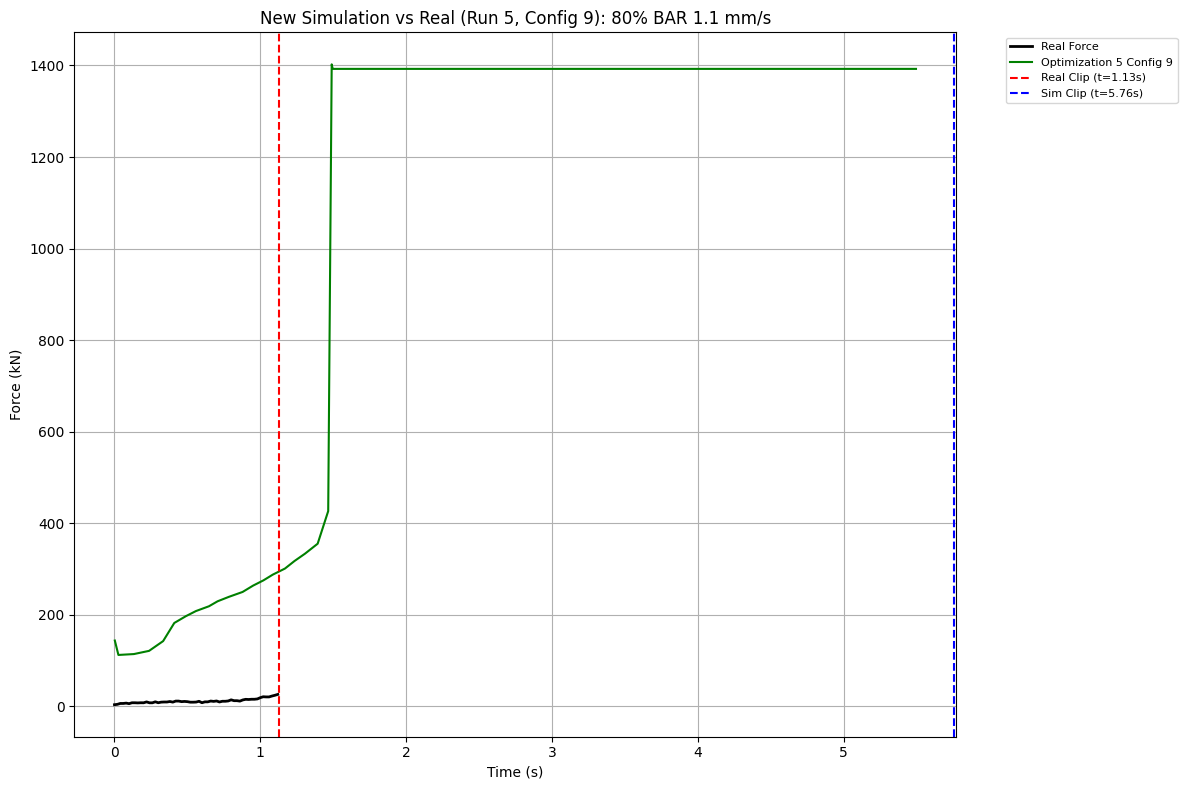


Optimization Run 6/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 6 [n, tau_star, B, tau_w, m]:
tensor([[4.0159e-01, 6.5466e+04, 1.8624e+03, 1.0000e+00, 1.0000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_6_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


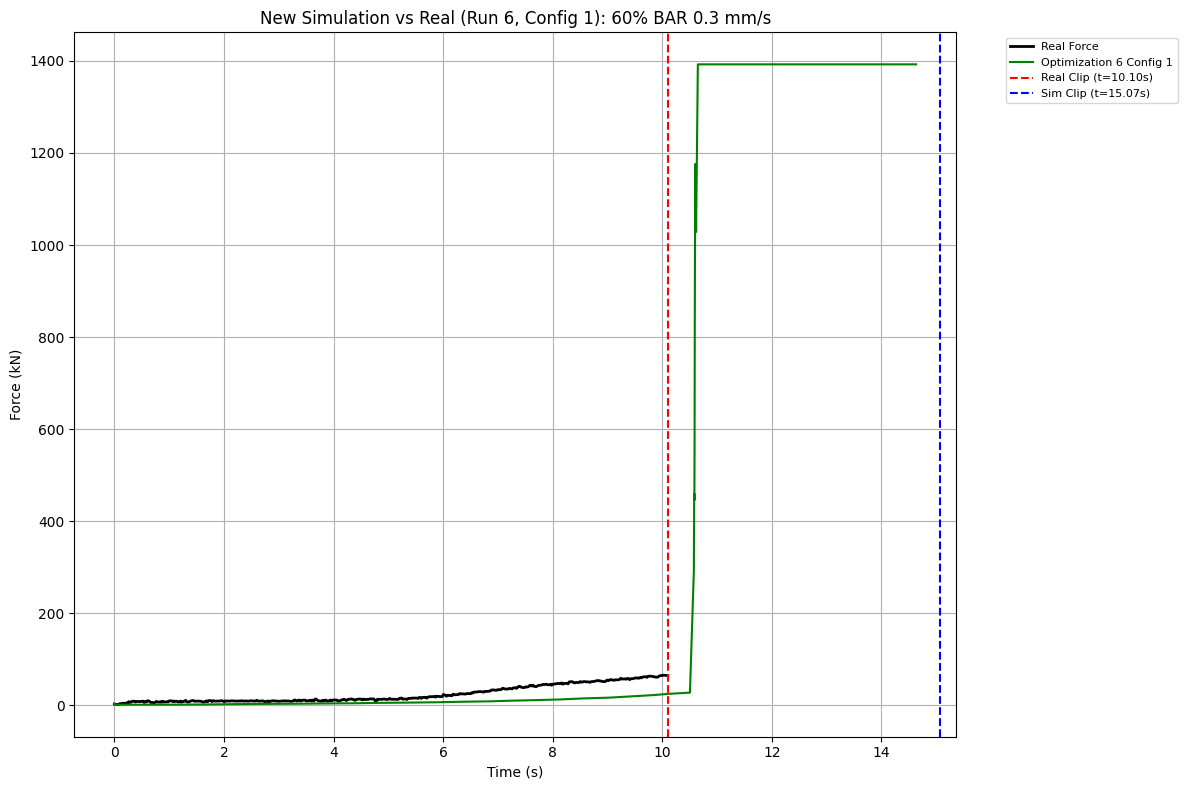

Saved XML to H:\XMLFiles\60BAR_07\optimization_6_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


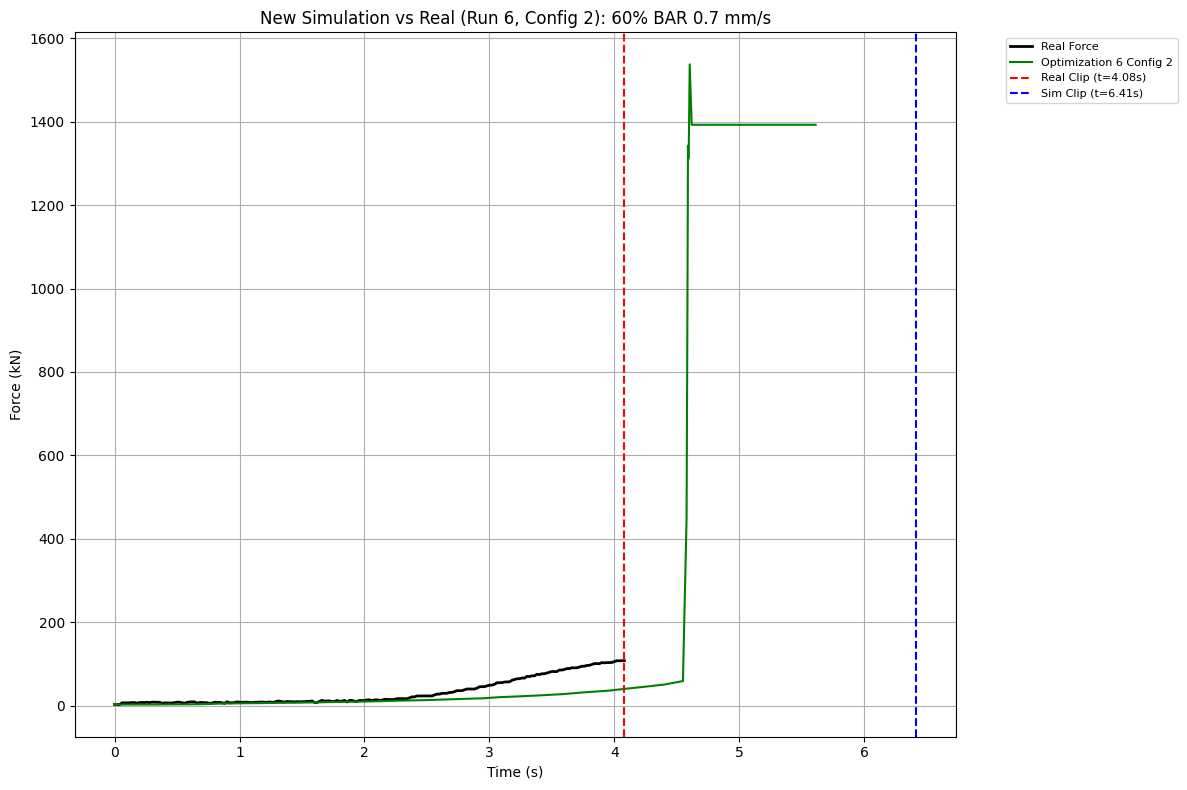

Saved XML to H:\XMLFiles\60BAR_11\optimization_6_3.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,115,116,117,145,146,147,151,152,153,157,158,159,160,161,162,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


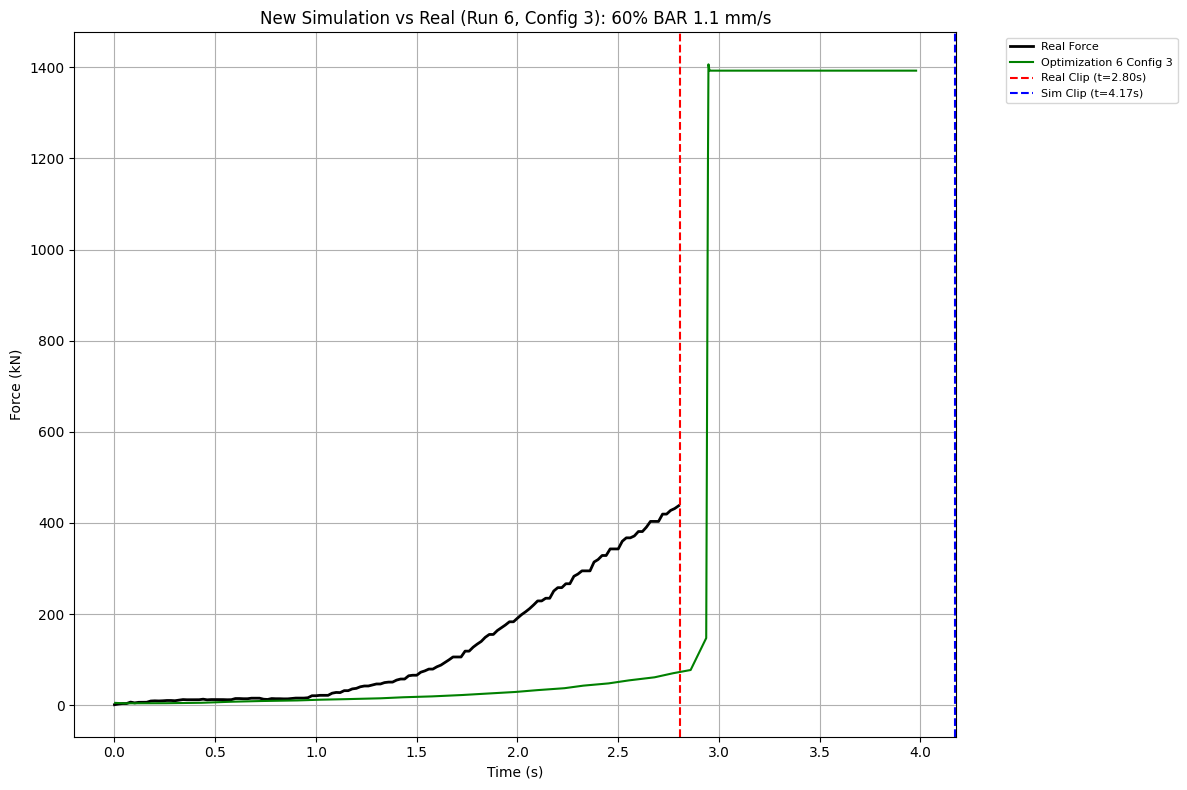

Saved XML to H:\XMLFiles\60CENTER_03\optimization_6_4.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,103,104,105,109,110,111,118,119,120,133,134,135,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


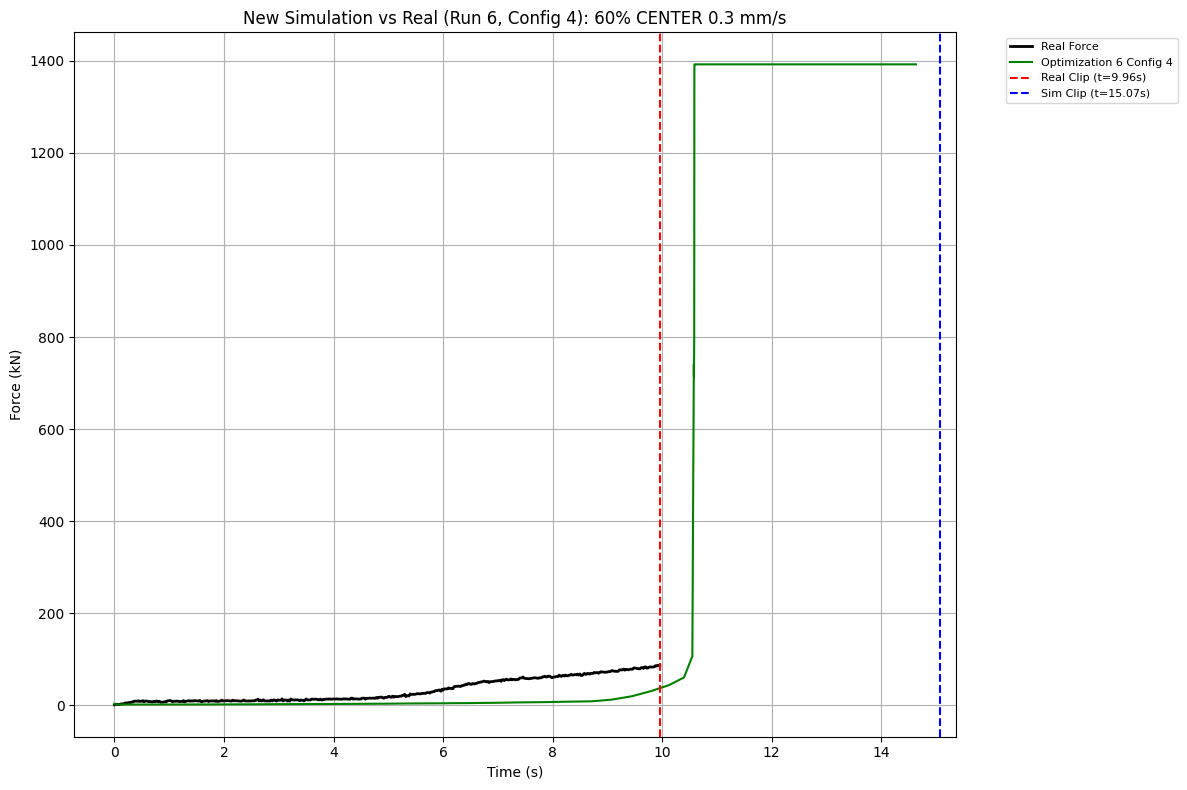

Saved XML to H:\XMLFiles\60CENTER_07\optimization_6_5.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


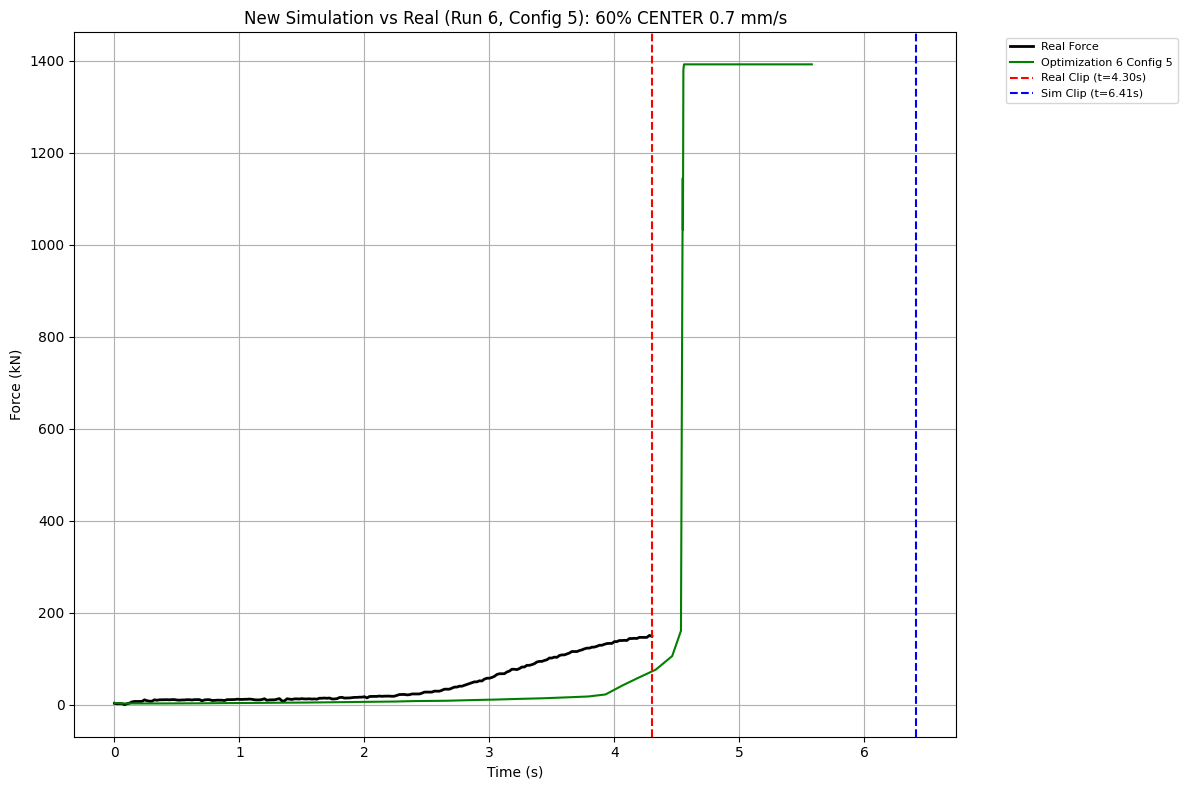

Saved XML to H:\XMLFiles\60CENTER_11\optimization_6_6.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,88,89,90,91,92,93,94,95,96,121,122,123,127,128,129,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


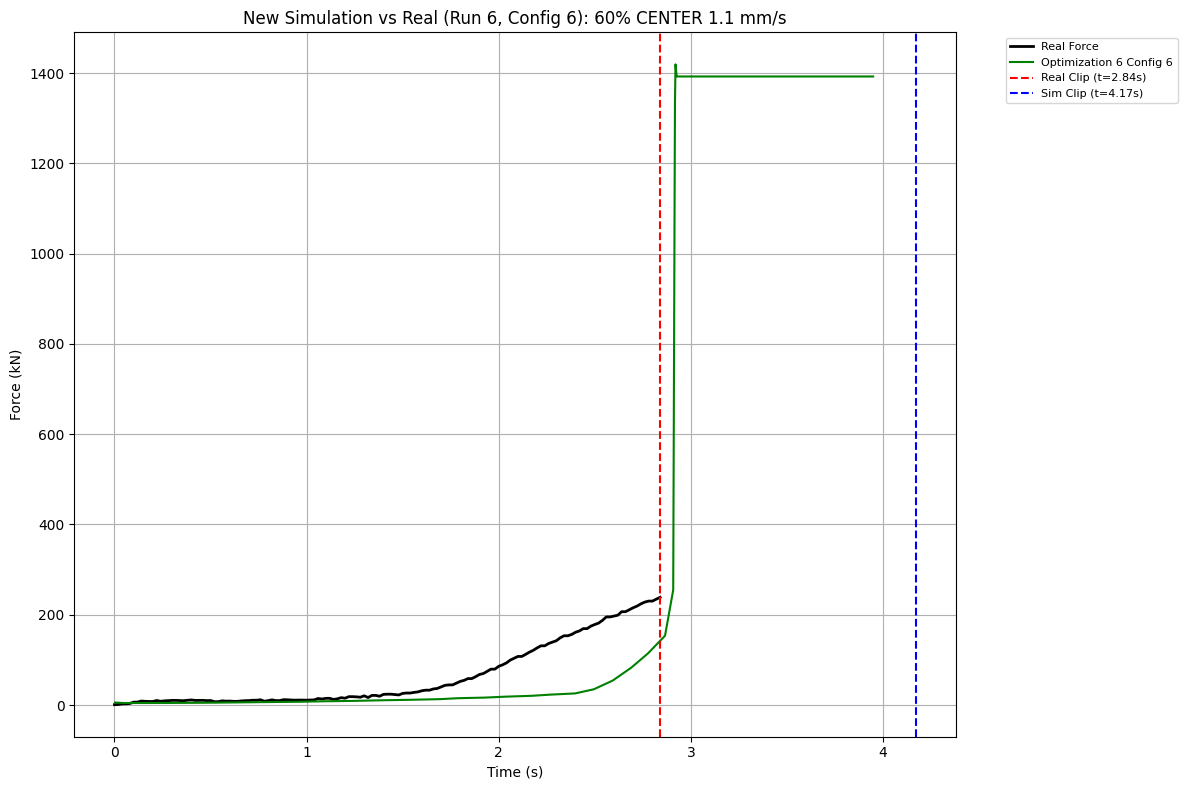

Saved XML to H:\XMLFiles\80BAR_03\optimization_6_7.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


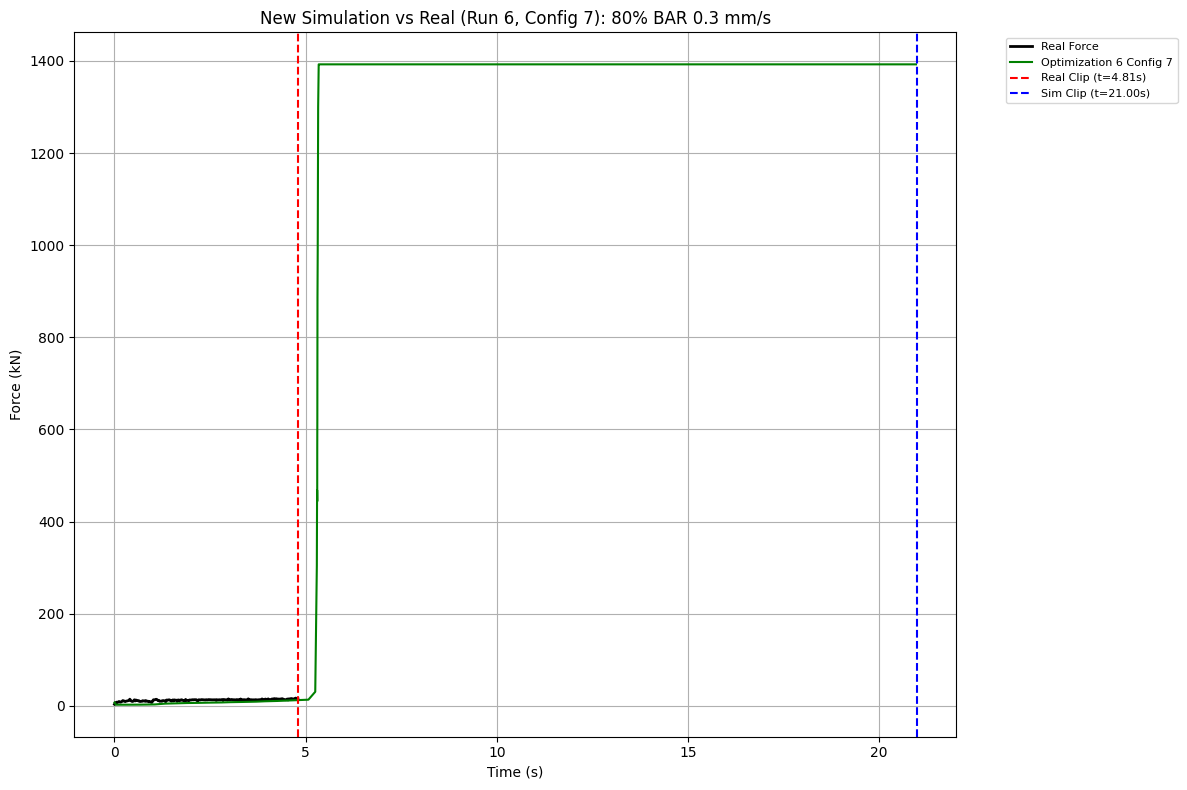

Saved XML to H:\XMLFiles\80BAR_07\optimization_6_8.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,130,131,132,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


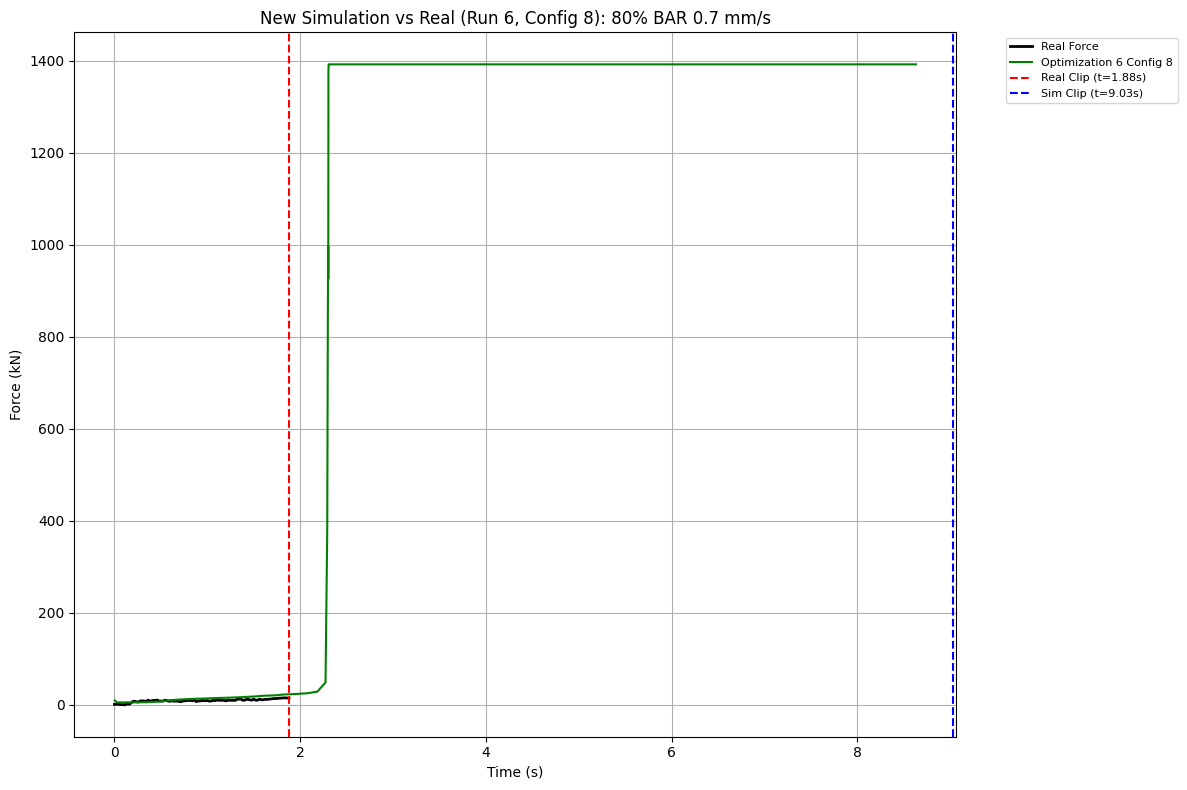

Saved XML to H:\XMLFiles\80BAR_11\optimization_6_9.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,52,53,54,82,83,84,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,121,122,123,124,125,126,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,184,185,186,187,188,189,190,191,192,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


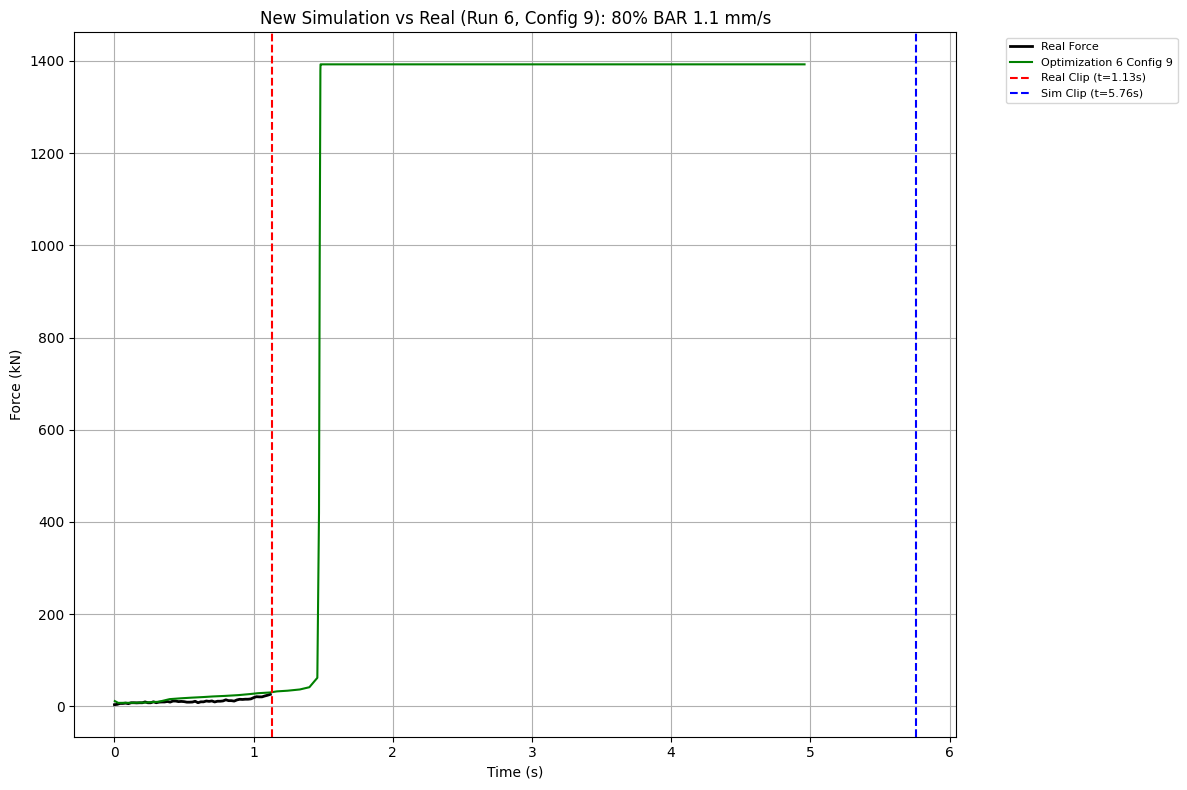


Optimization Run 7/15


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Optimized parameters for run 7 [n, tau_star, B, tau_w, m]:
tensor([[2.0000e-01, 3.7662e+04, 3.9247e+04, 5.0000e-03, 1.0000e+00]])
Saved XML to H:\XMLFiles\60BAR_03\optimization_7_1.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,127,128,129,139,140,141,142,143,144,145,146,147,151,152,153,154,155,156,157,158,159,163,164,165,169,170,171,175,176,177,181,182,183,187,188,189,190,191,192,214,215,216,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


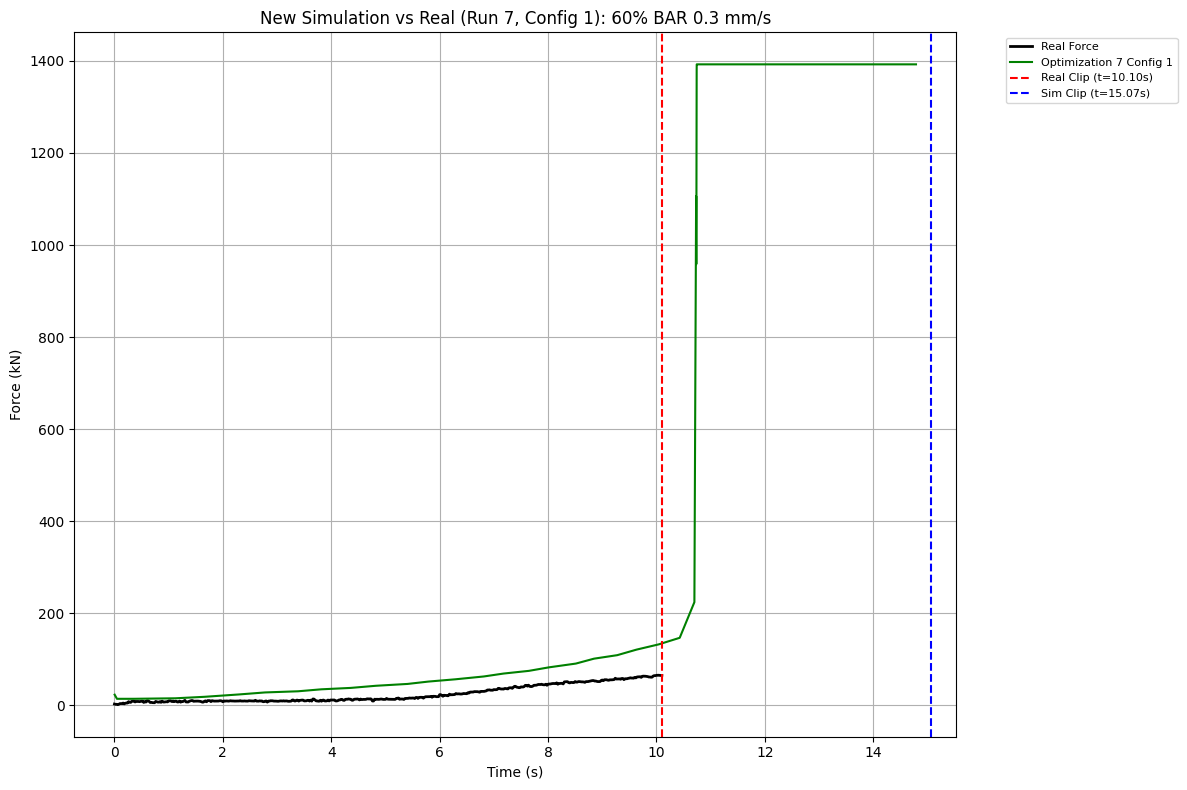

Saved XML to H:\XMLFiles\60BAR_07\optimization_7_2.xml


C:\Users\sozenosk\AppData\Local\Temp\ipykernel_38368\2990434044.py:159: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,82,83,84,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,118,119,120,133,134,135,136,137,138,145,146,147,151,152,153,157,158,159,163,164,165,166,167,168,169,170,171,175,176,177,181,182,183,187,188,189,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


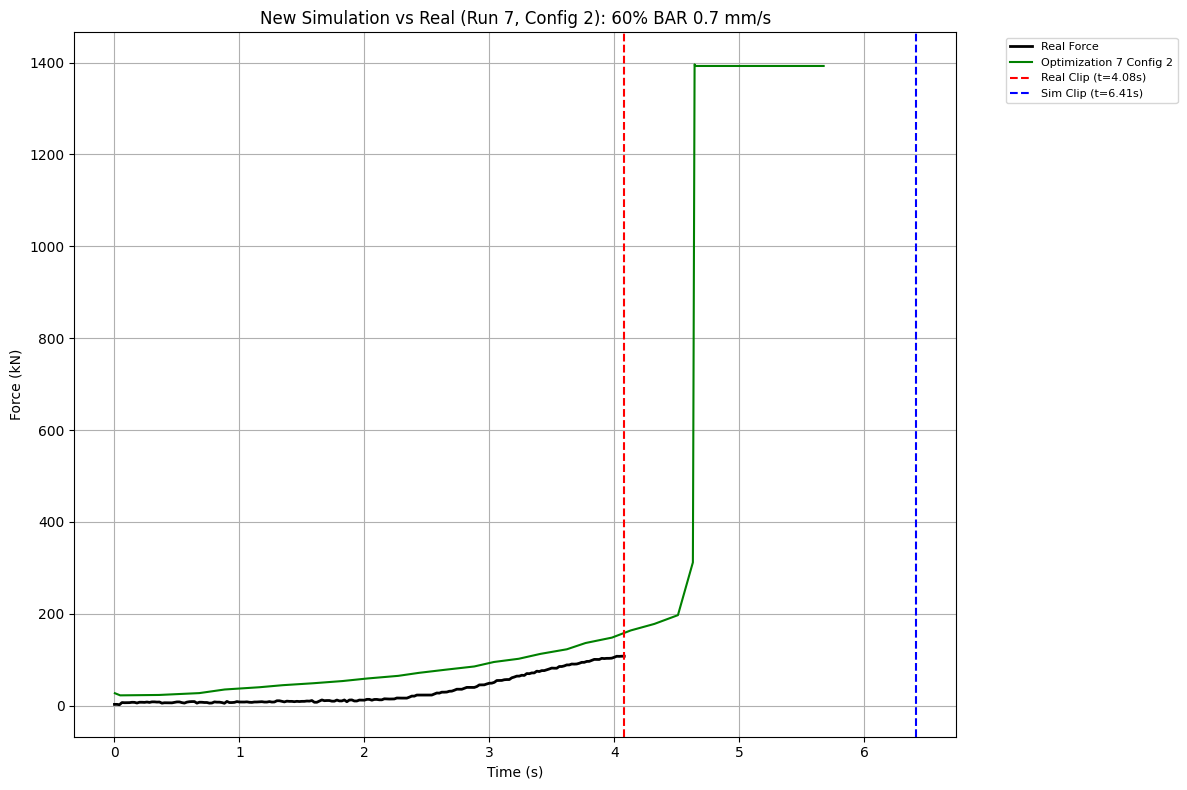

In [ ]:
# Study names for each configuration index
study_names = {
    0: "60BAR_4.70_03_study",
    1: "60BAR_4.70_07_study",
    2: "60BAR_4.70_11_study",
    3: "60CENTER_4.70_03_study",
    4: "60CENTER_4.70_07_study",
    5: "60CENTER_4.70_11_study",
    6: "80BAR_4.70_03_study",
    7: "80BAR_4.70_07_study",
    8: "80BAR_4.70_11_study"
}

# Clipping values for each configuration (in seconds)
clipping_values = {
    0: 0.6,  # 60% BAR 0.3 mm/s
    1: 0.3,  # 60% BAR 0.7 mm/s
    2: 0.1,  # 60% BAR 1.1 mm/s
    3: 0.6,  # 60% CENTER 0.3 mm/s
    4: 0.3,  # 60% CENTER 0.7 mm/s
    5: 0.1,  # 60% CENTER 1.1 mm/s
    6: 0.3,  # 80% BAR 0.3 mm/s
    7: 0.1,  # 80% BAR 0.7 mm/s
    8: 0.05   # 80% BAR 1.1 mm/s
}

# File info and custom groups (unchanged)
file_info = [
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar03mms388g.txt",
        "force_start": "31.07.2025 10:39:06.150461",
        "force_end": "31.07.2025 10:39:24.070461",
        "pos_start": "31.07.2025 10:39:24.070461",
        "pos_end": "31.07.2025 10:42:34.610461"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar07mms384g.txt",
        "force_start": "31.07.2025 10:18:27.193997",
        "force_end": "31.07.2025 10:18:35.113997",
        "pos_start": "31.07.2025 10:18:35.113997",
        "pos_end": "31.07.2025 10:20:44.573997"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKBAR150bar11mms414g.txt",
        "force_start": "30.07.2025 13:43:44.197899",
        "force_end": "30.07.2025 13:43:49.057899",
        "pos_start": "30.07.2025 13:43:49.057899",
        "pos_end": "30.07.2025 13:46:49.957899"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar03mms396g.txt",
        "force_start": "29.07.2025 15:27:01.321079",
        "force_end": "29.07.2025 15:27:19.181079",
        "pos_start": "29.07.2025 15:27:19.181079",
        "pos_end": "29.07.2025 15:30:46.881079"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar07mms398g.txt",
        "force_start": "30.07.2025 12:19:49.167098",
        "force_end": "30.07.2025 12:19:57.487098",
        "pos_start": "30.07.2025 12:19:57.487098",
        "pos_end": "30.07.2025 12:21:55.287098"
    },
    {
        "path": "H:\\DLR Press Data\\60percent4STACKCENTER150bar11mms393g.txt",
        "force_start": "30.07.2025 12:46:38.439119",
        "force_end": "30.07.2025 12:46:43.619119",
        "pos_start": "30.07.2025 12:46:43.619119",
        "pos_end": "30.07.2025 12:50:18.619119"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar03mms508g.txt",
        "force_start": "30.07.2025 11:47:26.451826",
        "force_end": "30.07.2025 11:47:42.371826",
        "pos_start": "30.07.2025 11:47:42.371826",
        "pos_end": "30.07.2025 11:50:53.831826"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar07mms525g.txt",
        "force_start": "31.07.2025 14:21:37.055615",
        "force_end": "31.07.2025 14:21:43.535615",
        "pos_start": "31.07.2025 14:21:43.535615",
        "pos_end": "31.07.2025 14:24:04.975615"
    },
    {
        "path": "H:\\DLR Press Data\\80percent4STACKBAR150bar11mms531g.txt",
        "force_start": "31.07.2025 14:49:31.716399",
        "force_end": "31.07.2025 14:49:35.816399",
        "pos_start": "31.07.2025 14:49:35.816399",
        "pos_end": "31.07.2025 15:01:25.776399"
    }
]

custom_groups = [
    [
        {"index": 0, "label": "60% BAR 0.3 mm/s"},
        {"index": 1, "label": "60% BAR 0.7 mm/s"},
        {"index": 2, "label": "60% BAR 1.1 mm/s"}
    ],
    [
        {"index": 3, "label": "60% CENTER 0.3 mm/s"},
        {"index": 4, "label": "60% CENTER 0.7 mm/s"},
        {"index": 5, "label": "60% CENTER 1.1 mm/s"}
    ],
    [
        {"index": 6, "label": "80% BAR 0.3 mm/s"},
        {"index": 7, "label": "80% BAR 0.7 mm/s"},
        {"index": 8, "label": "80% BAR 1.1 mm/s"}
    ]
]

xml_folders = {
    0: "H:\\XMLFiles\\60BAR_03",
    1: "H:\\XMLFiles\\60BAR_07",
    2: "H:\\XMLFiles\\60BAR_11",
    3: "H:\\XMLFiles\\60CENTER_03",
    4: "H:\\XMLFiles\\60CENTER_07",
    5: "H:\\XMLFiles\\60CENTER_11",
    6: "H:\\XMLFiles\\80BAR_03",
    7: "H:\\XMLFiles\\80BAR_07",
    8: "H:\\XMLFiles\\80BAR_11"
}

def get_label_from_index(custom_groups, idx):
    for group in custom_groups:
        for item in group:
            if item["index"] == idx:
                return item["label"]
    return f"Index {idx}"

def get_speed(label):
    parts = label.split()
    for i, part in enumerate(parts):
        if part == 'mm/s' and i > 0:
            try:
                return float(parts[i-1])
            except ValueError:
                pass
    return None

def first_crossing_time(t, y, target):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    d = y - target
    sign_change = np.where(np.diff(np.sign(d)) != 0)[0]
    if sign_change.size == 0:
        return None
    i = sign_change[0]
    t0, t1 = t[i], t[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return t0
    return t0 + (target - y0) * (t1 - t0) / (y1 - y0)

def load_master_curve(index):
    info = file_info[index]
    label = get_label_from_index(custom_groups, index)

    df = pd.read_csv(
        info["path"],
        encoding='utf-16-le',
        sep=';',
        skiprows=1,
        quotechar='"'
    ).rename(columns={
        'time': 'Time',
        'dbPr\\diIstPos': 'Pos',
        'dbPr\\diIstKraftGes': 'Force'
    })

    df = df[['Time', 'Pos', 'Force']]
    df['Pos'] = pd.to_numeric(df['Pos'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df['Force'] = pd.to_numeric(df['Force'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df = df[df['Time'] != 'sec']
    df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S.%f')

    force_start = pd.to_datetime(info["force_start"], format='%d.%m.%Y %H:%M:%S.%f')
    force_end = pd.to_datetime(info["force_end"], format='%d.%m.%Y %H:%M:%S.%f')
    dfw = df[(df['Time'] >= force_start) & (df['Time'] <= force_end)].copy()
    dfw['Time_seconds'] = (dfw['Time'] - force_start).dt.total_seconds()

    target_pos = 4.7 if "60%" in label else 6.39
    t_cross = first_crossing_time(dfw['Time_seconds'], dfw['Pos'], target_pos)
    if t_cross is None:
        return None, None, None, label
    t_cross -= clipping_values[index]  # Use configuration-specific clipping

    dfw_clipped = dfw[dfw['Time_seconds'] <= t_cross].copy()
    real_time = dfw_clipped['Time_seconds'].to_numpy()
    real_force = dfw_clipped['Force'].to_numpy()  # Already in kN

    return real_time, real_force, t_cross, label

def parse_xml_force(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        data = []

        for time_block, dept_block in zip(root.findall('.//Block//IndpVar'), root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            data.append((time_value, dept_value))

        data_array = np.array([(float(x), float(y)) for x, y in data])
        force_time = data_array[:, 0]
        force = data_array[:, 1] * 9.80665  # Convert tonnes to kN
        return force_time, force
    except (FileNotFoundError, ET.ParseError):
        return None, None

def load_sim_curve(index, study_name):
    folder = xml_folders[index]
    xml_path = os.path.join(folder, f"{study_name}.xml")
    label = get_label_from_index(custom_groups, index)

    sim_time, sim_force = parse_xml_force(xml_path)
    if sim_time is None:
        return None, None, None

    speed = get_speed(label)
    if speed is None:
        return None, None, None

    target_pos = 4.7 if "60%" in label else 6.39
    t_target = target_pos / speed
    t_clip = t_target - clipping_values[index]  # Use configuration-specific clipping
    if t_clip < 0:
        t_clip = 0

    mask = sim_time <= t_clip
    if not np.any(mask):
        return None, None, None

    sim_time = sim_time[mask]
    sim_force = sim_force[mask]

    return sim_time, sim_force, t_clip

def compute_mse(real_time, real_force, sim_time, sim_force):
    if len(real_time) == 0 or len(sim_time) == 0:
        return np.nan
    interp = interp1d(sim_time, sim_force, kind='linear', fill_value='extrapolate')
    sim_interp = interp(real_time)
    mse = np.mean((real_force - sim_interp)**2)
    return mse

# Initialize dictionary to store MSEs for each study across configurations
study_mses = {f"Study {i}": [] for i in range(1, 31)}

# Main computation and plotting for original 30 studies
for index in range(9):  # 0 to 8
    real_time, real_force, t_cross, label = load_master_curve(index)
    if real_time is None:
        print(f"Skipping {label}: no crossing in master curve")
        for study in range(1, 31):
            study_mses[f"Study {study}"].append((label, np.nan))
        continue

    # Initialize plot
    plt.figure(figsize=(12, 8))
    
    # Plot real data
    plt.plot(real_time, real_force, label='Real Force', color='black', linewidth=2)
    plt.axvline(x=t_cross, color='red', linestyle='--', label=f'Real Clip (t={t_cross:.2f}s)')

    # Plot simulation data and collect MSEs
    colors = cm.viridis(np.linspace(0, 1, 30))  # Use viridis colormap for 30 distinct colors
    for study in range(1, 31):  # 1 to 30
        sim_time, sim_force, t_clip = load_sim_curve(index, f"study_{study}")
        if sim_time is None:
            print(f"Skipping study {study} for {label}: invalid sim curve")
            study_mses[f"Study {study}"].append((label, np.nan))
            continue
        plt.plot(sim_time, sim_force, label=f'Sim Study {study}', color=colors[study-1], alpha=0.7, linewidth=1)
        if study == 1:  # Plot t_clip only once to avoid clutter
            plt.axvline(x=t_clip, color='blue', linestyle='--', label=f'Sim Clip (t={t_clip:.2f}s)')
        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        study_mses[f"Study {study}"].append((label, mse))

    # Plot settings
    plt.xlabel('Time (s)')
    plt.ylabel('Force (kN)')
    plt.title(f'Force-Time Curves: {label}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    
    # Display plot in Jupyter
    plt.show()

    # Calculate summed MSEs for original 30 studies
summed_mses = []
valid_indices = []
for study in range(1, 31):
    study_key = f"Study {study}"
    mses = [mse for _, mse in study_mses[study_key] if not np.isnan(mse)]
    sum_mse = np.sum(mses) if mses else np.nan
    summed_mses.append((f"Study {study}", sum_mse))
    if not np.isnan(sum_mse):
        valid_indices.append(study - 1)  # 0-based index for parameters

# Load parameter data
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
if data.shape[0] != 30:
    raise ValueError(f"Expected 30 parameter sets, got {data.shape[0]}")

# Prepare data for optimization
n_values = data['n'].values
tau_star_values = data['tau_star'].values
B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor(
    [[n_values[i], tau_star_values[i], B_values[i], tau_w_values[i], m_values[i]] for i in valid_indices],
    dtype=torch.float64
)
train_y = torch.tensor(
    [[-summed_mses[i][1]] for i in range(len(summed_mses)) if not np.isnan(summed_mses[i][1])],
    dtype=torch.float64
)
train_yvar = torch.full_like(train_y, 1e-6)

# Define bounds for optimization
bounds = torch.tensor([
    [0.2, 1e+3, 1e+3, 0.005, 1.0],
    [0.6, 1e+5, 1e+5, 1.0, 1.9]
], dtype=torch.float64)

# Optimization loop
sim_dir = "G:\\Oskay Sözen\\Optimization\\Optimization.mpi"
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"
num_runs = 15
log_dir = "H:\\XMLFiles\\logs"
os.makedirs(log_dir, exist_ok=True)

Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
Synergy.OpenProject(sim_dir)

for run in range(num_runs):
    print(f"\nOptimization Run {run + 1}/{num_runs}")

    # Train GP model
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=5)
    model = SingleTaskGP(train_x, train_y, train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()

    # Optimize acquisition function
    acq_func = LogExpectedImprovement(model, best_f=train_y.max())
    candidate_optim, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=5000,
    )

    print(f"Optimized parameters for run {run + 1} [n, tau_star, B, tau_w, m]:")
    print(candidate_optim)

    # Run new simulations for each configuration
    new_study_mses = []
    for i in range(9):  # 0 to 8 configurations
        label = get_label_from_index(custom_groups, i)
        study_name = f"optimization_{run + 1}_{i + 1}"  # Unique name: optimization_run_config
        # Open the specific study for the configuration
        config_study_name = study_names[i]
        Synergy.Project.OpenItemByName(config_study_name, "Study")
    
        
        # Copy the study settings to a new study
        StudyDoc = Synergy.StudyDoc

        # Set up simulation parameters
        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090, 1)
        Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, {candidate_optim[0,2].item()}, 0.004, 0, 0, 0.305")
        PropEd.CommitChanges("Process Conditions")

        PropEd = Synergy.PropertyEditor
        Prop = PropEd.FindProperty(10090, 1)
        DVec = Synergy.CreateDoubleArray
        DVec.AddDouble(candidate_optim[0,3].item())
        DVec.AddDouble(candidate_optim[0,4].item())
        DVec.AddDouble(1e-08)
        DVec.AddDouble(0)
        DVec.AddDouble(0)
        Prop.FieldValues(51182, DVec)
        PropEd.CommitChanges("Process Conditions")

        # Save the new study
        study_path = os.path.join("G:\\Oskay Sözen\\Optimization", f"{study_name}.sdy")
        StudyDoc.SaveAs(study_name)

        # Run simulation
        log_file = os.path.join(log_dir, f"{study_name}_config_{i+1}.log")
        with open(log_file, 'w') as f_log:
            p = subprocess.Popen(
                [os.path.join(moldflow, "runstudy.exe"), study_path],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                text=True
            )
            output, err = p.communicate()
            f_log.write(output)
            if err:
                f_log.write(err)

        time.sleep(3)
        subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"])
        time.sleep(2)

        # Export results
        Synergy.OpenProject("G:\\Oskay Sözen\\Optimization\\Optimization.mpi")
        Project = Synergy.Project
        Project.OpenItemByName(study_name, "Study")
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
        Pid = Plot.GetDataID
        PlotMgr = None
        PlotMgr = Synergy.PlotManager
        time.sleep(2)
        xml_path = os.path.join(xml_folders[i], f"{study_name}.xml")
        PlotMgr.SaveResultDataInXML2(Pid, xml_path, "Metric")
        print(f"Saved XML to {xml_path}")

        # Calculate MSE for new simulation
        real_time, real_force, t_cross, _ = load_master_curve(i)
        if real_time is None:
            print(f"Skipping new simulation for {label}: no real data")
            new_study_mses.append((label, np.nan))
            continue

        sim_time, sim_force, t_clip = load_sim_curve(i, study_name)
        if sim_time is None:
            print(f"Skipping new simulation for {label}: invalid sim curve")
            new_study_mses.append((label, np.nan))
            continue

        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        new_study_mses.append((label, mse))

        # Plot new simulation
        plt.figure(figsize=(12, 8))
        plt.plot(real_time, real_force, label='Real Force', color='black', linewidth=2)
        plt.plot(sim_time, sim_force, label=f'Optimization {run + 1} Config {i + 1}', color='green', linewidth=1.5)
        plt.axvline(x=t_cross, color='red', linestyle='--', label=f'Real Clip (t={t_cross:.2f}s)')
        plt.axvline(x=t_clip, color='blue', linestyle='--', label=f'Sim Clip (t={t_clip:.2f}s)')
        plt.xlabel('Time (s)')
        plt.ylabel('Force (kN)')
        plt.title(f'New Simulation vs Real (Run {run + 1}, Config {i + 1}): {label}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Calculate summed MSE for new study
    mses = [mse for _, mse in new_study_mses if not np.isnan(mse)]
    sum_mse_new = np.sum(mses) if mses else np.nan
    summed_mses.append((f'Optimization {run + 1}', sum_mse_new))

    # Update parameter data
    if not np.isnan(sum_mse_new):
        train_x = torch.cat([train_x, candidate_optim], dim=0)
        train_y = torch.cat([train_y, -torch.tensor([[sum_mse_new]], dtype=torch.float64)], dim=0)
        train_yvar = torch.full_like(train_y, 1e-6)
    else:
        print(f"Skipping training data update for run {run + 1}: sum_mse_new is NaN")

# Output final results
print(f"\nFinal summed MSEs for {30 + num_runs} parameter sets:")
mse_df = pd.DataFrame(summed_mses, columns=['Parameter Set', 'Summed MSE'])
display(mse_df)

print(f"\nFinal optimized parameters [n, tau_star, B, tau_w, m] after {num_runs} runs:")
print(candidate_optim)

print("\nDetailed MSEs for original 30 studies:")
for study in range(1, 31):
    study_key = f"Study {study}"
    print(f"{study_key}:")
    for label, mse in study_mses[study_key]:
        print(f"  {label}: MSE = {mse if not np.isnan(mse) else 'NaN'}")

print(f"\nDetailed MSEs for {num_runs} new simulations:")
for run in range(num_runs):
    new_study_mses = []
    for i in range(9):
        label = get_label_from_index(custom_groups, i)
        study_name = f"optimization_{run + 1}_{i + 1}"
        sim_time, sim_force, t_clip = load_sim_curve(i, study_name)
        real_time, real_force, _, _ = load_master_curve(i)
        if sim_time is None or real_time is None:
            new_study_mses.append((label, np.nan))
            continue
        mse = compute_mse(real_time, real_force, sim_time, sim_force)
        new_study_mses.append((label, mse))
    print(f"Optimization {run + 1}:")
    for label, mse in new_study_mses:
        print(f"  {label}: MSE = {mse if not np.isnan(mse) else 'NaN'}")